In [1]:
# Install Pytorch 1.7 and torchtext 0.8
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchtext==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

In [4]:
from data_generator import *
import numpy as np
import pandas as pd
import os
import dlib
import cv2
from skimage.io import imshow
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms as tfms
from PIL import Image

## Dataset Generation

### Breakdown

In [5]:
# Generate a sample i.e.
# a tuple of 1 image, 6 objects' properties, 20 QA vectors (10 relational and 10 non-relational)
sample = build_sample()
# sample

In [6]:
# Break down the sample
img, objects, queries, programs, answers = convert_sample(sample)

In [7]:
img = (img * 255).astype('uint8')

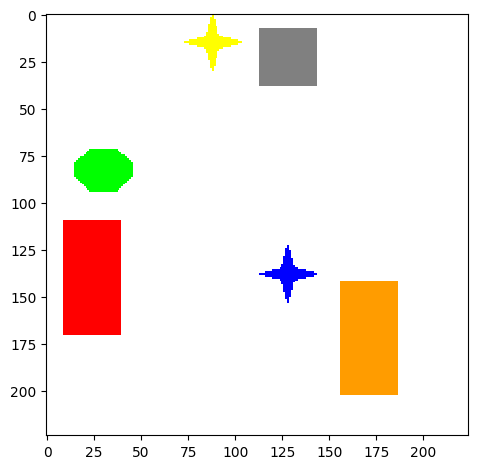

In [8]:
imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [9]:
objects

[(0, array([ 24, 140]), 'r', (9, 110, 39, 170)),
 (1, array([30, 79]), 'o', (15, 64, 45, 94)),
 (2, array([128, 138]), 's', (113, 123, 143, 153)),
 (3, array([171, 172]), 'r', (156, 142, 186, 202)),
 (4, array([128,  23]), 'q', (113, 8, 143, 38)),
 (5, array([88, 15]), 's', (73, 0, 103, 30))]

In [10]:
list(zip(queries, answers, programs))

[('What is the furthest shape from the yellow object?',
  'rectangle',
  'filter yellow <nxt> relate furthest <nxt> query shape'),
 ('What is the closest shape to the orange object?',
  'star',
  'filter orange <nxt> relate closest <nxt> query shape'),
 ('What is the furthest shape from the yellow object?',
  'rectangle',
  'filter yellow <nxt> relate furthest <nxt> query shape'),
 ('What is the furthest shape from the yellow object?',
  'rectangle',
  'filter yellow <nxt> relate furthest <nxt> query shape'),
 ('What is the furthest shape from the green object?',
  'rectangle',
  'filter green <nxt> relate furthest <nxt> query shape'),
 ('What is the furthest shape from the green object?',
  'rectangle',
  'filter green <nxt> relate furthest <nxt> query shape'),
 ('What is the furthest shape from the gray object?',
  'rectangle',
  'filter gray <nxt> relate furthest <nxt> query shape'),
 ('How many objects of the same shape as the red object are there?',
  '2',
  'filter red <nxt> quer

### Generate the full dataset

In [11]:
# Generate the dataset
n_train_imgs = 1000
n_test_imgs = 100

build_dataset(n_train_imgs, data_dir='data/train', prefix='train')
build_dataset(n_test_imgs, data_dir='data/test', prefix='test')

100%|█████████████████████████████████████████| 500/500 [00:14<00:00, 35.67it/s]


## Perception Module

### Train the Object Detector

In [12]:
from perception import *

In [13]:
def load_image_data(csv_file, img_dir):
    print(img_dir)
    '''Load the image detection data for training the object detector'''
    # Annotations
    annot = pd.read_csv(csv_file)
    
    data = {}
    for i in range(len(os.listdir(img_dir))):
        # Get all rows belonging to the same scene
        scene = annot[annot['filename'] == f'{i}.jpg']
        # Read the image
        img = cv2.imread(os.path.join(img_dir, f'{i}.jpg'))
#         print(scene)
        # Add bounding box information for dlib
        bboxes = []
        for row in scene.values:
            x1, y1, x2, y2 = row[-4:]
#             print(x1, y1, x2, y2)
            dlib_box = dlib.rectangle(left=x1 , top=y1, right=x2, bottom=y2)
#             print(dlib_box)
            bboxes.append(dlib_box)
        
        data[i] = (img, bboxes)
#     print(data)
    return data

In [14]:
# Load the Image Detection Data
det_data = load_image_data('data/train/train_img_det.csv', 'data/train/images')

data/train/images


In [15]:
# Load the Image Detection Data
tst_data = load_image_data('data/test/test_img_det.csv', 'data/test/images')

data/test/images


In [ ]:
# Create an instance of ObjectDetector
detector = ObjectDetector()

# Fit the detector
detector.fit(det_data, filename='detector.svm', visualize=True)


# Test the detector
detector.predict(tst_data)


### Shape Classifier

In [17]:
class Binarize():
    '''PyTorch Transforms Object'''
    def __init__(self):
        '''Converts Grayscale to Binary (except white every other color is zeroed)'''
        pass
    
    def __call__(self, img_tensor):
        '''
        Args:
            img_tensor (tensor): 0-1 scaled tensor with 1 channel
        Returns:
            tensor
        '''
        return (img_tensor > 0.95).float()

In [18]:
import torchvision.transforms as transforms

data_augmentation = transforms.Compose([
#     transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Grayscale(),
])
# Load the images with data augmentation
shapes_data = ImageFolder('data/shapes_data/', transform=data_augmentation)


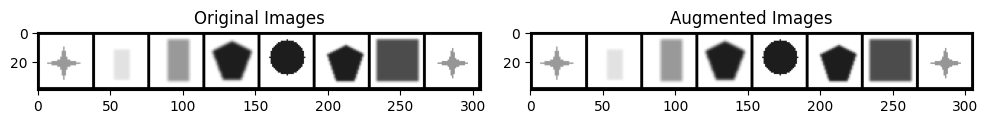

In [19]:
from torchvision.utils import make_grid
# Create a data loader to iterate over the images
batch_size = 8  # You can change the batch size as needed
data_loader = torch.utils.data.DataLoader(shapes_data, batch_size=batch_size, shuffle=True)

# Fetch a batch of images and their labels from the data loader
images, labels = next(iter(data_loader))

# Create a grid of images to visualize the results
grid = make_grid(images, nrow=batch_size)

# Convert the grid to a numpy array for visualization
grid_np = grid.numpy().transpose((1, 2, 0))

# Show the images before and after data augmentation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Images")
plt.imshow(grid_np[..., 0], cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Augmented Images")
plt.imshow(grid_np[..., 1], cmap='gray')

plt.tight_layout()
plt.show()

In [20]:
shapes_data

Dataset ImageFolder
    Number of datapoints: 7992
    Root location: data/shapes_data/
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Grayscale(num_output_channels=1)
           )

In [21]:
shapes_data.class_to_idx

{'circle': 0,
 'hexagon': 1,
 'octagon': 2,
 'pentagon': 3,
 'rectangle': 4,
 'square': 5,
 'star': 6,
 'triangle': 7}

In [22]:
# Create the dataloader
shapes_loader = DataLoader(shapes_data, batch_size=20, shuffle=True)

In [23]:
import os
import matplotlib.pyplot as plt

# Load the images
shapes_data_test = ImageFolder('data/shapes_data_test/', transform=tfms.Compose([tfms.Grayscale(),  
                                                                       tfms.ToTensor()]))
shapes_loader_test = DataLoader(shapes_data_test, batch_size=10, shuffle=True)

In [24]:
# Model
import torch.nn.functional as F

shape_classifier = ShapeClassifier()

In [25]:
shape_classifier

ShapeClassifier(
  (conv): Sequential(
    (0): Conv2d(1, 36, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(36, 36, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(36, 36, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=900, out_features=8, bias=True)
)

In [26]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
shape_classifier.train_classifier(shapes_loader, shapes_loader_test, lr=0.0001, epochs=100, filename='classifier.pth')

wandb: Currently logged in as: phoenix92 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.15.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1: 100%|█████████████████████| 400/400 [00:04<00:00, 98.44it/s, Loss=1.61]


Epoch 1: Mean Loss = 1.6897851207852363


Epoch 2: 100%|████████████████████| 400/400 [00:03<00:00, 130.22it/s, Loss=1.46]


Epoch 2: Mean Loss = 1.4455606827139855


Epoch 3: 100%|████████████████████| 400/400 [00:03<00:00, 127.55it/s, Loss=1.45]


Epoch 3: Mean Loss = 1.3652943694591522


Epoch 4: 100%|████████████████████| 400/400 [00:03<00:00, 129.89it/s, Loss=1.43]


Epoch 4: Mean Loss = 1.3313831341266633


Epoch 5: 100%|████████████████████| 400/400 [00:03<00:00, 128.87it/s, Loss=1.27]


Epoch 5: Mean Loss = 1.3130764755606652


Epoch 6: 100%|████████████████████| 400/400 [00:03<00:00, 129.82it/s, Loss=1.36]


Epoch 6: Mean Loss = 1.3055964669585227


Epoch 7: 100%|████████████████████| 400/400 [00:02<00:00, 136.29it/s, Loss=1.28]


Epoch 7: Mean Loss = 1.295839175283909


Epoch 8: 100%|████████████████████| 400/400 [00:02<00:00, 136.49it/s, Loss=1.28]


Epoch 8: Mean Loss = 1.2919194921851158


Epoch 9: 100%|████████████████████| 400/400 [00:03<00:00, 133.17it/s, Loss=1.27]


Epoch 9: Mean Loss = 1.2881124716997148


Epoch 10: 100%|███████████████████| 400/400 [00:02<00:00, 133.84it/s, Loss=1.35]


Epoch 10: Mean Loss = 1.2847488278150558


Epoch 11: 100%|███████████████████| 400/400 [00:02<00:00, 135.11it/s, Loss=1.27]


Epoch 11: Mean Loss = 1.2842908510565758


Epoch 12: 100%|███████████████████| 400/400 [00:02<00:00, 135.77it/s, Loss=1.27]


Epoch 12: Mean Loss = 1.2829275417327881


Epoch 13: 100%|███████████████████| 400/400 [00:02<00:00, 135.92it/s, Loss=1.27]


Epoch 13: Mean Loss = 1.2816318655014038


Epoch 14: 100%|███████████████████| 400/400 [00:02<00:00, 134.12it/s, Loss=1.27]


Epoch 14: Mean Loss = 1.2807801210880279


Epoch 15: 100%|███████████████████| 400/400 [00:02<00:00, 134.39it/s, Loss=1.27]


Epoch 15: Mean Loss = 1.279574787914753


Epoch 16: 100%|███████████████████| 400/400 [00:02<00:00, 134.57it/s, Loss=1.27]


Epoch 16: Mean Loss = 1.2805419832468032


Epoch 17: 100%|███████████████████| 400/400 [00:02<00:00, 136.19it/s, Loss=1.27]


Epoch 17: Mean Loss = 1.2786915382742883


Epoch 18: 100%|███████████████████| 400/400 [00:02<00:00, 134.73it/s, Loss=1.28]


Epoch 18: Mean Loss = 1.278538261950016


Epoch 19: 100%|███████████████████| 400/400 [00:02<00:00, 134.70it/s, Loss=1.27]


Epoch 19: Mean Loss = 1.2776696482300758


Epoch 20: 100%|███████████████████| 400/400 [00:02<00:00, 134.50it/s, Loss=1.27]


Epoch 20: Mean Loss = 1.2780145904421807


Epoch 21: 100%|███████████████████| 400/400 [00:03<00:00, 131.06it/s, Loss=1.27]


Epoch 21: Mean Loss = 1.2780476185679435


Epoch 22: 100%|███████████████████| 400/400 [00:03<00:00, 132.07it/s, Loss=1.27]


Epoch 22: Mean Loss = 1.2780287182331085


Epoch 23: 100%|███████████████████| 400/400 [00:02<00:00, 134.09it/s, Loss=1.27]


Epoch 23: Mean Loss = 1.278400537967682


Epoch 24: 100%|███████████████████| 400/400 [00:03<00:00, 132.83it/s, Loss=1.27]


Epoch 24: Mean Loss = 1.2792129024863244


Epoch 25: 100%|███████████████████| 400/400 [00:03<00:00, 132.79it/s, Loss=1.27]


Epoch 25: Mean Loss = 1.2775577786564827


Epoch 26: 100%|███████████████████| 400/400 [00:02<00:00, 134.00it/s, Loss=1.29]


Epoch 26: Mean Loss = 1.2780769667029381


Epoch 27: 100%|███████████████████| 400/400 [00:02<00:00, 134.04it/s, Loss=1.27]


Epoch 27: Mean Loss = 1.277906278371811


Epoch 28: 100%|███████████████████| 400/400 [00:03<00:00, 130.96it/s, Loss=1.27]


Epoch 28: Mean Loss = 1.277190417945385


Epoch 29: 100%|███████████████████| 400/400 [00:03<00:00, 131.51it/s, Loss=1.27]


Epoch 29: Mean Loss = 1.277145816385746


Epoch 30: 100%|███████████████████| 400/400 [00:02<00:00, 136.27it/s, Loss=1.27]


Epoch 30: Mean Loss = 1.2776585295796394


Epoch 31: 100%|███████████████████| 400/400 [00:02<00:00, 134.70it/s, Loss=1.27]


Epoch 31: Mean Loss = 1.2779443740844727


Epoch 32: 100%|███████████████████| 400/400 [00:03<00:00, 132.38it/s, Loss=1.27]


Epoch 32: Mean Loss = 1.2771658134460449


Epoch 33: 100%|███████████████████| 400/400 [00:02<00:00, 136.15it/s, Loss=1.27]


Epoch 33: Mean Loss = 1.2774799799919128


Epoch 34: 100%|███████████████████| 400/400 [00:02<00:00, 133.62it/s, Loss=1.27]


Epoch 34: Mean Loss = 1.277868882417679


Epoch 35: 100%|███████████████████| 400/400 [00:02<00:00, 133.54it/s, Loss=1.27]


Epoch 35: Mean Loss = 1.278612380027771


Epoch 36: 100%|███████████████████| 400/400 [00:02<00:00, 133.85it/s, Loss=1.27]


Epoch 36: Mean Loss = 1.2784496480226517


Epoch 37: 100%|███████████████████| 400/400 [00:03<00:00, 132.89it/s, Loss=1.27]


Epoch 37: Mean Loss = 1.2777058085799218


Epoch 38: 100%|███████████████████| 400/400 [00:03<00:00, 133.26it/s, Loss=1.27]


Epoch 38: Mean Loss = 1.2790118196606637


Epoch 39: 100%|███████████████████| 400/400 [00:03<00:00, 132.44it/s, Loss=1.27]


Epoch 39: Mean Loss = 1.2778785595297812


Epoch 40: 100%|███████████████████| 400/400 [00:02<00:00, 133.90it/s, Loss=1.27]


Epoch 40: Mean Loss = 1.2768644139170646


Epoch 41: 100%|███████████████████| 400/400 [00:03<00:00, 131.99it/s, Loss=1.27]


Epoch 41: Mean Loss = 1.2777788946032524


Epoch 42: 100%|███████████████████| 400/400 [00:03<00:00, 129.76it/s, Loss=1.27]


Epoch 42: Mean Loss = 1.2783821052312851


Epoch 43: 100%|███████████████████| 400/400 [00:02<00:00, 133.63it/s, Loss=1.27]


Epoch 43: Mean Loss = 1.2777847170829773


Epoch 44: 100%|███████████████████| 400/400 [00:02<00:00, 133.91it/s, Loss=1.27]


Epoch 44: Mean Loss = 1.2781652662158012


Epoch 45: 100%|███████████████████| 400/400 [00:03<00:00, 132.80it/s, Loss=1.27]


Epoch 45: Mean Loss = 1.2781076908111573


Epoch 46: 100%|███████████████████| 400/400 [00:03<00:00, 131.99it/s, Loss=1.27]


Epoch 46: Mean Loss = 1.2781047591567039


Epoch 47: 100%|███████████████████| 400/400 [00:02<00:00, 133.34it/s, Loss=1.27]


Epoch 47: Mean Loss = 1.2785905614495277


Epoch 48: 100%|███████████████████| 400/400 [00:03<00:00, 133.09it/s, Loss=1.27]


Epoch 48: Mean Loss = 1.2782686439156532


Epoch 49: 100%|███████████████████| 400/400 [00:03<00:00, 131.92it/s, Loss=1.27]


Epoch 49: Mean Loss = 1.2777843904495239


Epoch 50: 100%|███████████████████| 400/400 [00:03<00:00, 133.03it/s, Loss=1.27]


Epoch 50: Mean Loss = 1.2777006456255913


Epoch 51: 100%|███████████████████| 400/400 [00:03<00:00, 132.74it/s, Loss=1.27]


Epoch 51: Mean Loss = 1.2771798834204673


Epoch 52: 100%|███████████████████| 400/400 [00:03<00:00, 129.95it/s, Loss=1.27]


Epoch 52: Mean Loss = 1.2780751451849937


Epoch 53: 100%|███████████████████| 400/400 [00:03<00:00, 131.42it/s, Loss=1.27]


Epoch 53: Mean Loss = 1.2781845062971116


Epoch 54: 100%|███████████████████| 400/400 [00:02<00:00, 133.73it/s, Loss=1.27]


Epoch 54: Mean Loss = 1.2771962428092956


Epoch 55: 100%|███████████████████| 400/400 [00:03<00:00, 133.05it/s, Loss=1.27]


Epoch 55: Mean Loss = 1.2769812896847725


Epoch 56: 100%|███████████████████| 400/400 [00:03<00:00, 132.63it/s, Loss=1.27]


Epoch 56: Mean Loss = 1.2766973665356636


Epoch 57: 100%|███████████████████| 400/400 [00:03<00:00, 132.59it/s, Loss=1.27]


Epoch 57: Mean Loss = 1.2767593416571617


Epoch 58: 100%|███████████████████| 400/400 [00:03<00:00, 132.41it/s, Loss=1.27]


Epoch 58: Mean Loss = 1.2768913543224334


Epoch 59: 100%|███████████████████| 400/400 [00:03<00:00, 132.21it/s, Loss=1.27]


Epoch 59: Mean Loss = 1.277970490157604


Epoch 60: 100%|███████████████████| 400/400 [00:03<00:00, 131.70it/s, Loss=1.27]


Epoch 60: Mean Loss = 1.2772696927189826


Epoch 61: 100%|███████████████████| 400/400 [00:03<00:00, 130.67it/s, Loss=1.27]


Epoch 61: Mean Loss = 1.2768853718042374


Epoch 62: 100%|███████████████████| 400/400 [00:03<00:00, 128.94it/s, Loss=1.27]


Epoch 62: Mean Loss = 1.2771762722730637


Epoch 63: 100%|███████████████████| 400/400 [00:02<00:00, 134.04it/s, Loss=1.27]


Epoch 63: Mean Loss = 1.2768937957286834


Epoch 64: 100%|███████████████████| 400/400 [00:02<00:00, 133.77it/s, Loss=1.27]


Epoch 64: Mean Loss = 1.2766342017054557


Epoch 65: 100%|███████████████████| 400/400 [00:03<00:00, 132.57it/s, Loss=1.27]


Epoch 65: Mean Loss = 1.2769322642683982


Epoch 66: 100%|███████████████████| 400/400 [00:03<00:00, 132.13it/s, Loss=1.27]


Epoch 66: Mean Loss = 1.2772622397542


Epoch 67: 100%|███████████████████| 400/400 [00:02<00:00, 133.69it/s, Loss=1.27]


Epoch 67: Mean Loss = 1.2771341124176978


Epoch 68: 100%|███████████████████| 400/400 [00:03<00:00, 132.39it/s, Loss=1.27]


Epoch 68: Mean Loss = 1.2771323281526565


Epoch 69: 100%|███████████████████| 400/400 [00:03<00:00, 132.20it/s, Loss=1.27]


Epoch 69: Mean Loss = 1.2770058837532998


Epoch 70: 100%|███████████████████| 400/400 [00:03<00:00, 132.43it/s, Loss=1.27]


Epoch 70: Mean Loss = 1.2768966218829154


Epoch 71: 100%|███████████████████| 400/400 [00:03<00:00, 132.26it/s, Loss=1.27]


Epoch 71: Mean Loss = 1.2770931488275528


Epoch 72: 100%|███████████████████| 400/400 [00:02<00:00, 137.66it/s, Loss=1.27]


Epoch 72: Mean Loss = 1.277139987051487


Epoch 73: 100%|███████████████████| 400/400 [00:03<00:00, 130.91it/s, Loss=1.27]


Epoch 73: Mean Loss = 1.2770234885811806


Epoch 74: 100%|███████████████████| 400/400 [00:03<00:00, 130.80it/s, Loss=1.27]


Epoch 74: Mean Loss = 1.2773126009106637


Epoch 75: 100%|███████████████████| 400/400 [00:02<00:00, 133.62it/s, Loss=1.27]


Epoch 75: Mean Loss = 1.2773819783329963


Epoch 76: 100%|███████████████████| 400/400 [00:03<00:00, 132.01it/s, Loss=1.27]


Epoch 76: Mean Loss = 1.2772642210125924


Epoch 77: 100%|███████████████████| 400/400 [00:03<00:00, 129.44it/s, Loss=1.27]


Epoch 77: Mean Loss = 1.2778971454501151


Epoch 78: 100%|███████████████████| 400/400 [00:02<00:00, 134.19it/s, Loss=1.27]


Epoch 78: Mean Loss = 1.27803023904562


Epoch 79: 100%|███████████████████| 400/400 [00:02<00:00, 138.10it/s, Loss=1.27]


Epoch 79: Mean Loss = 1.2776749700307846


Epoch 80: 100%|███████████████████| 400/400 [00:02<00:00, 138.76it/s, Loss=1.27]


Epoch 80: Mean Loss = 1.2773487657308578


Epoch 81: 100%|███████████████████| 400/400 [00:02<00:00, 136.12it/s, Loss=1.27]


Epoch 81: Mean Loss = 1.2767955628037453


Epoch 82: 100%|███████████████████| 400/400 [00:03<00:00, 122.29it/s, Loss=1.27]


Epoch 82: Mean Loss = 1.2766567188501359


Epoch 83: 100%|███████████████████| 400/400 [00:03<00:00, 130.69it/s, Loss=1.27]


Epoch 83: Mean Loss = 1.2766412213444709


Epoch 84: 100%|███████████████████| 400/400 [00:03<00:00, 132.49it/s, Loss=1.27]


Epoch 84: Mean Loss = 1.277914241552353


Epoch 85: 100%|███████████████████| 400/400 [00:03<00:00, 132.77it/s, Loss=1.27]


Epoch 85: Mean Loss = 1.2779648873209952


Epoch 86: 100%|███████████████████| 400/400 [00:03<00:00, 132.41it/s, Loss=1.27]


Epoch 86: Mean Loss = 1.2770299911499023


Epoch 87: 100%|███████████████████| 400/400 [00:02<00:00, 133.58it/s, Loss=1.27]


Epoch 87: Mean Loss = 1.2775095418095588


Epoch 88: 100%|███████████████████| 400/400 [00:03<00:00, 132.54it/s, Loss=1.27]


Epoch 88: Mean Loss = 1.277431913614273


Epoch 89: 100%|███████████████████| 400/400 [00:03<00:00, 132.00it/s, Loss=1.27]


Epoch 89: Mean Loss = 1.2773999539017677


Epoch 90: 100%|███████████████████| 400/400 [00:03<00:00, 132.69it/s, Loss=1.27]


Epoch 90: Mean Loss = 1.2769930067658424


Epoch 91: 100%|███████████████████| 400/400 [00:03<00:00, 132.57it/s, Loss=1.27]


Epoch 91: Mean Loss = 1.276759111881256


Epoch 92: 100%|███████████████████| 400/400 [00:03<00:00, 133.32it/s, Loss=1.27]


Epoch 92: Mean Loss = 1.2766864836215972


Epoch 93: 100%|███████████████████| 400/400 [00:03<00:00, 132.87it/s, Loss=1.27]


Epoch 93: Mean Loss = 1.277008987367153


Epoch 94: 100%|███████████████████| 400/400 [00:03<00:00, 132.34it/s, Loss=1.27]


Epoch 94: Mean Loss = 1.2769130617380142


Epoch 95: 100%|███████████████████| 400/400 [00:03<00:00, 131.96it/s, Loss=1.27]


Epoch 95: Mean Loss = 1.2769016537070275


Epoch 96: 100%|███████████████████| 400/400 [00:02<00:00, 133.94it/s, Loss=1.27]


Epoch 96: Mean Loss = 1.277559735774994


Epoch 97: 100%|███████████████████| 400/400 [00:03<00:00, 132.59it/s, Loss=1.27]


Epoch 97: Mean Loss = 1.2782554990053177


Epoch 98: 100%|███████████████████| 400/400 [00:03<00:00, 132.73it/s, Loss=1.27]


Epoch 98: Mean Loss = 1.2783390131592751


Epoch 99: 100%|███████████████████| 400/400 [00:03<00:00, 132.92it/s, Loss=1.27]


Epoch 99: Mean Loss = 1.2770973959565162


Epoch 100: 100%|██████████████████| 400/400 [00:02<00:00, 133.80it/s, Loss=1.27]


Epoch 100: Mean Loss = 1.2769100418686867
Test Loss = 1.2778 Test Accuracy = 1.00


In [27]:
# # Train
# shape_classifier.train_classifier(shapes_loader, shapes_loader_test, lr=0.001, epochs=300, filename='classifier.pth')

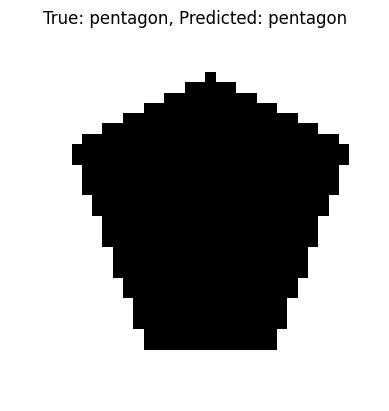

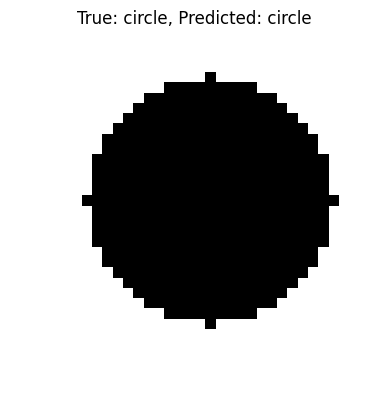

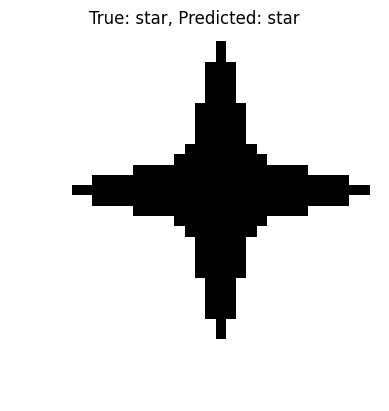

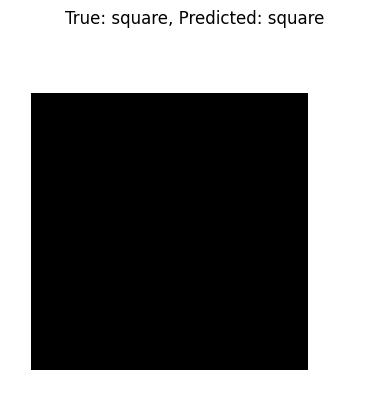

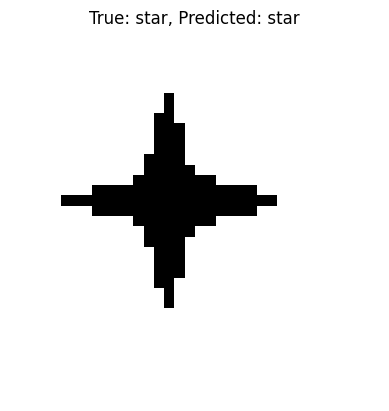

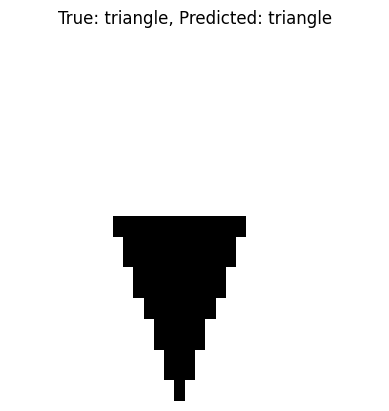

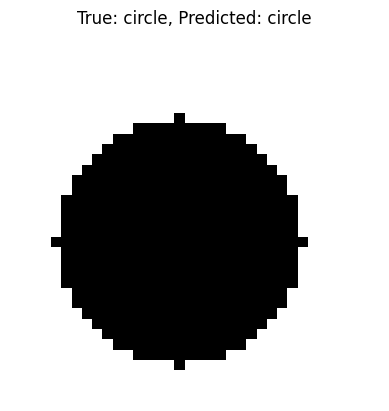

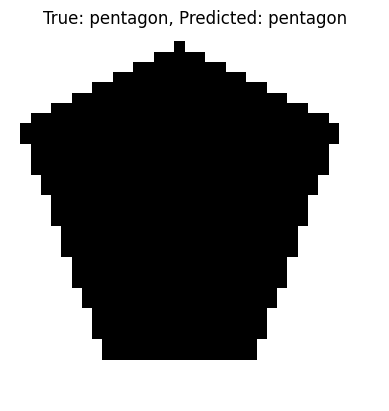

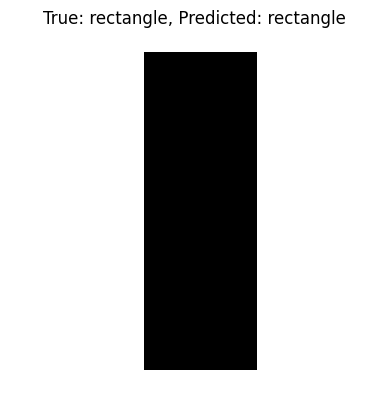

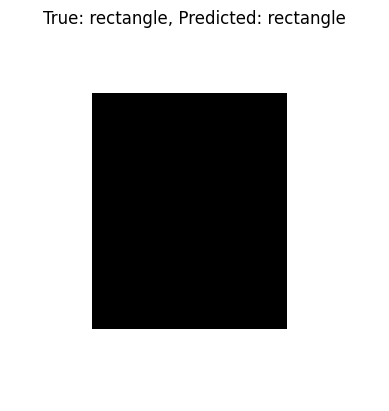

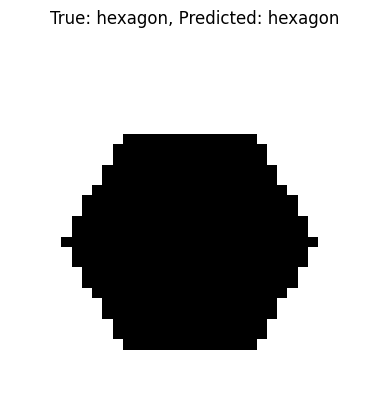

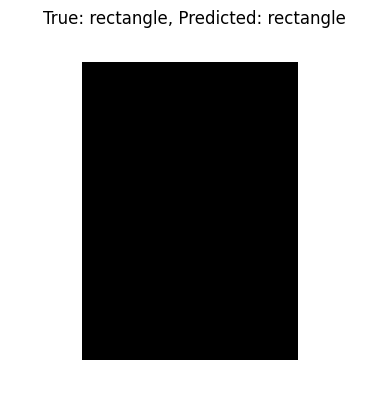

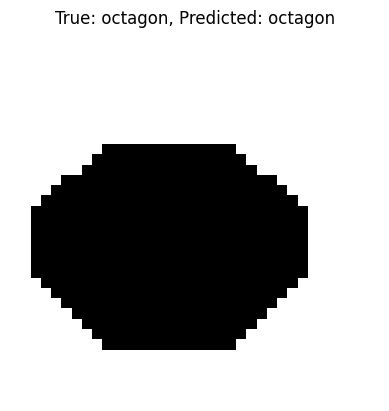

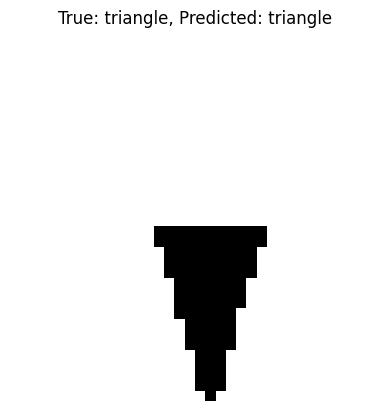

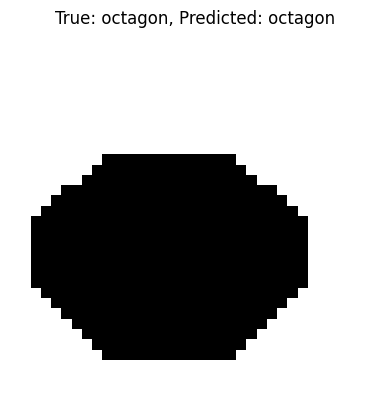

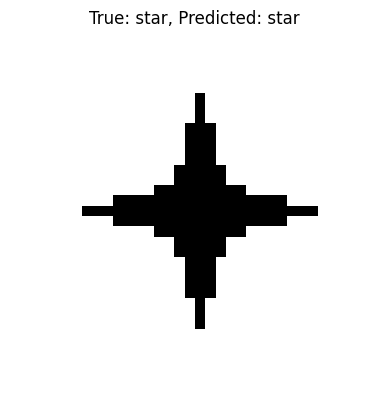

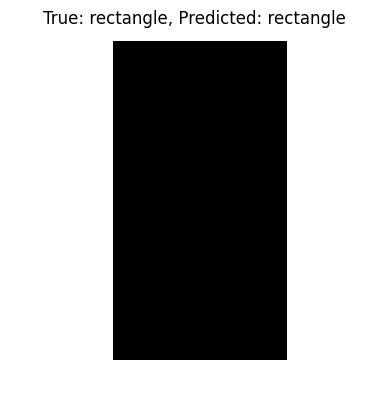

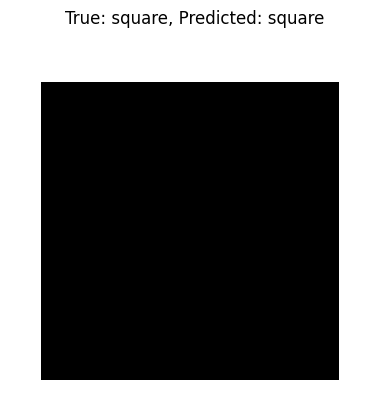

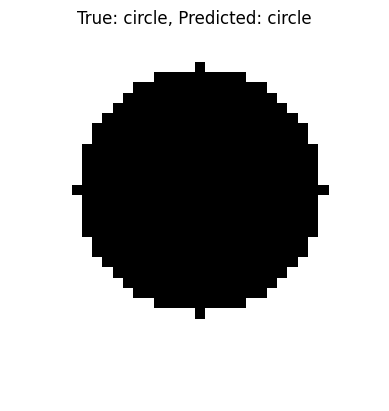

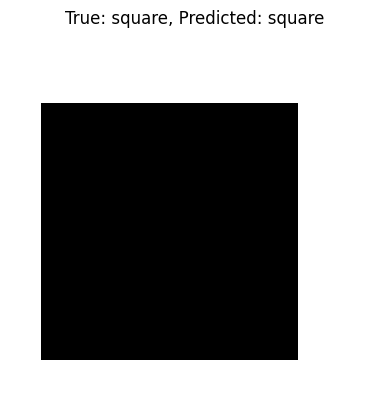

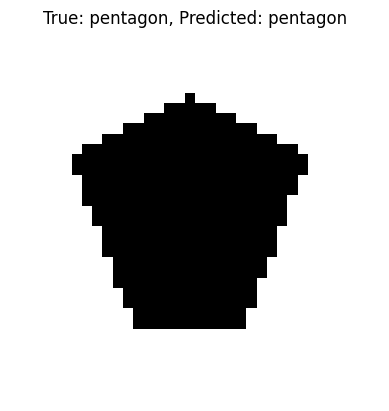

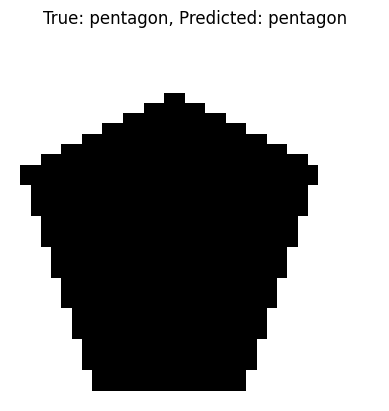

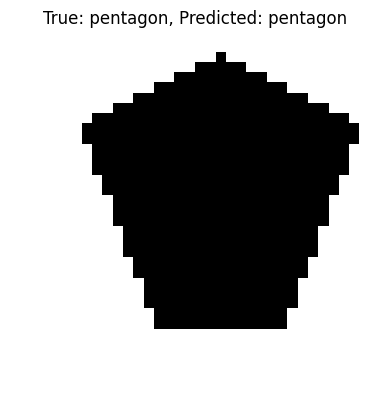

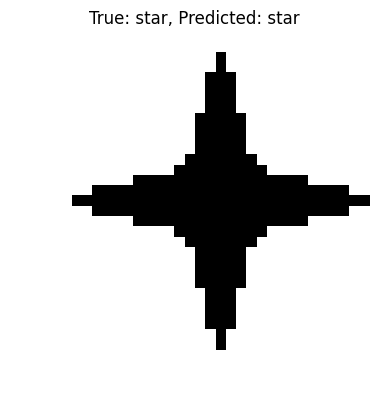

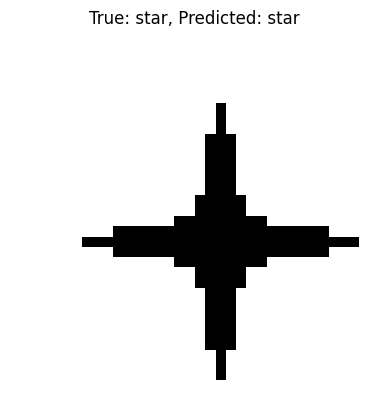

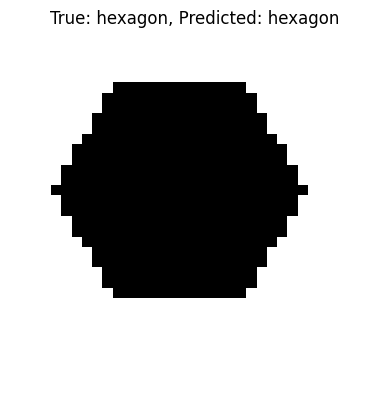

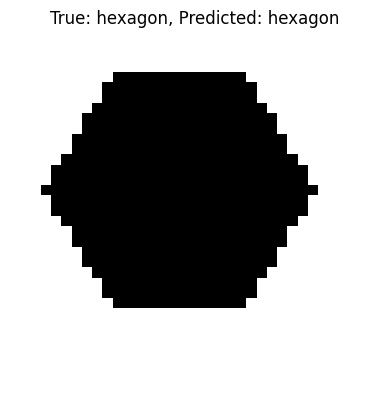

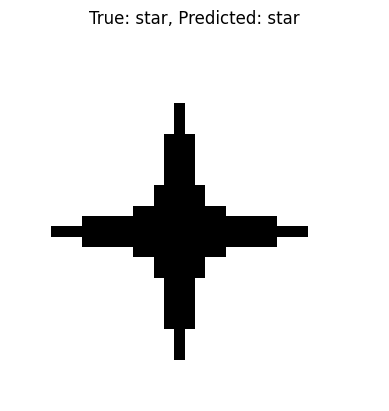

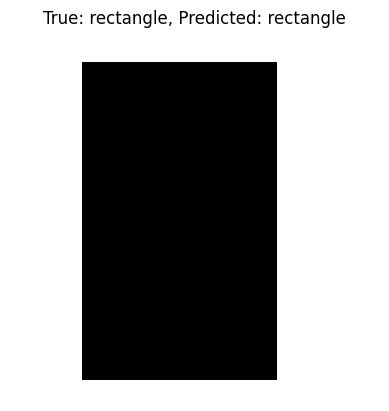

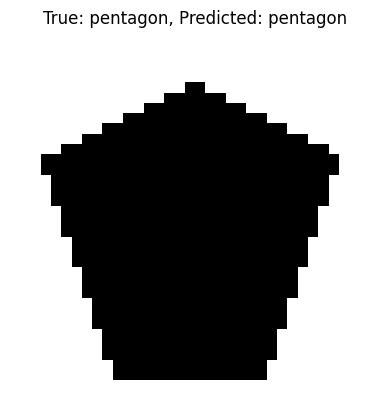

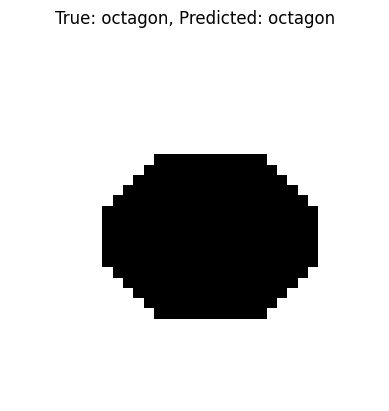

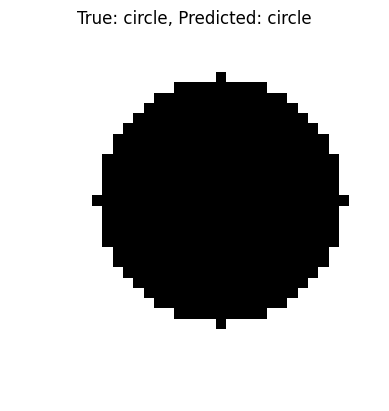

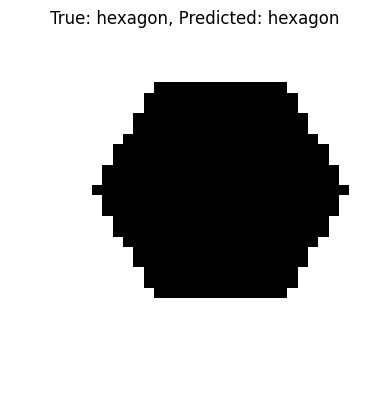

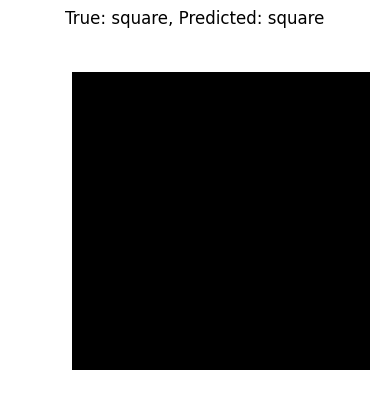

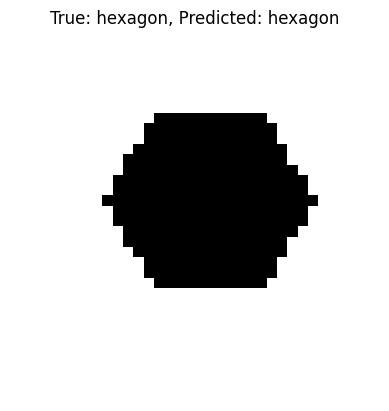

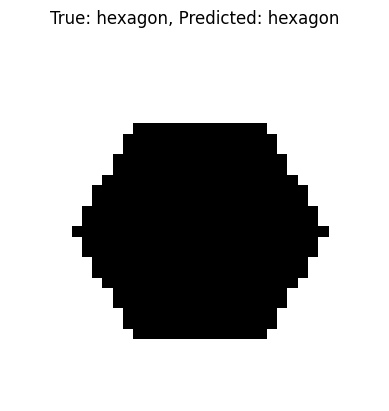

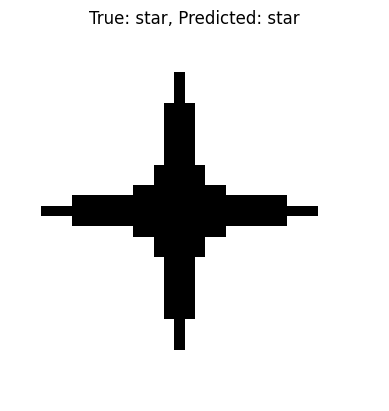

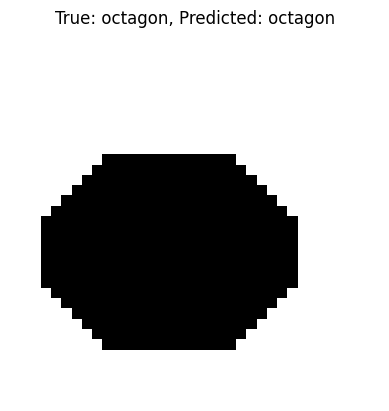

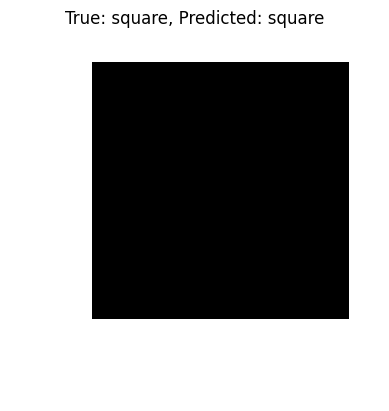

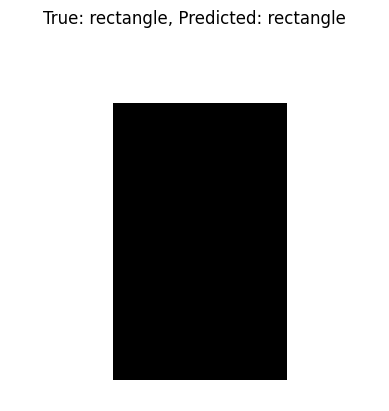

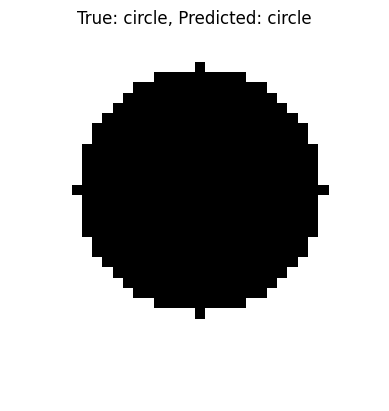

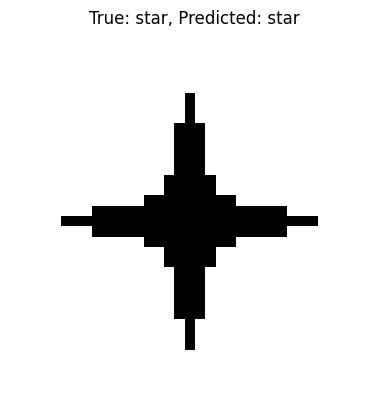

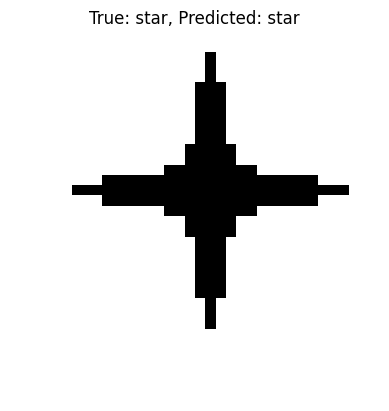

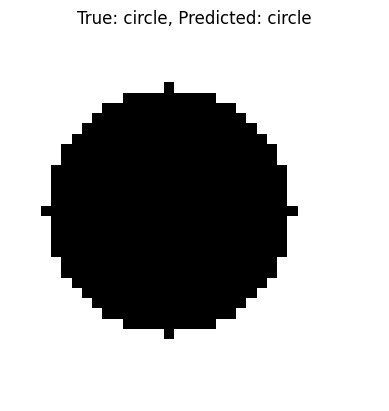

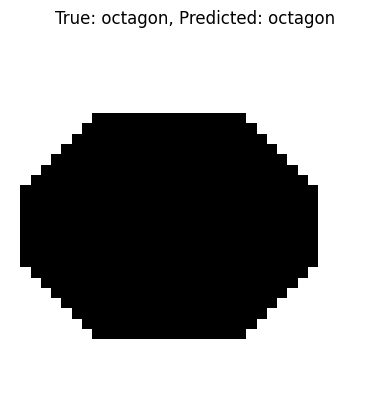

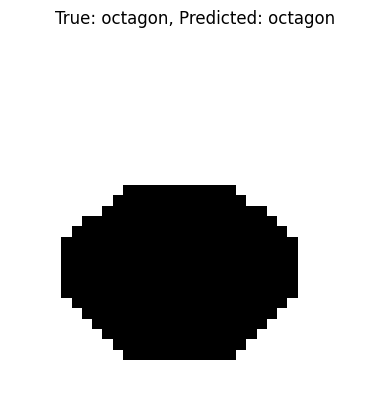

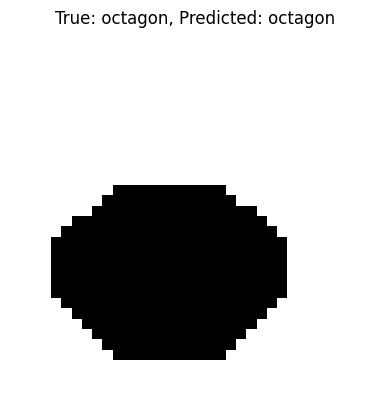

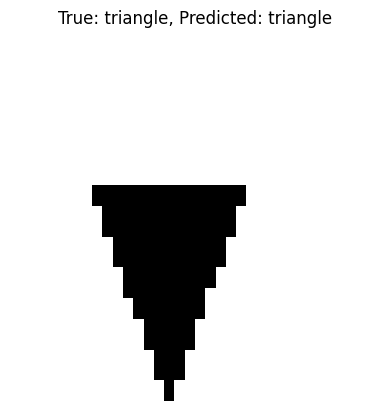

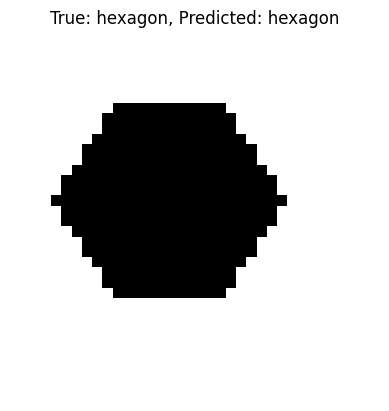

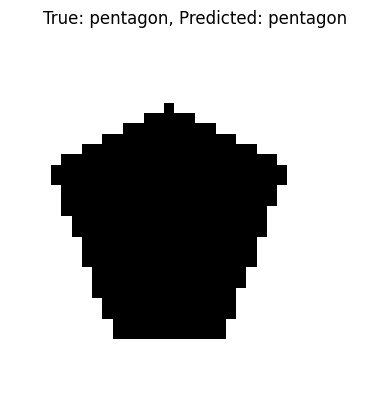

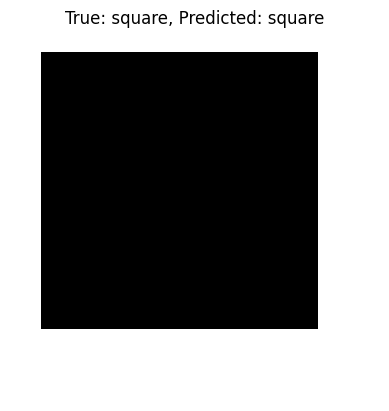

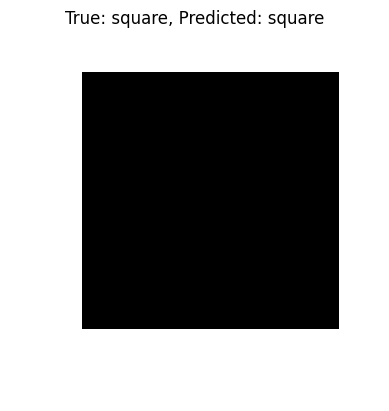

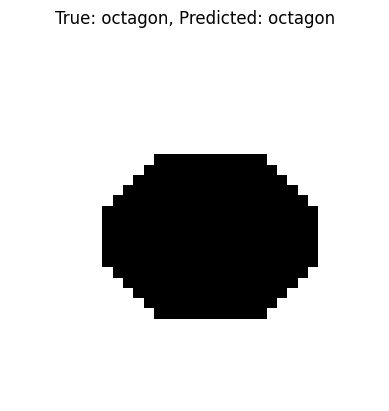

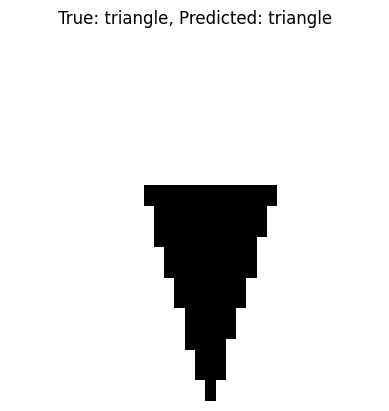

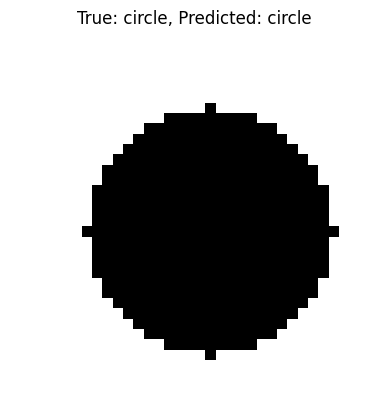

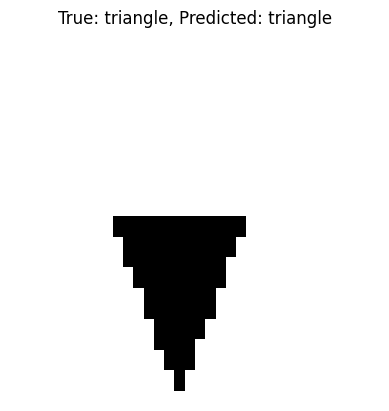

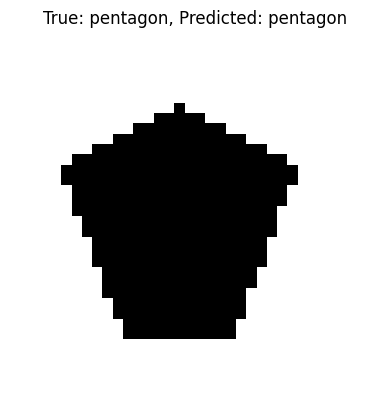

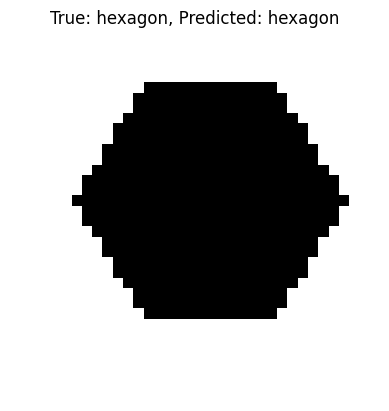

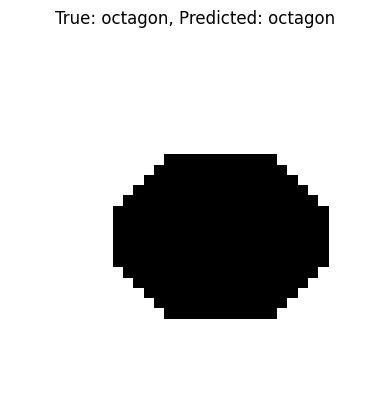

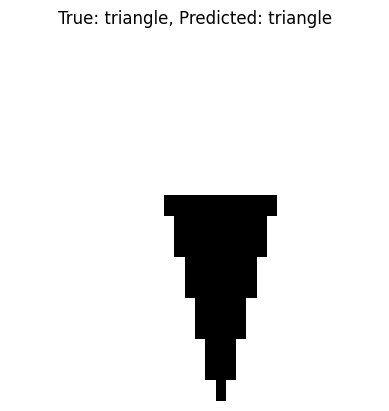

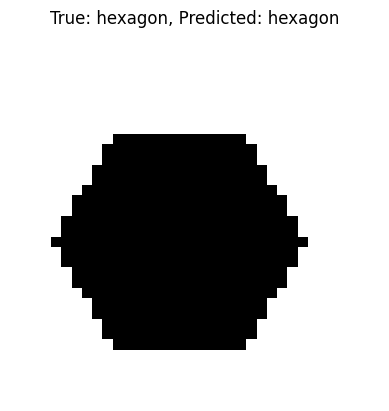

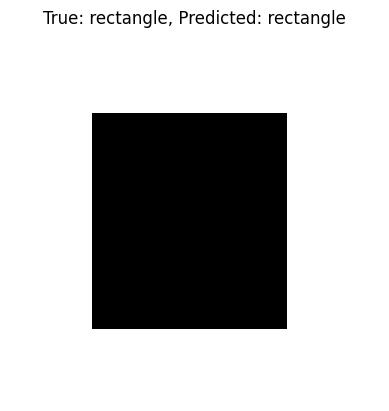

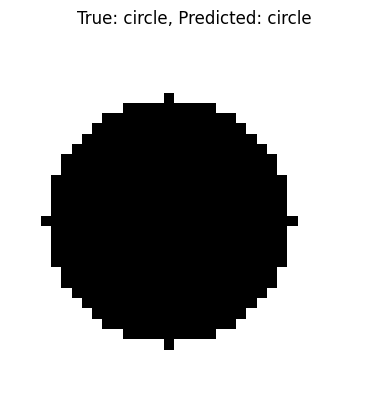

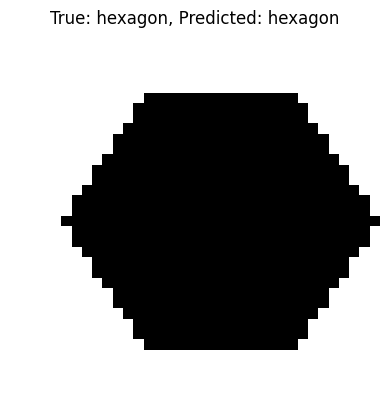

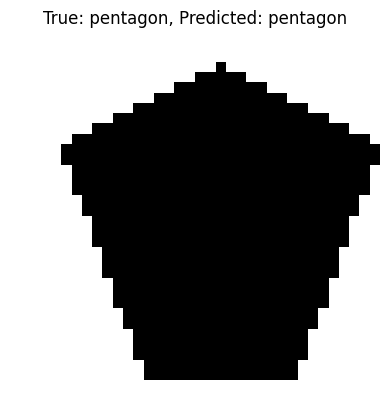

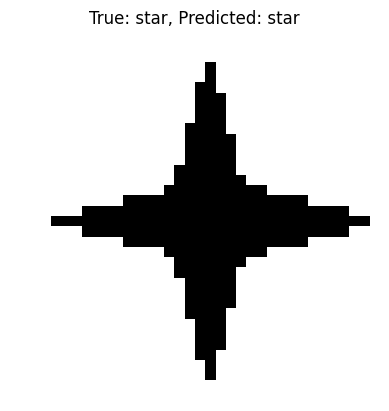

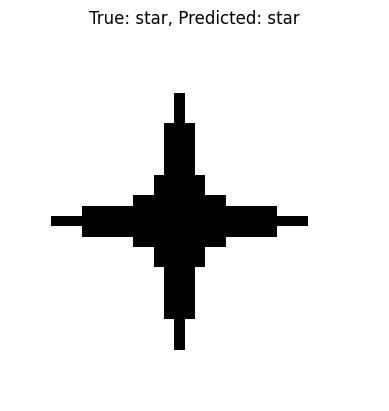

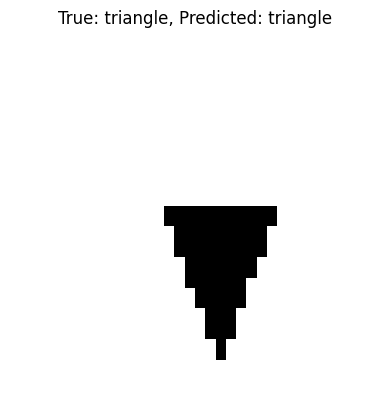

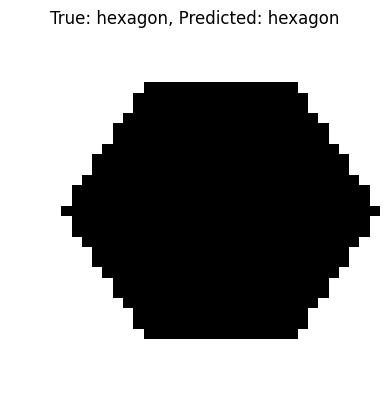

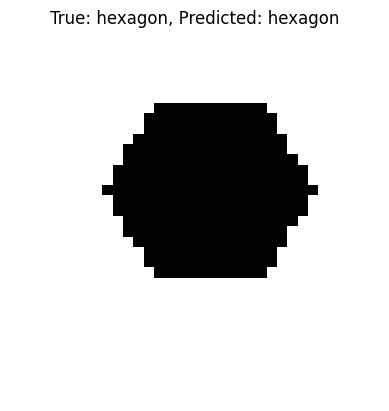

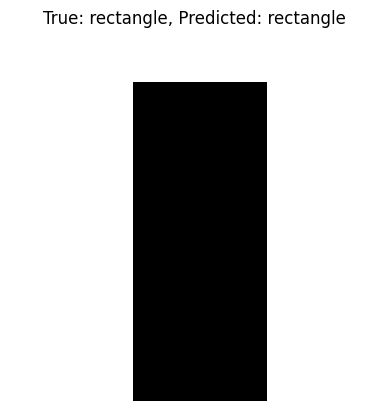

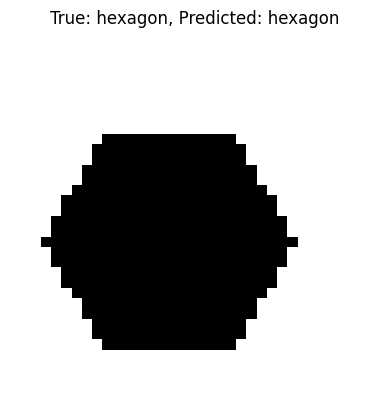

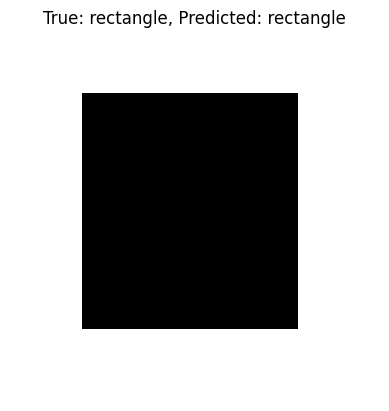

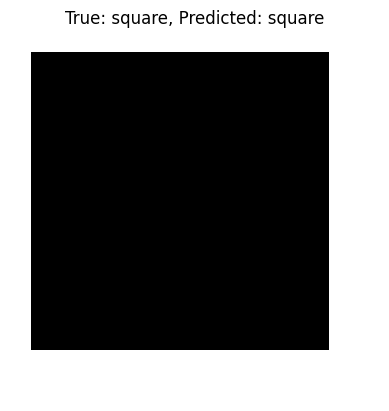

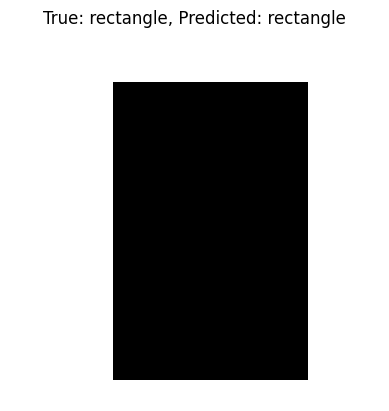

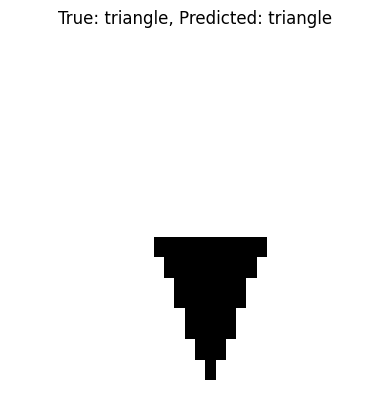

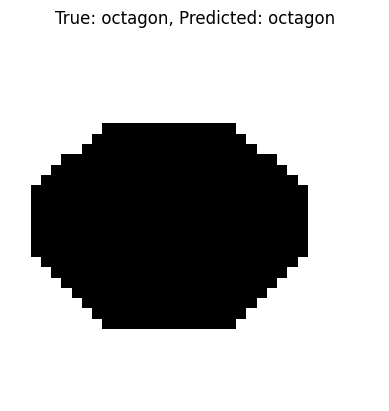

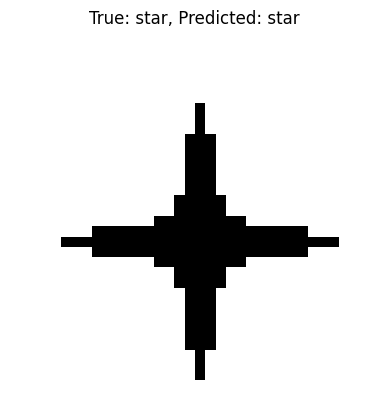

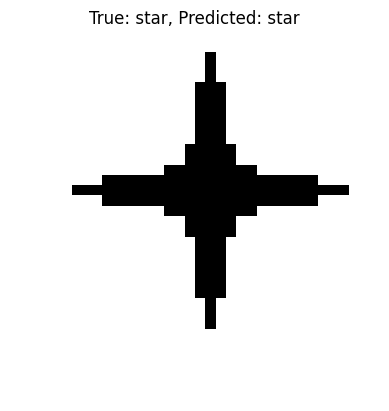

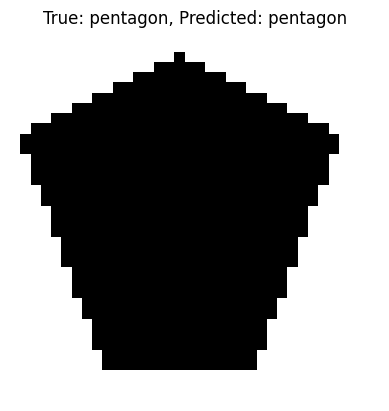

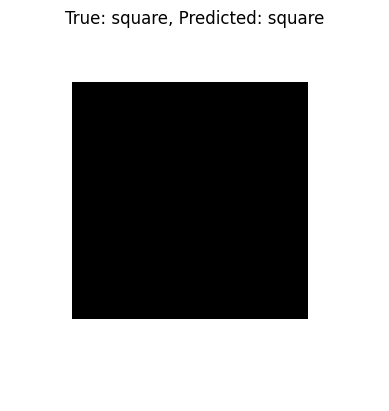

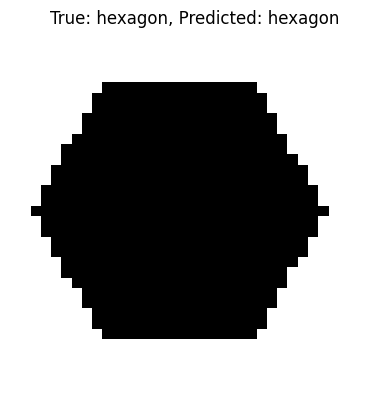

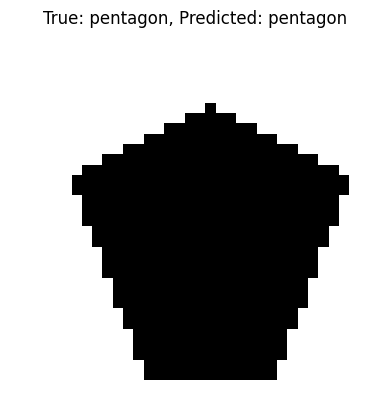

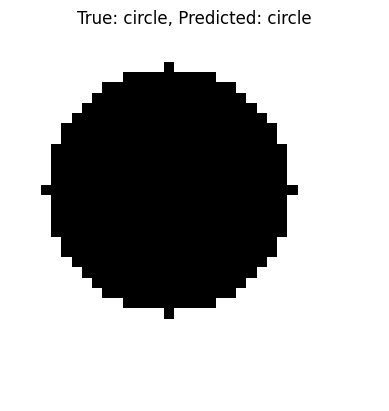

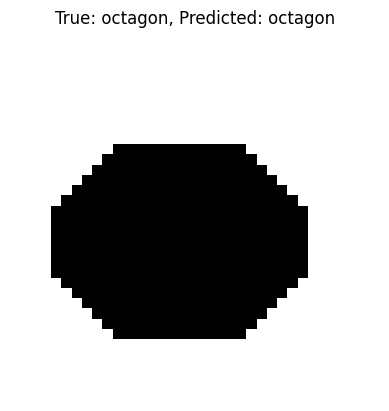

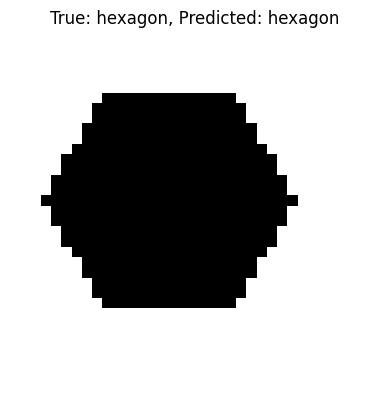

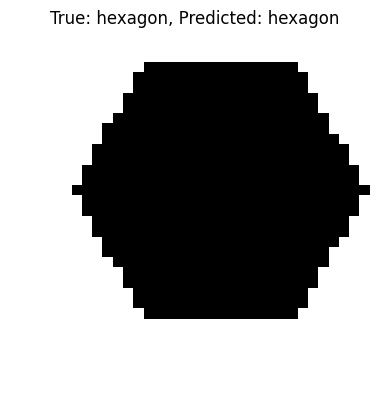

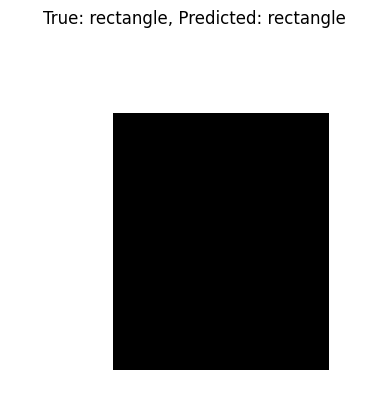

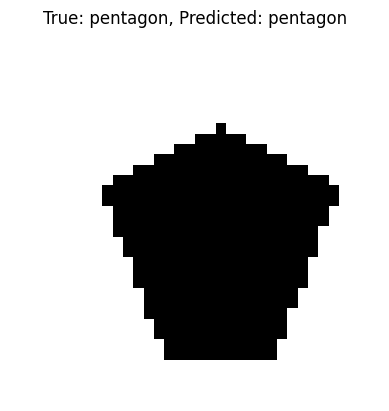

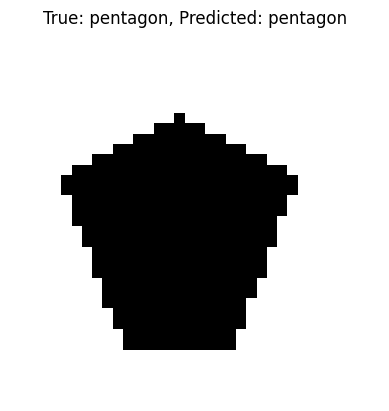

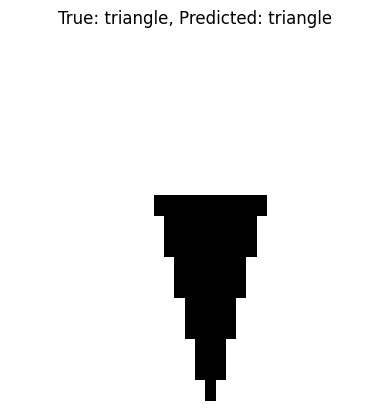

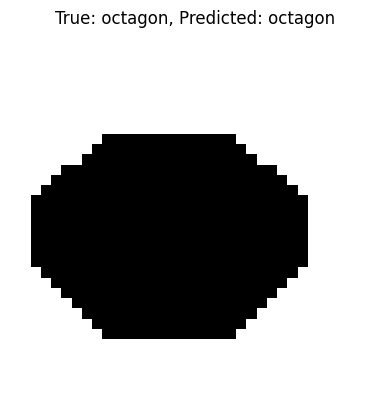

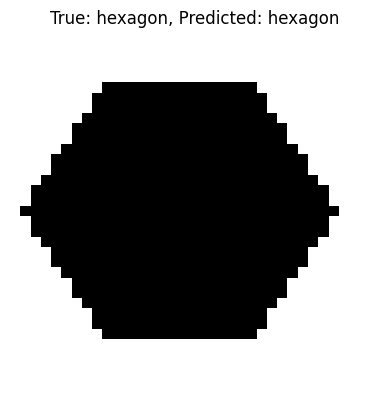

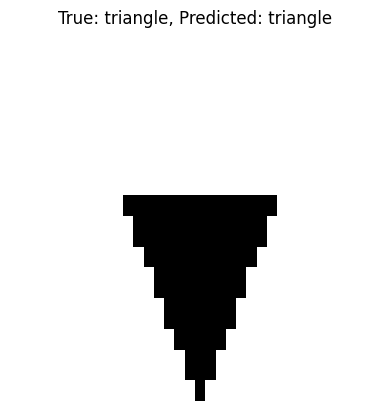

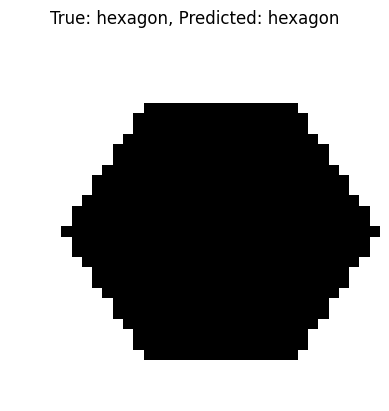

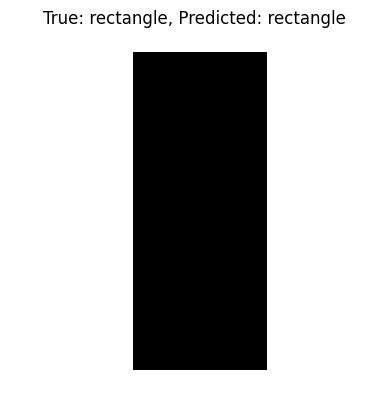

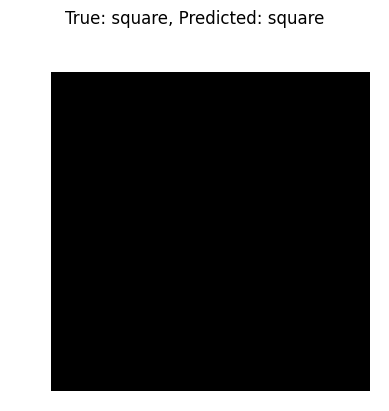

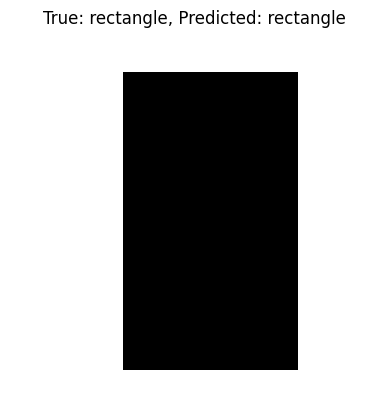

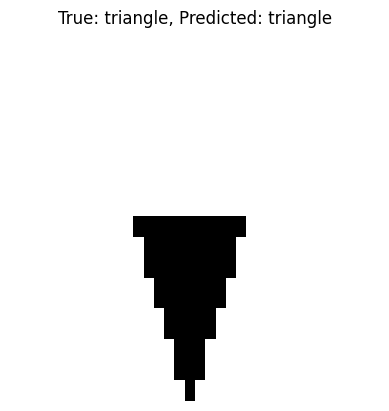

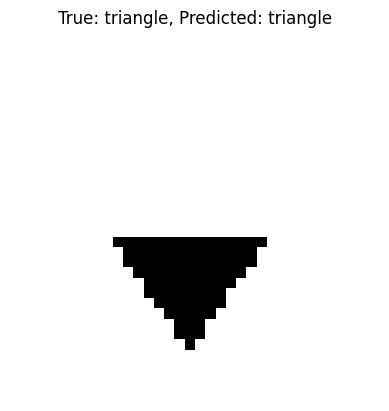

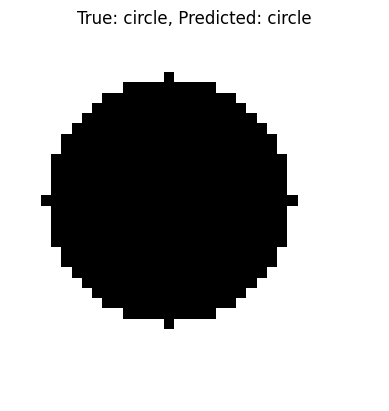

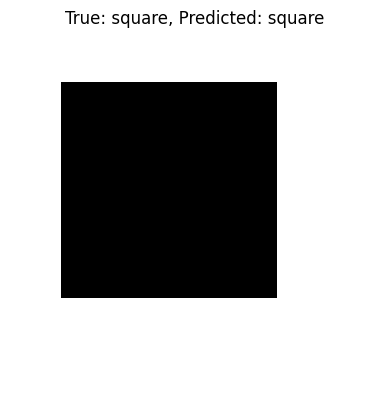

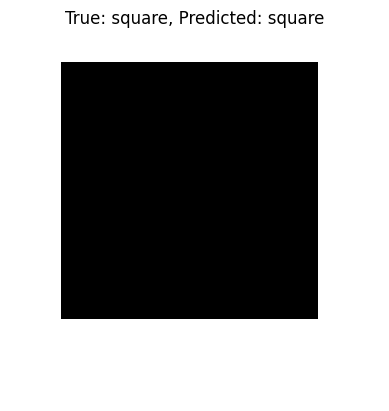

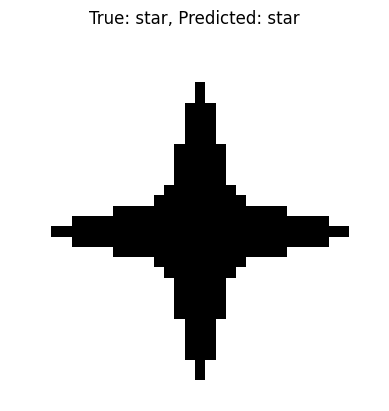

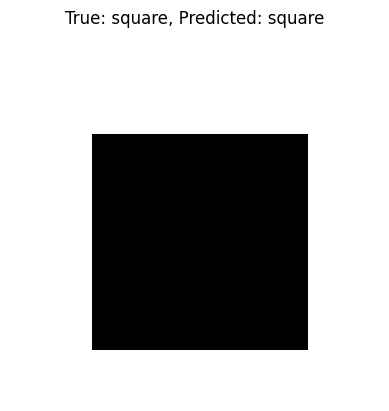

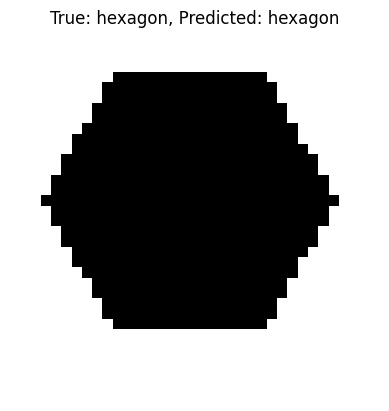

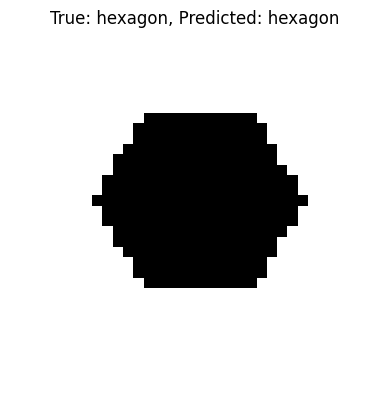

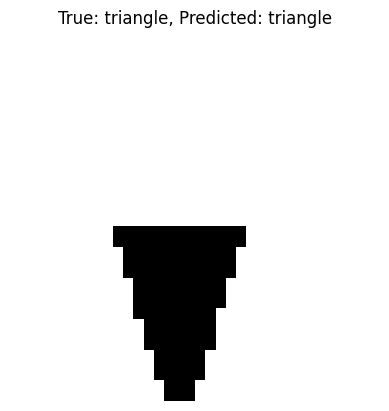

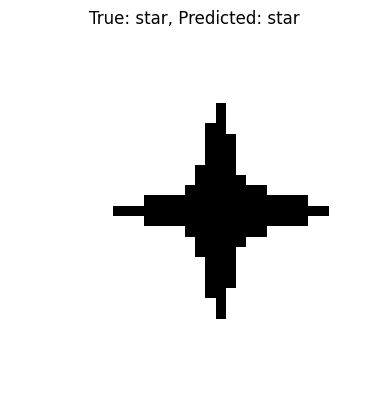

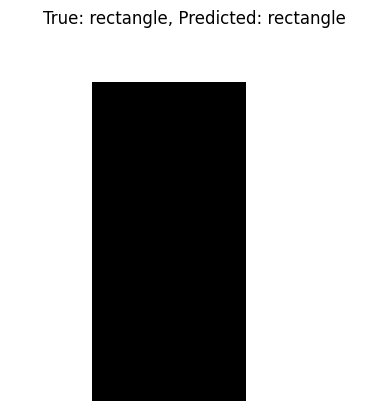

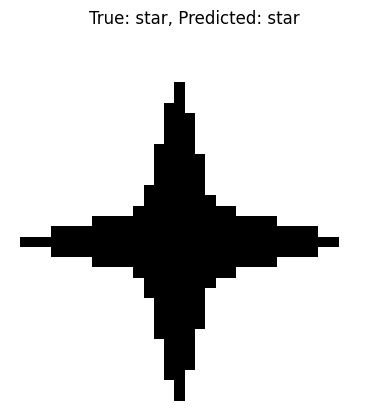

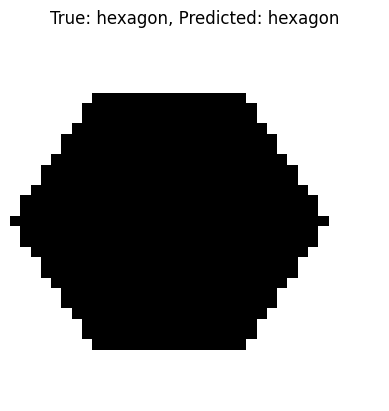

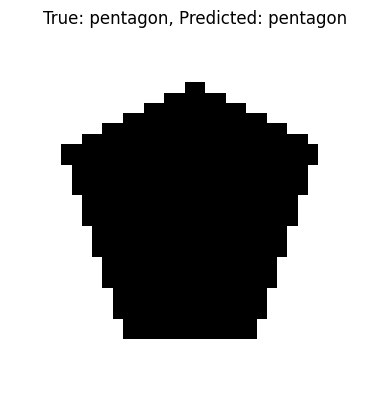

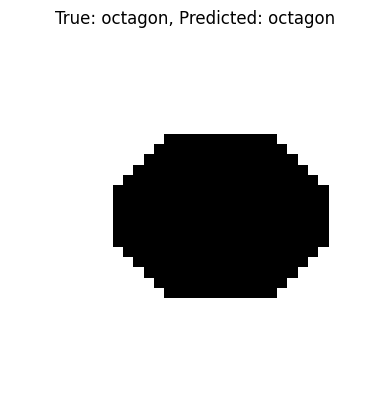

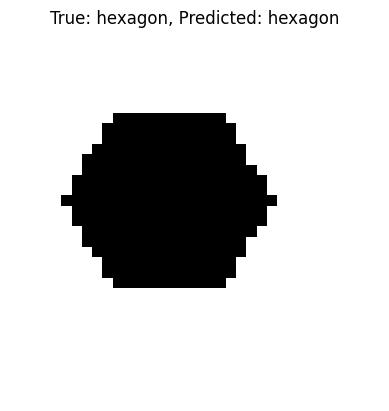

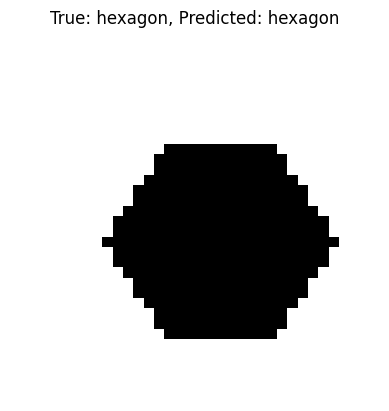

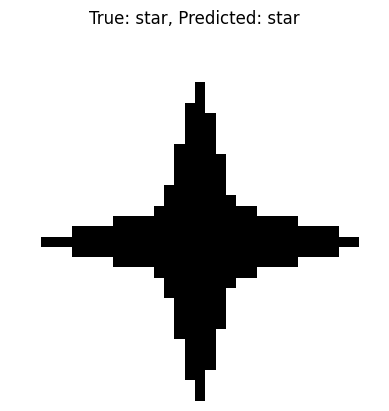

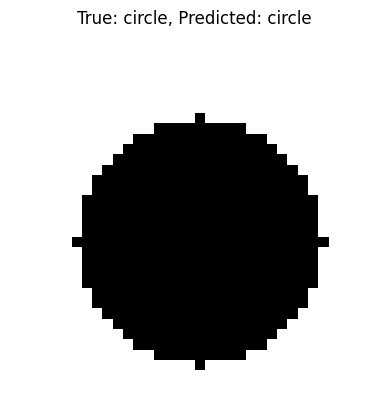

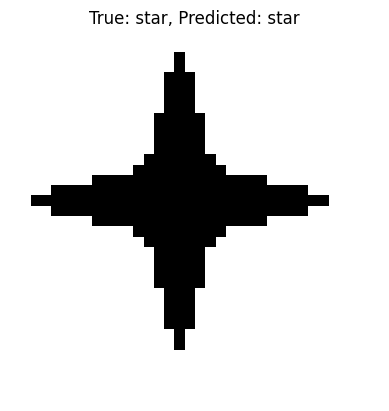

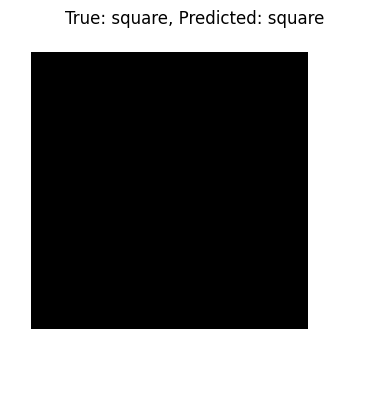

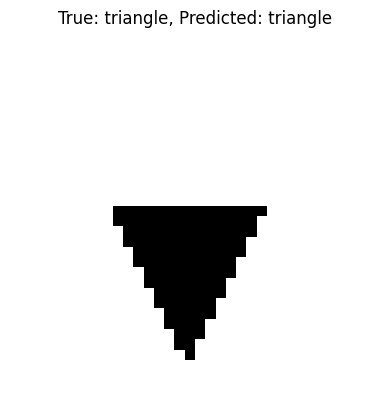

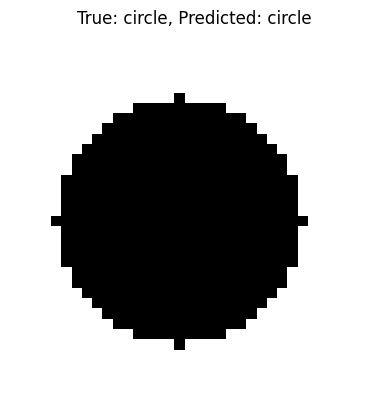

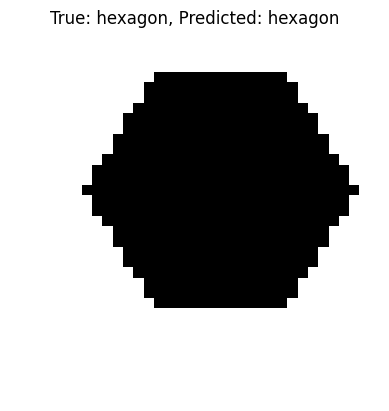

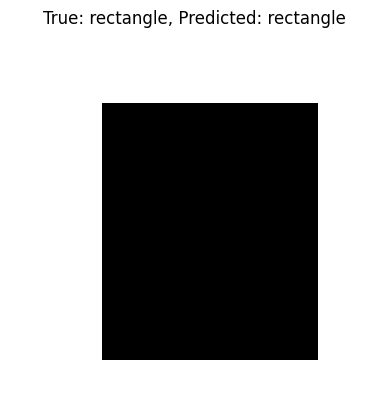

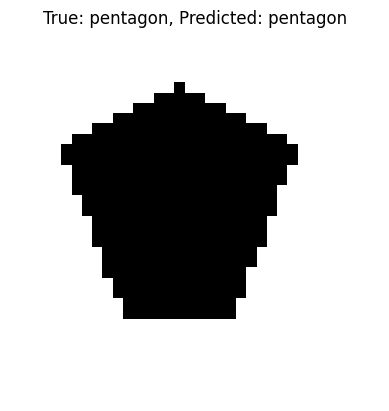

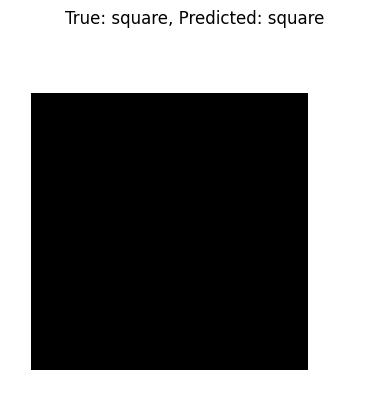

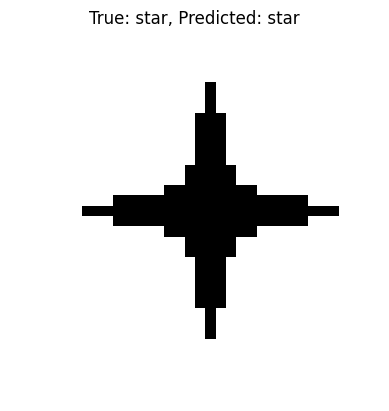

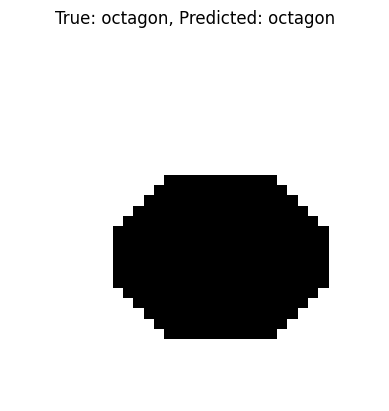

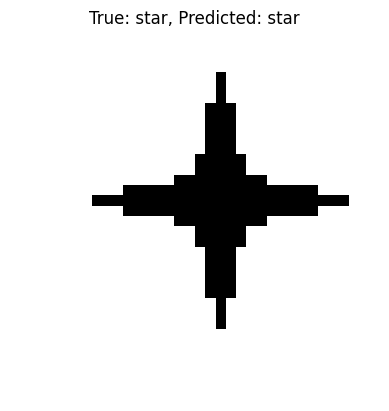

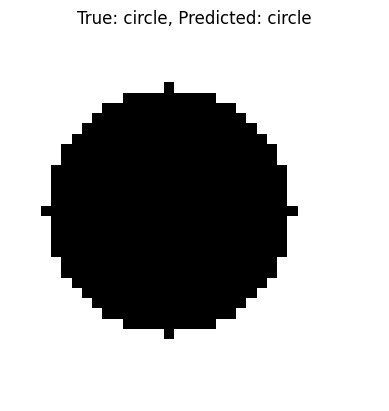

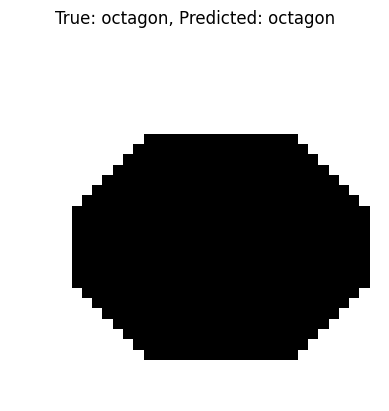

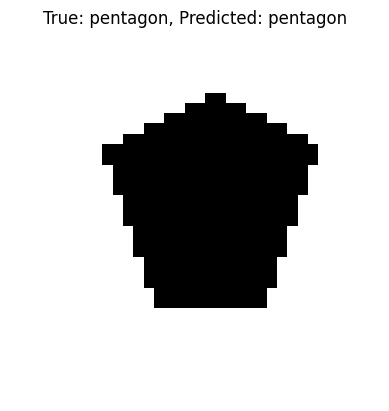

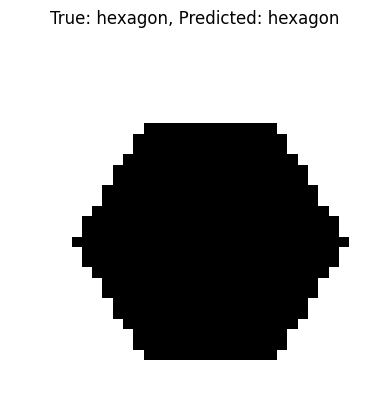

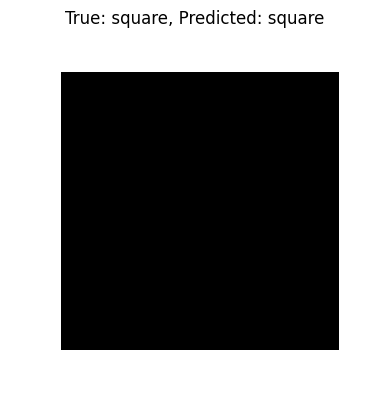

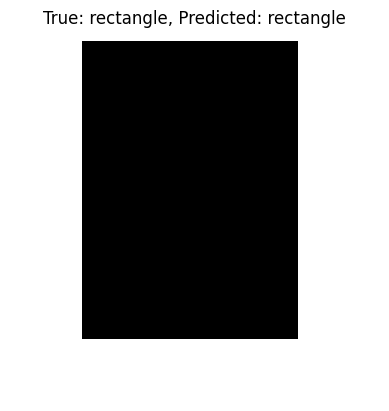

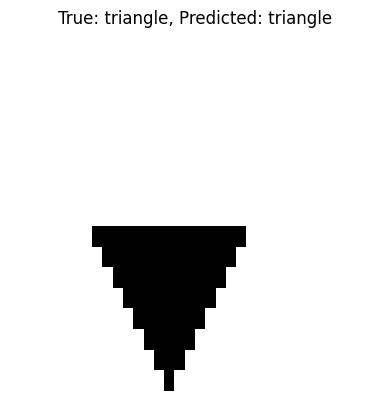

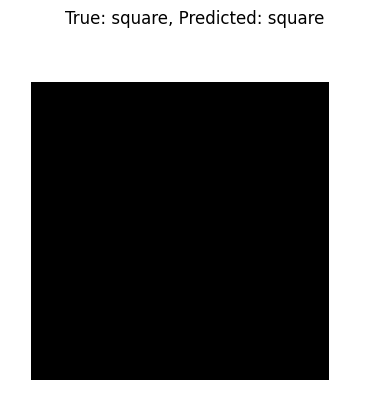

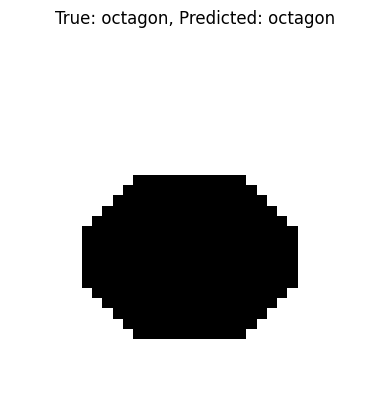

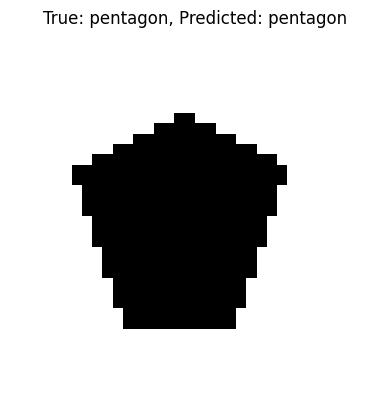

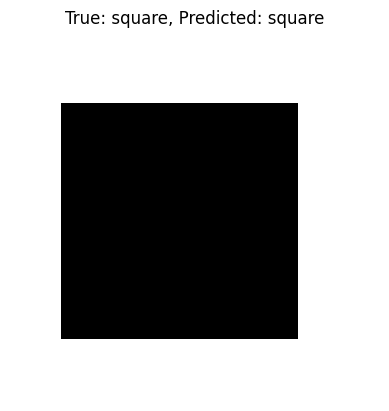

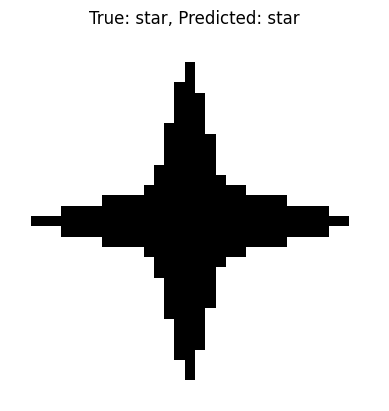

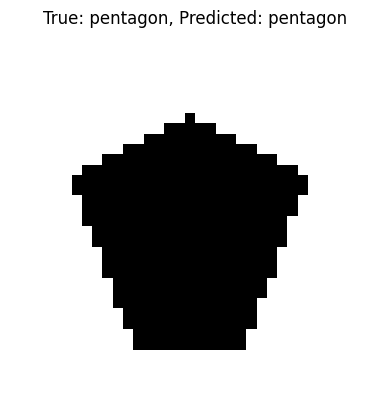

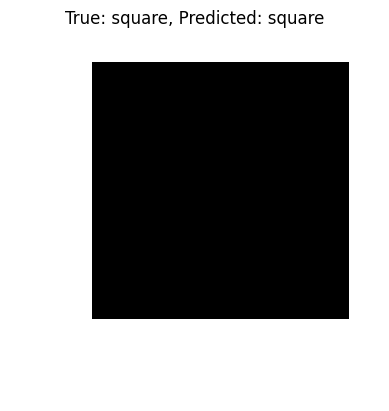

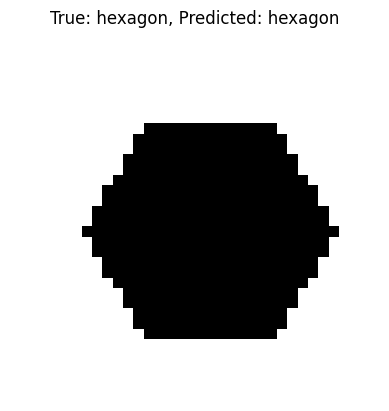

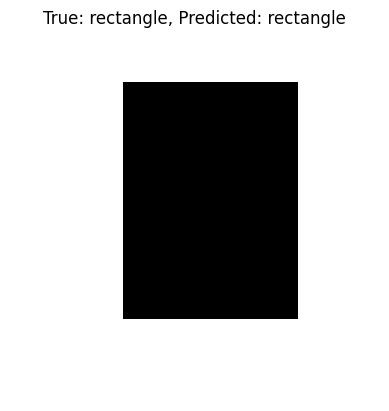

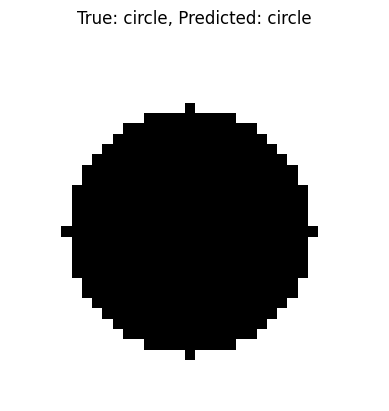

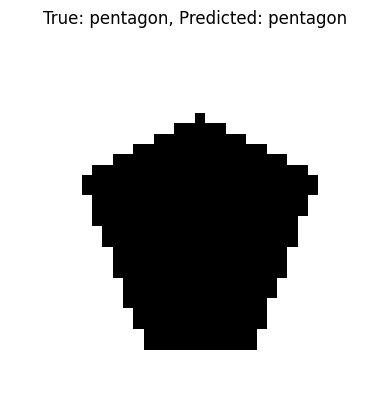

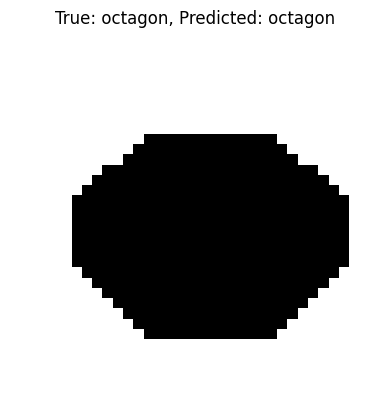

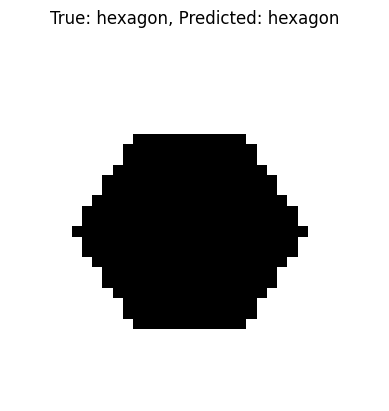

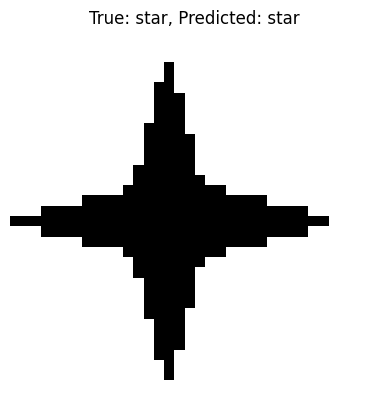

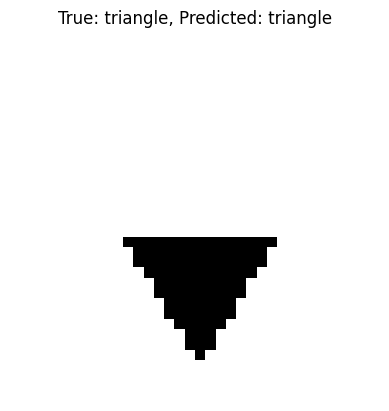

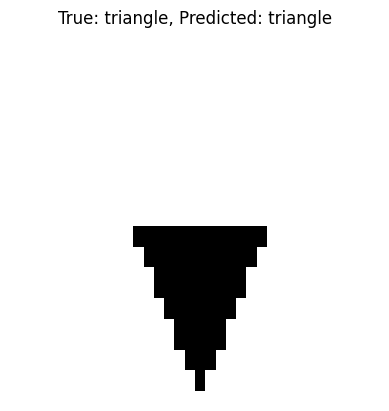

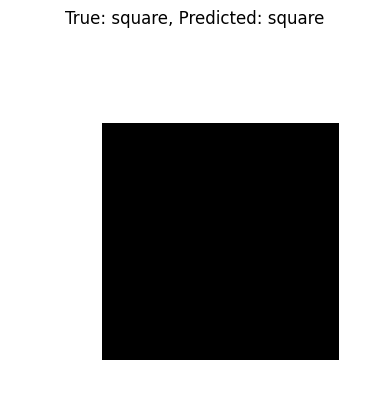

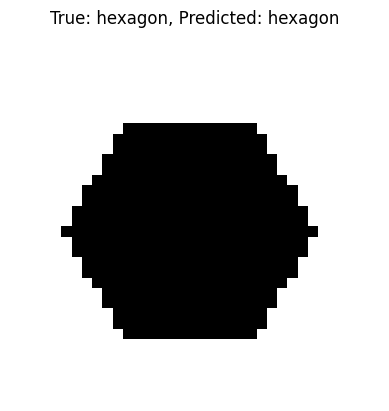

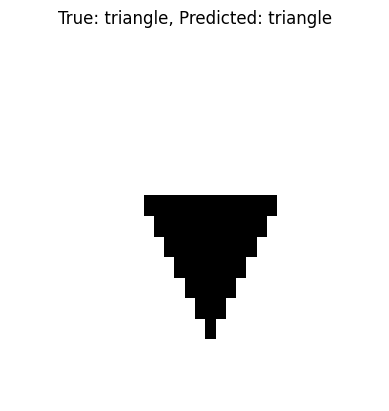

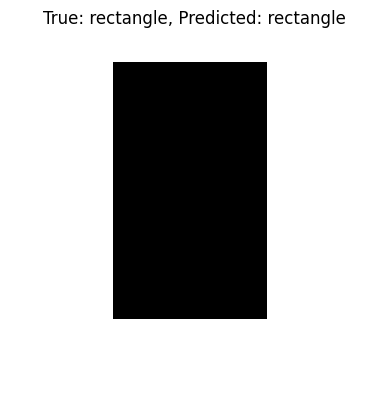

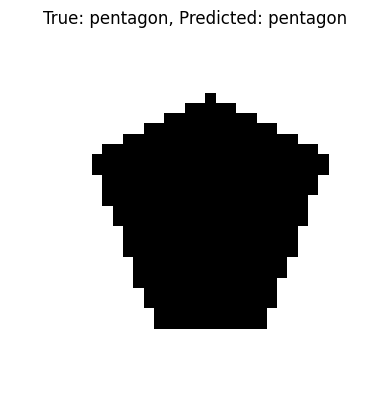

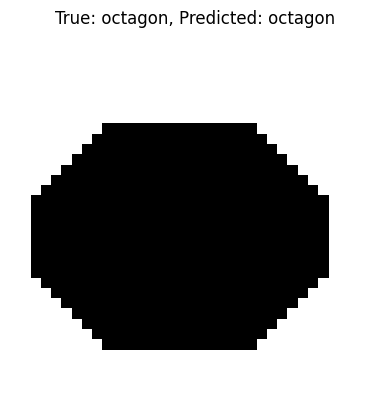

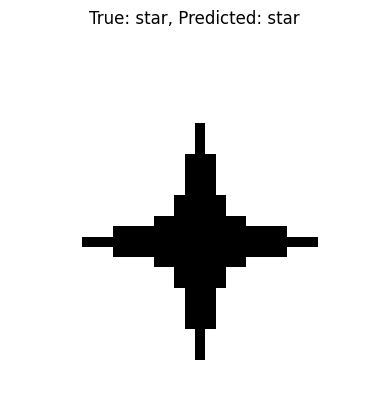

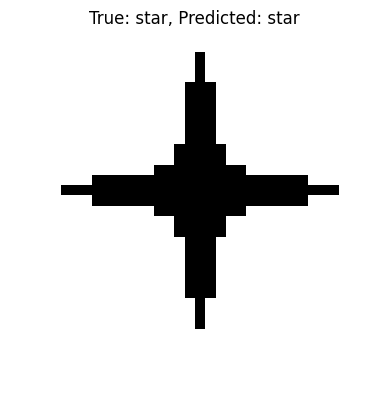

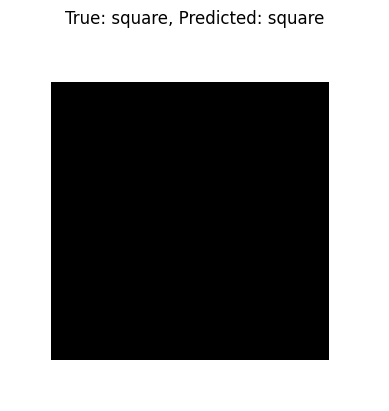

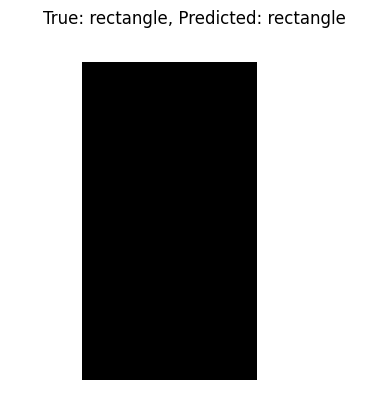

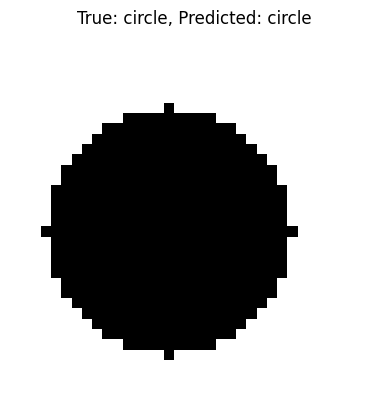

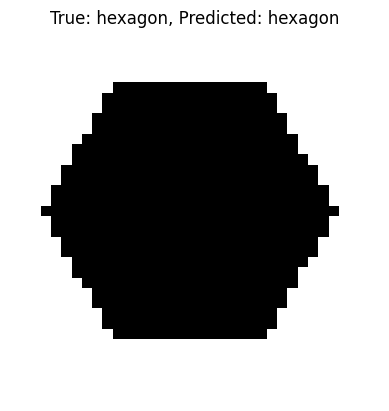

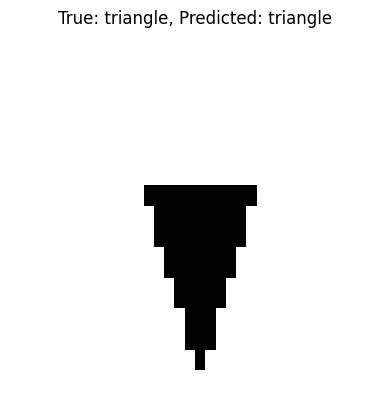

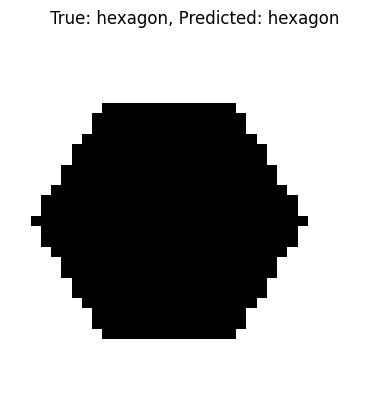

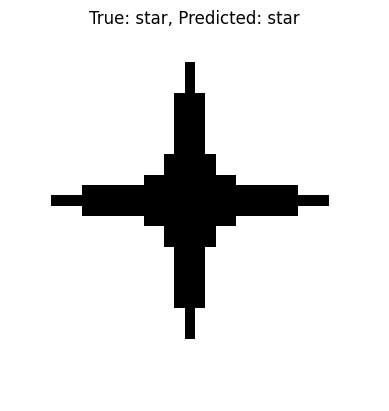

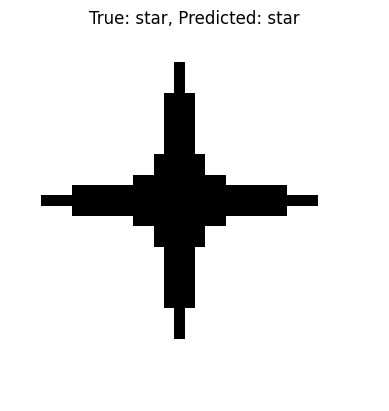

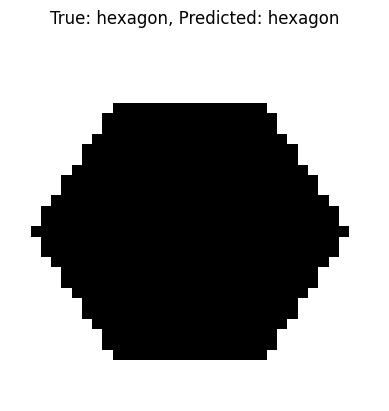

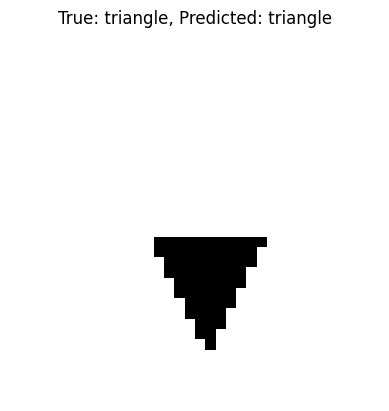

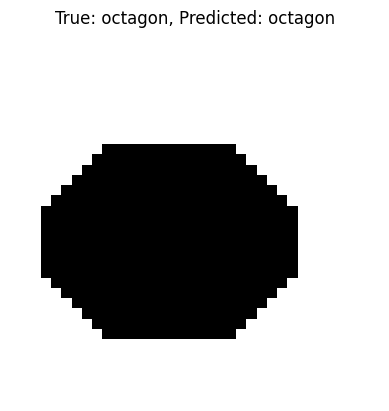

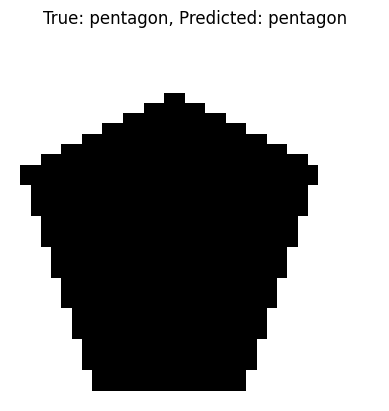

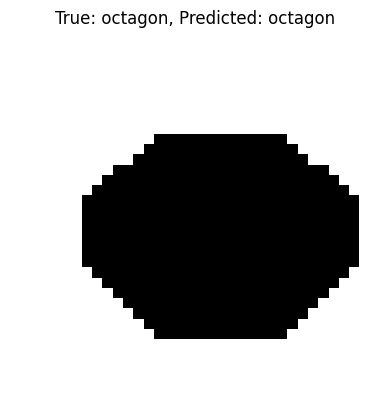

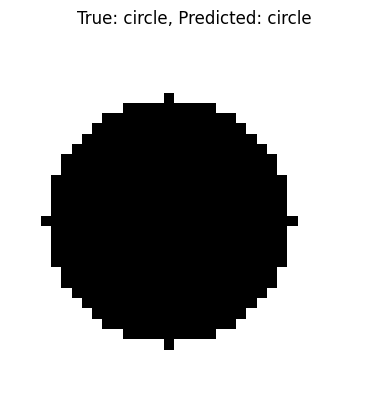

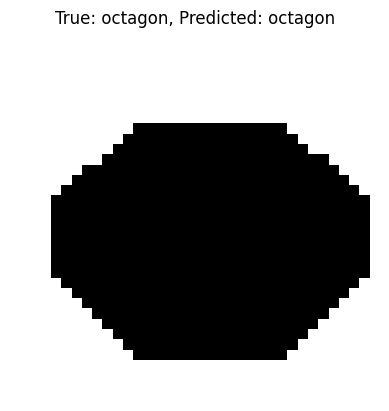

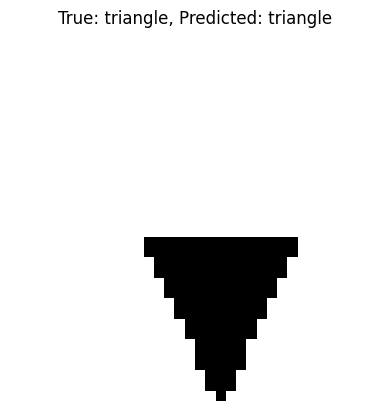

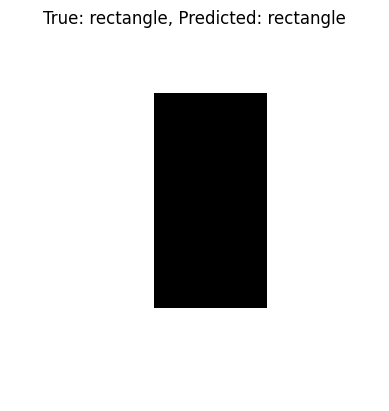

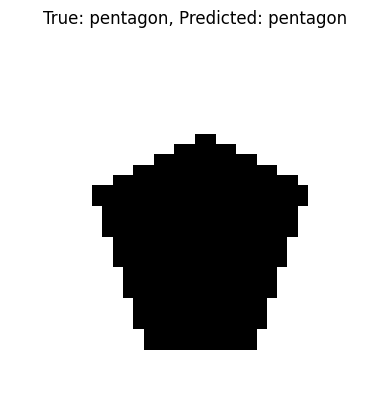

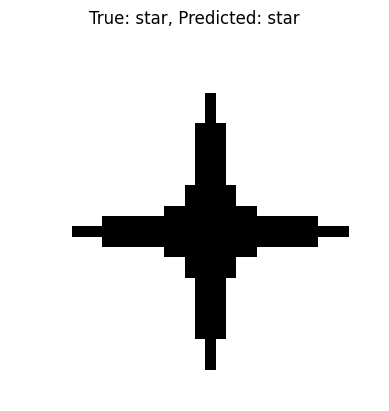

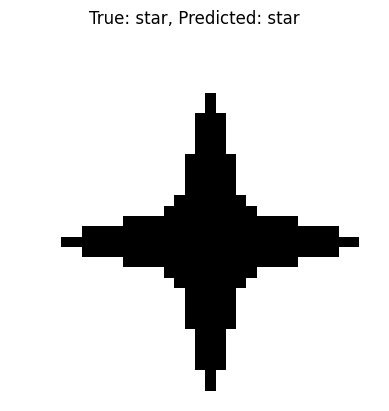

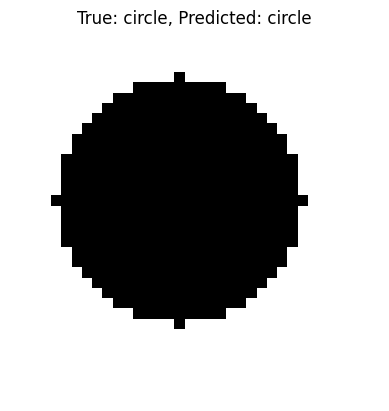

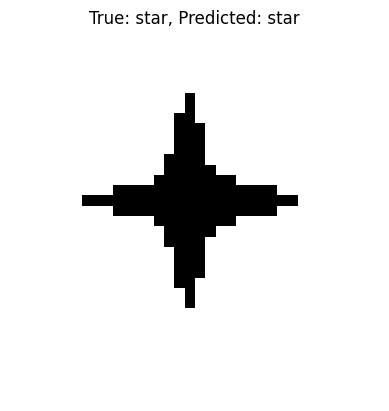

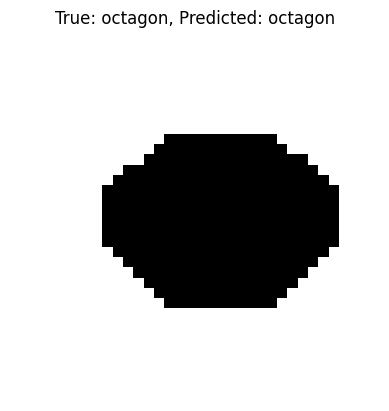

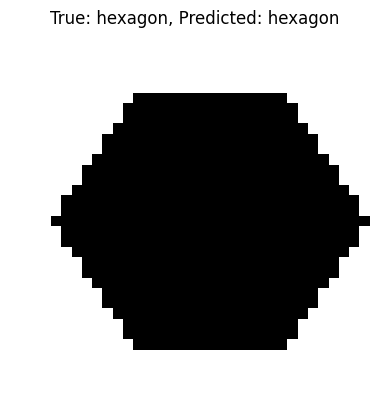

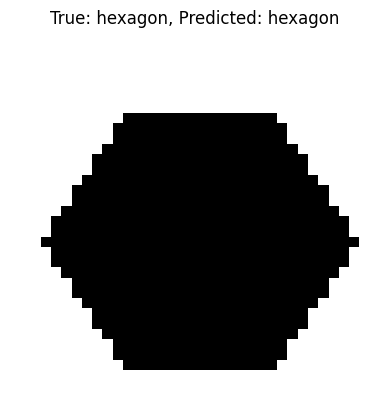

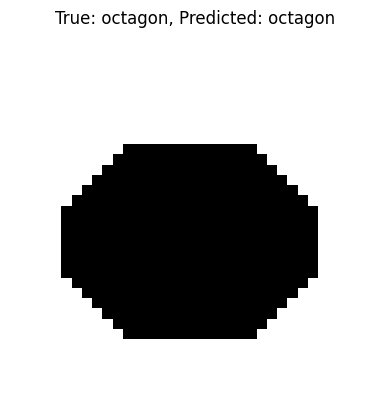

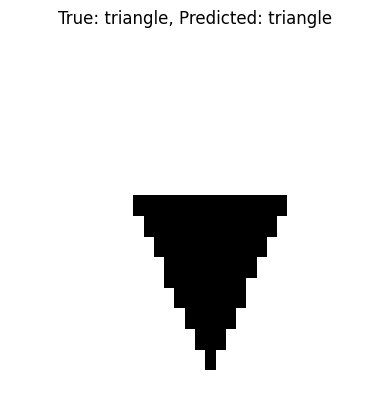

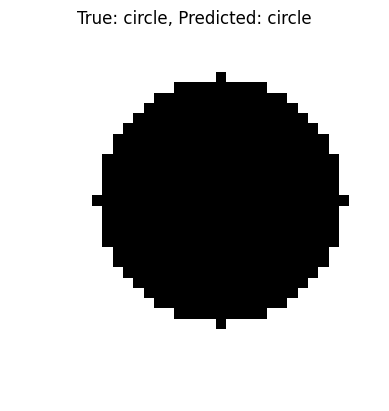

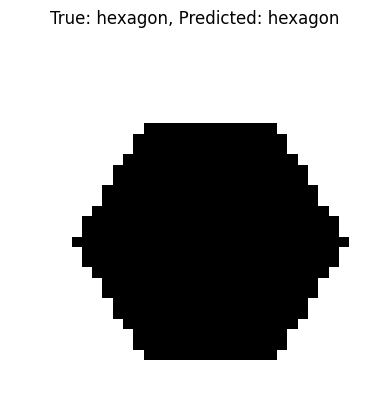

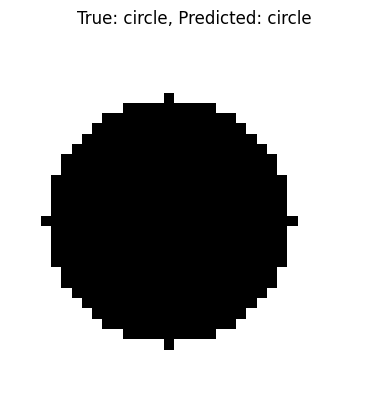

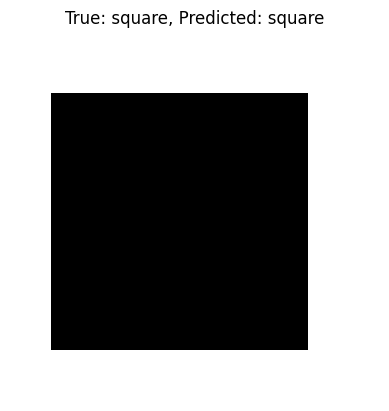

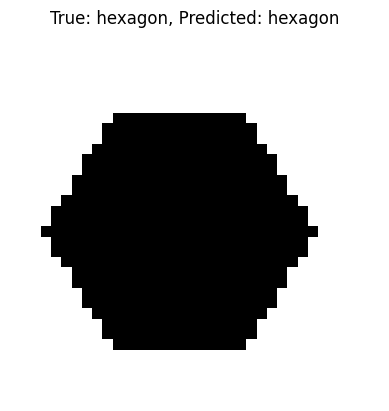

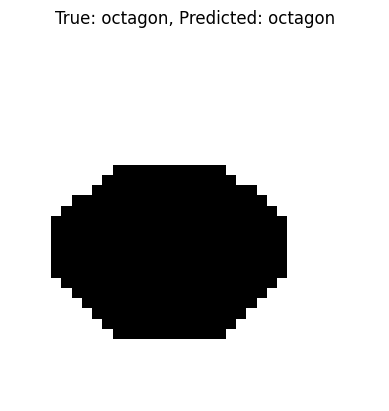

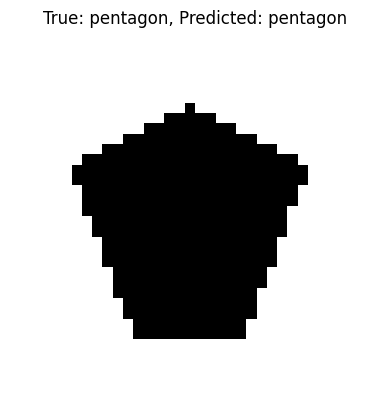

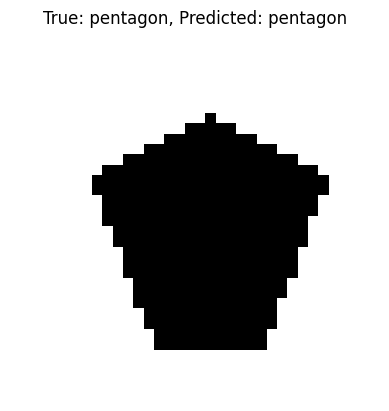

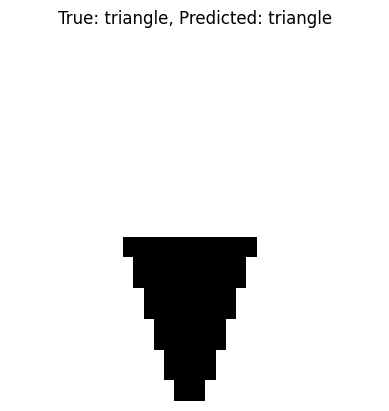

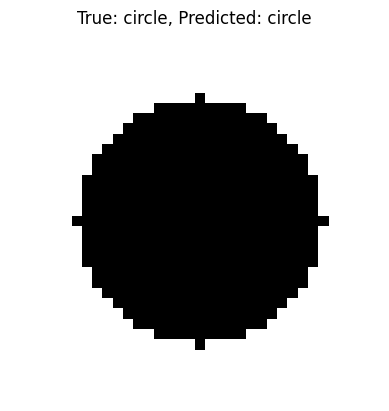

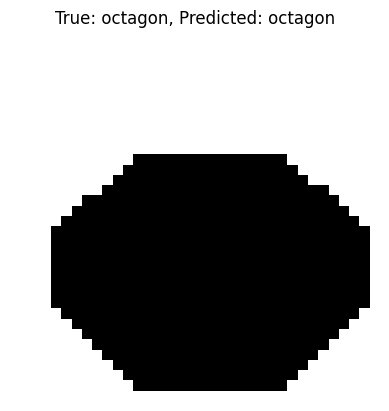

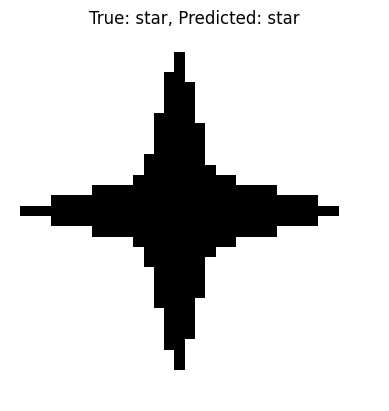

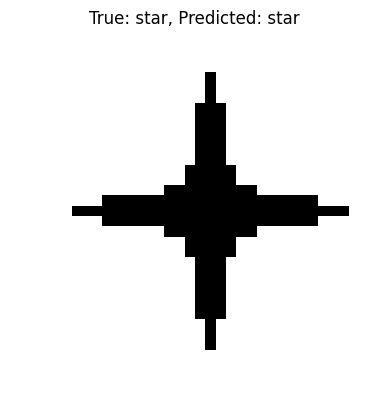

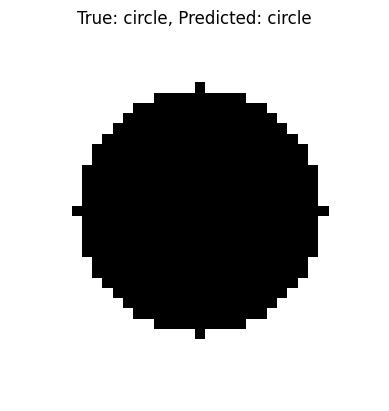

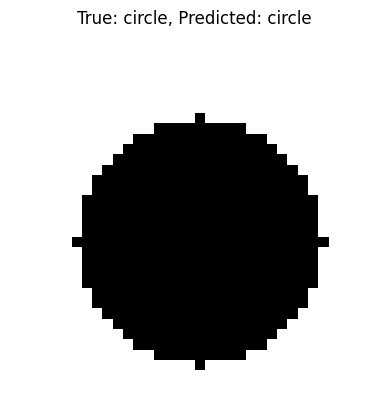

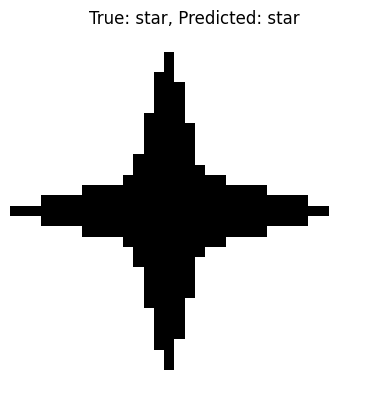

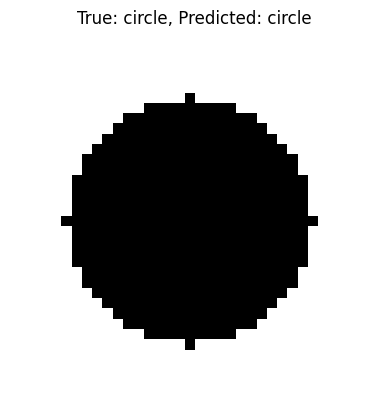

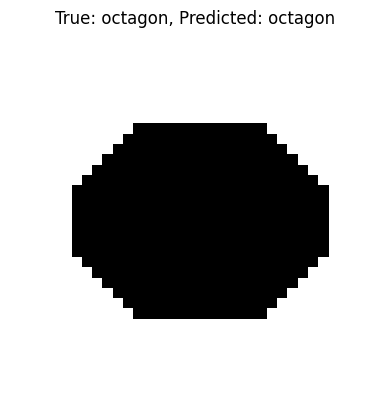

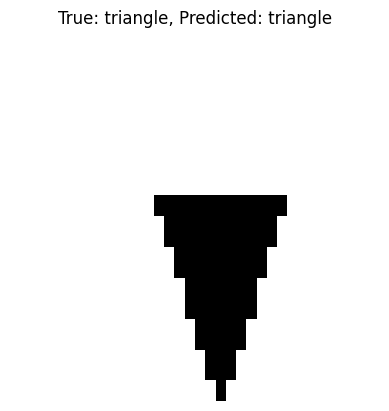

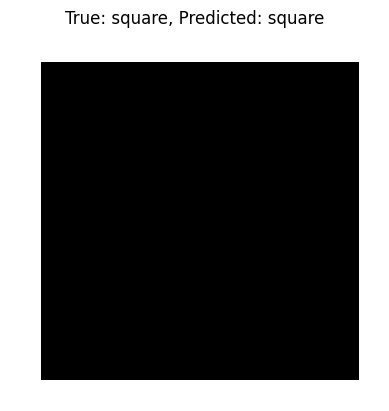

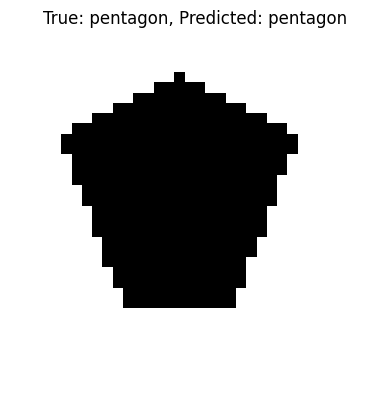

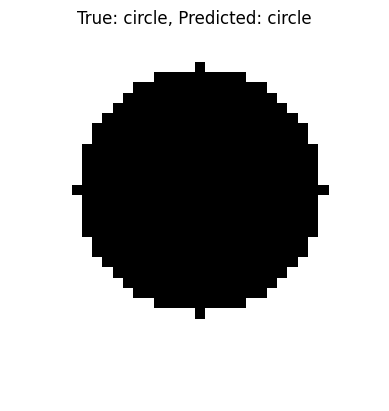

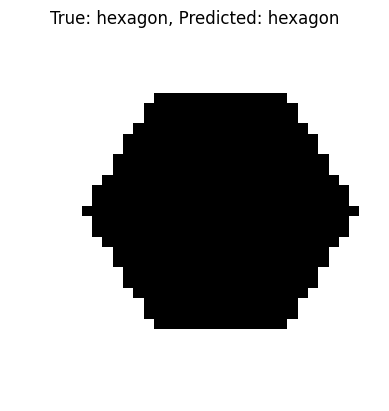

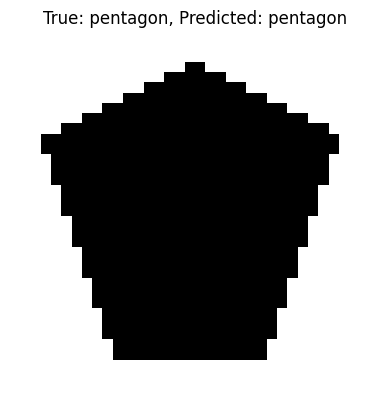

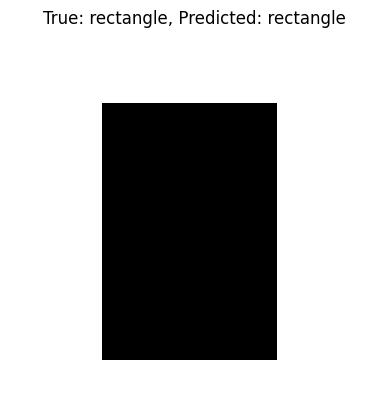

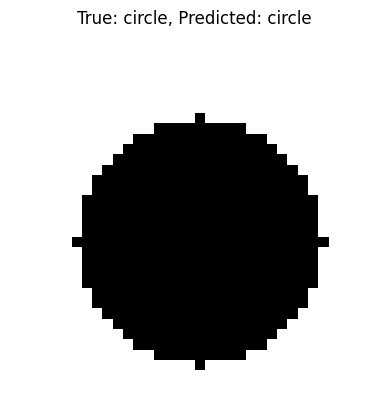

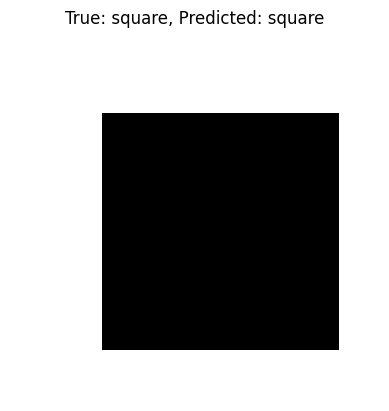

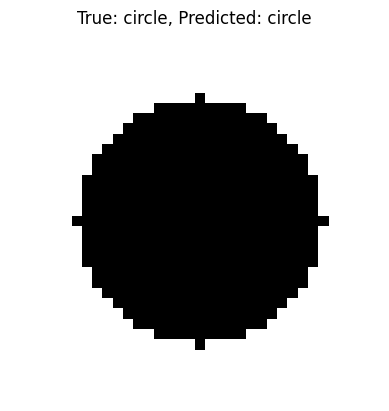

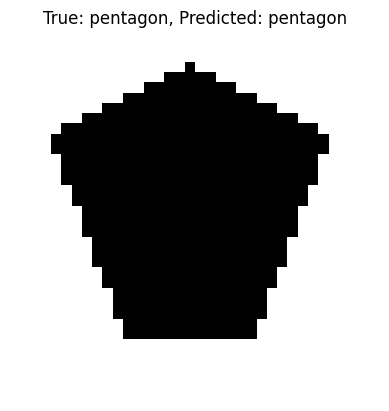

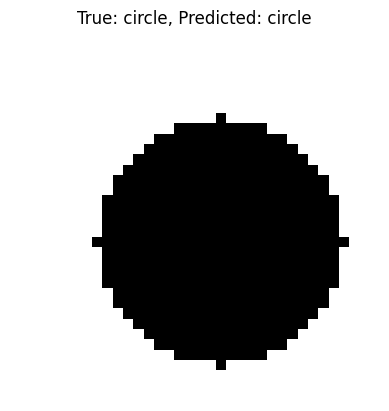

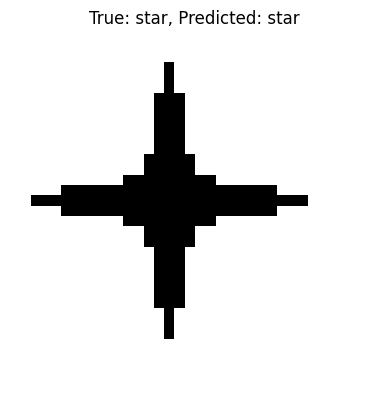

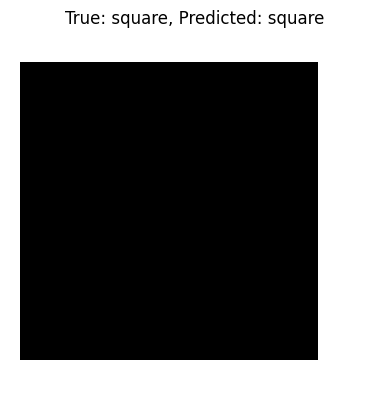

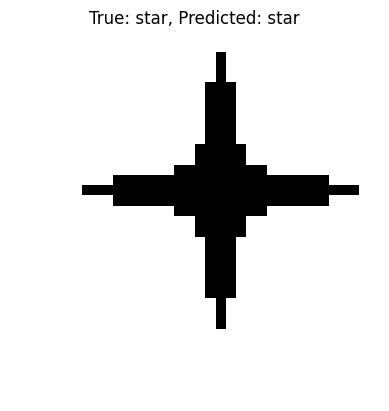

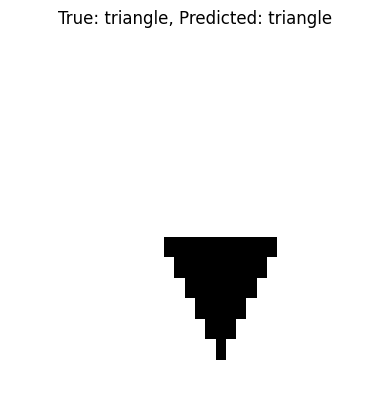

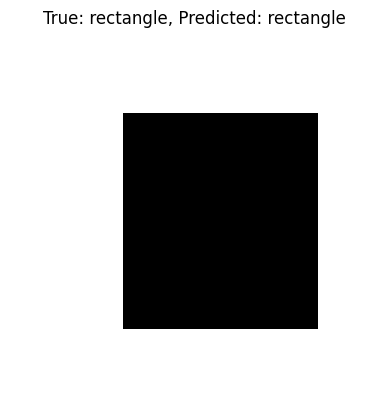

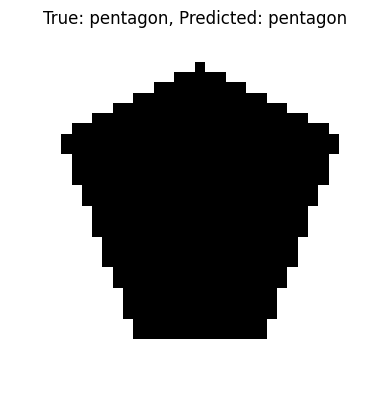

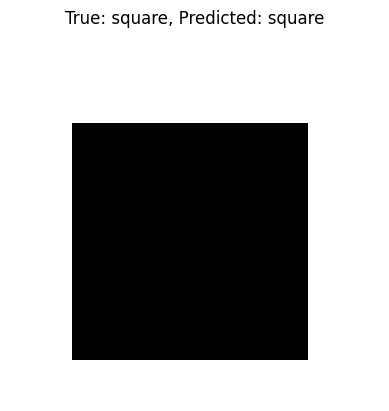

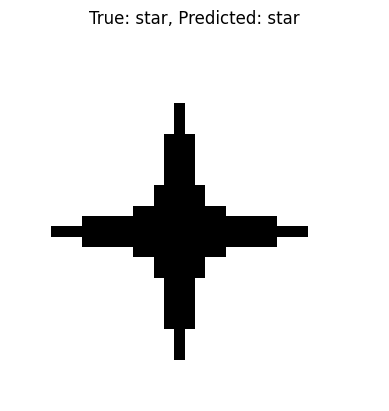

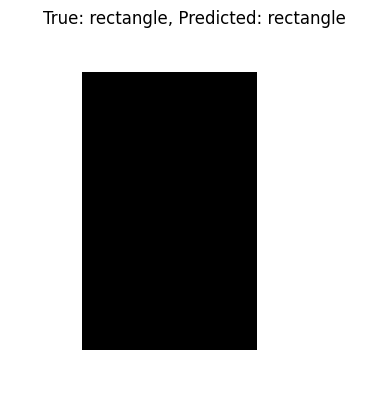

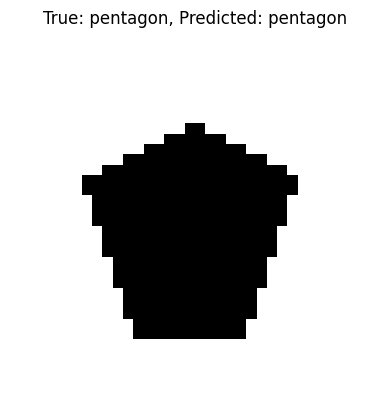

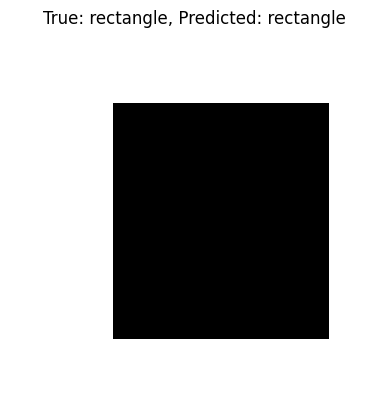

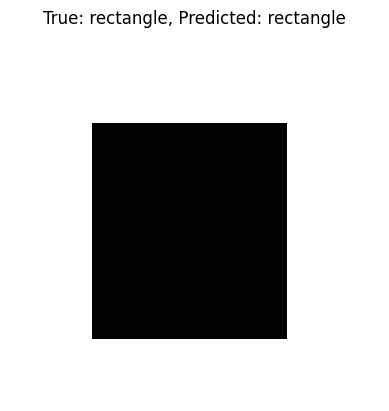

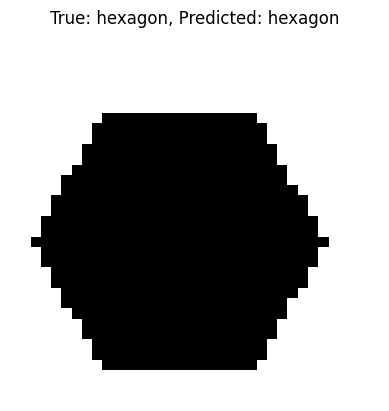

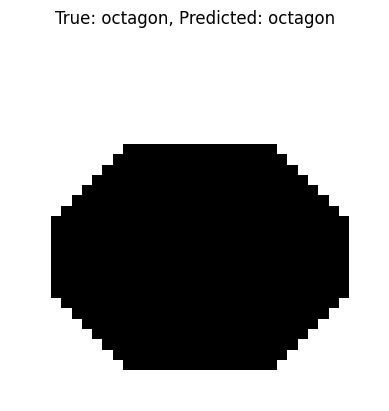

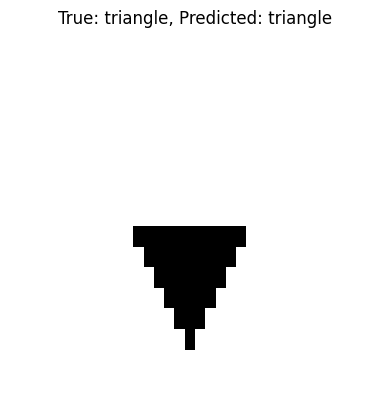

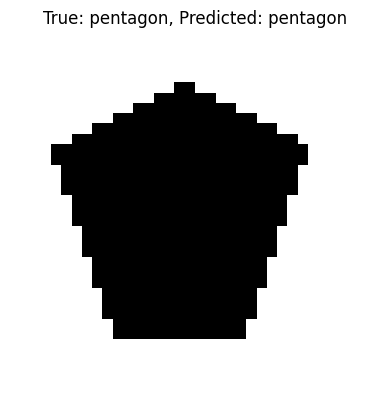

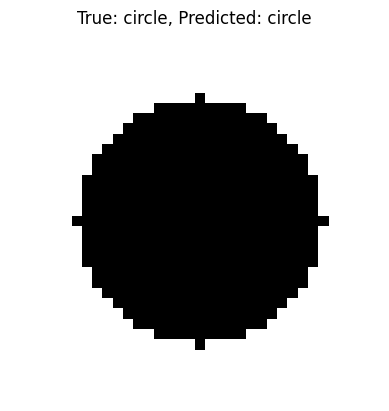

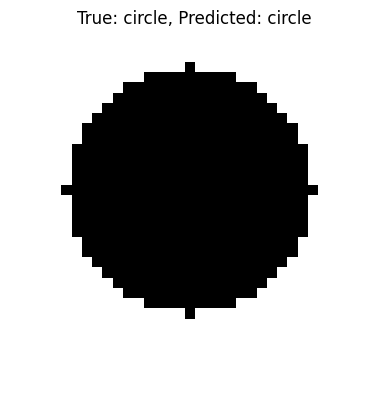

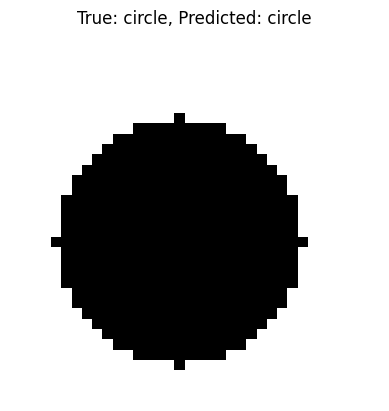

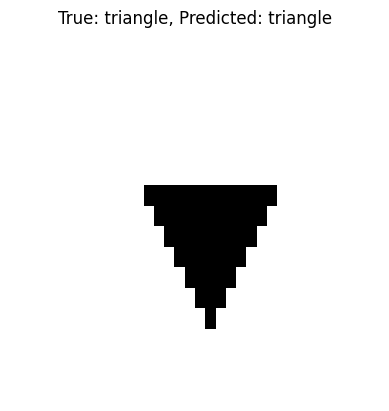

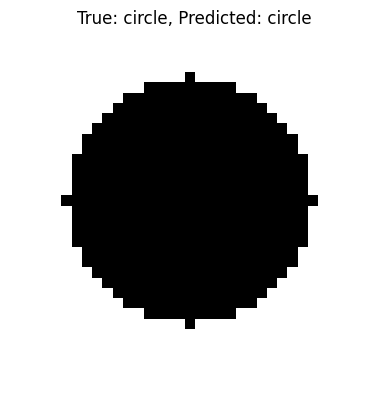

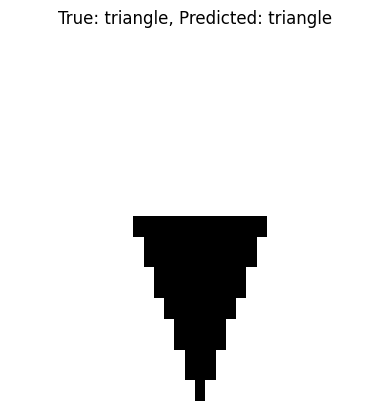

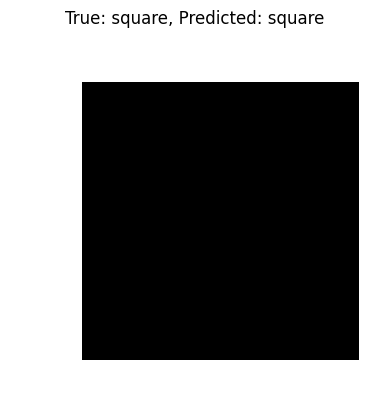

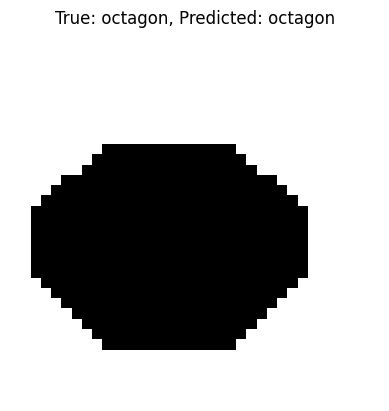

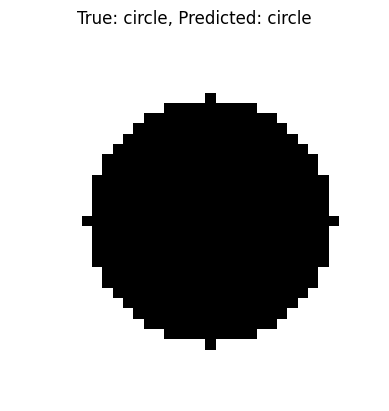

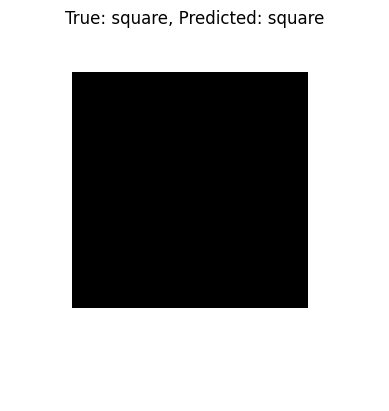

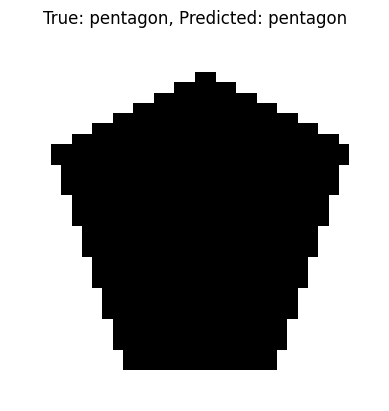

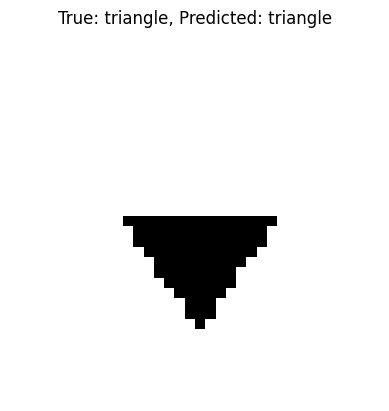

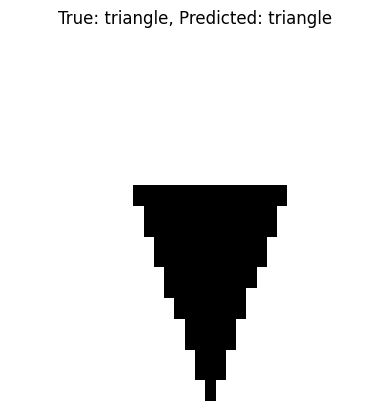

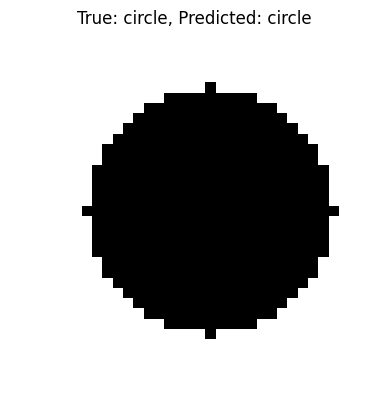

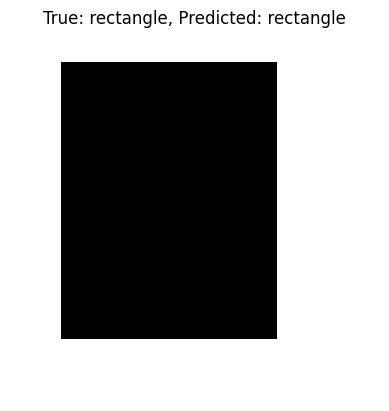

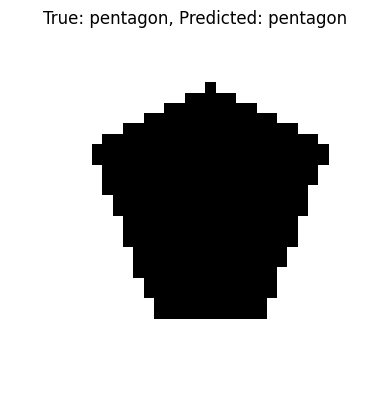

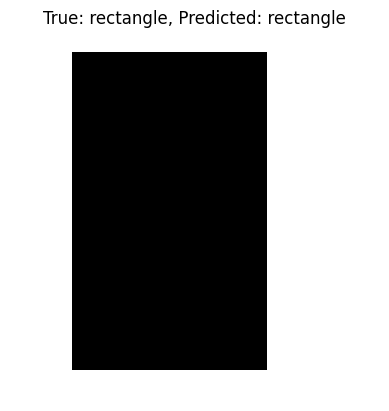

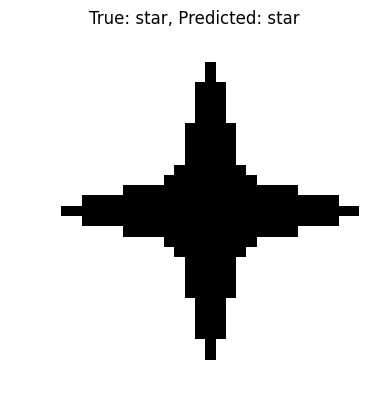

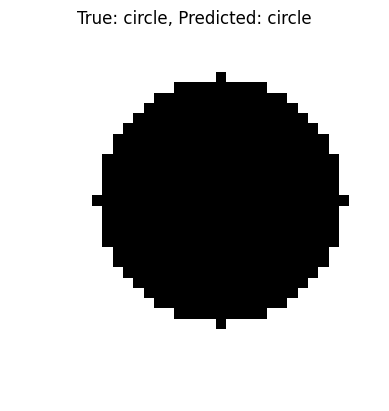

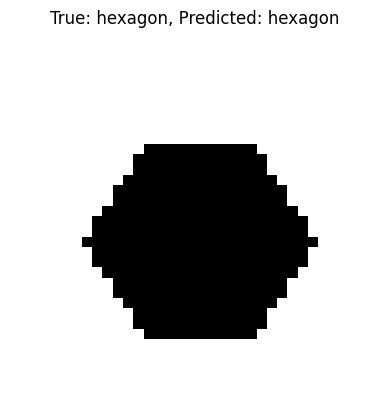

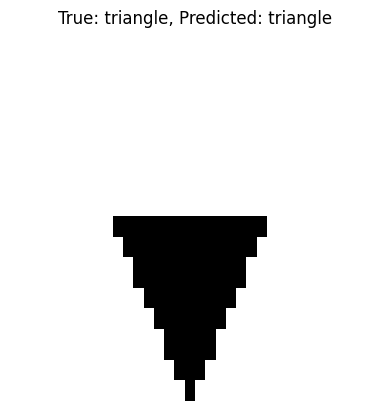

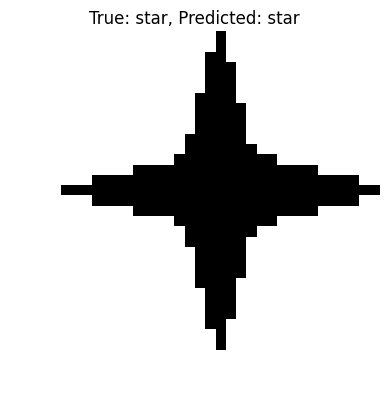

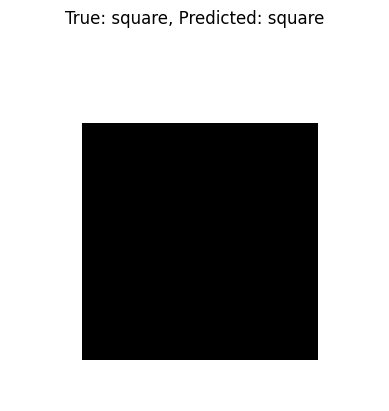

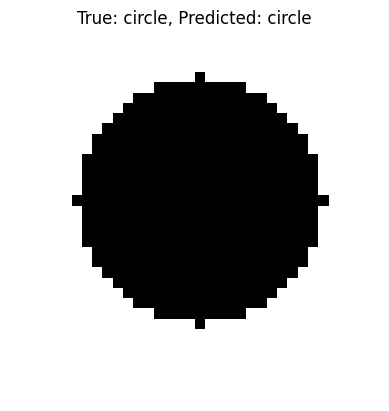

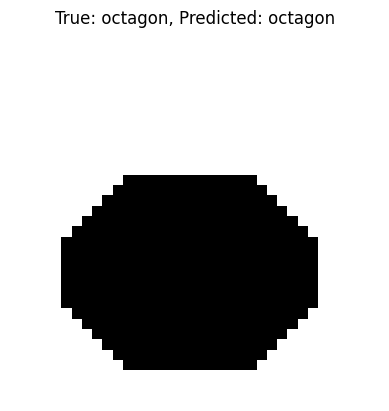

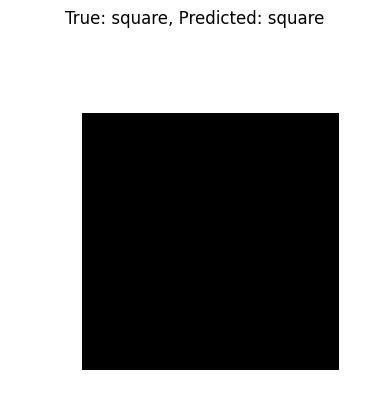

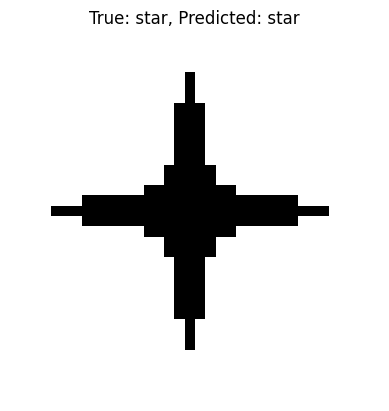

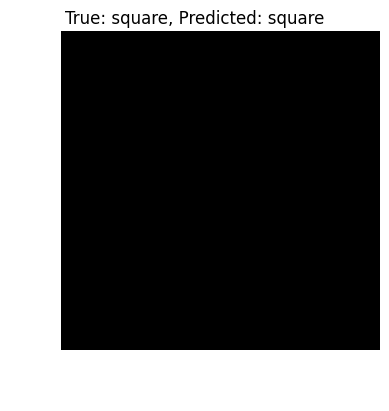

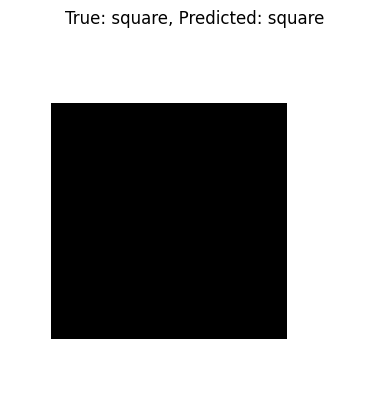

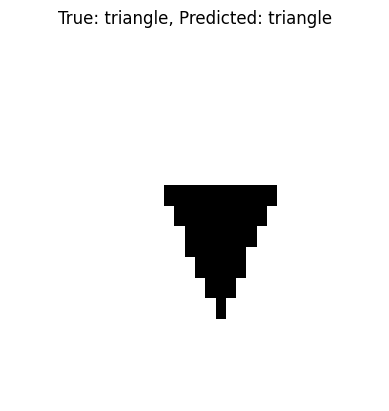

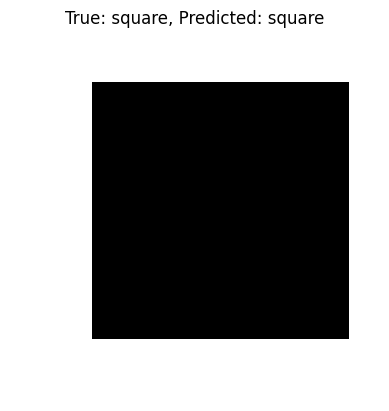

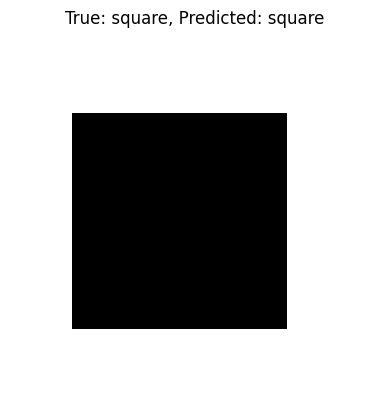

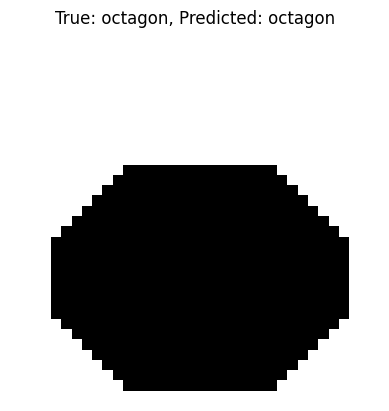

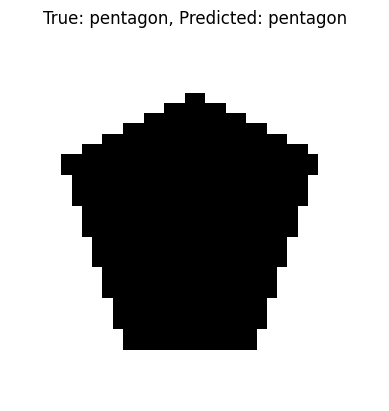

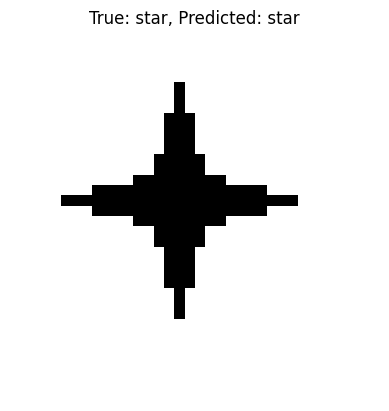

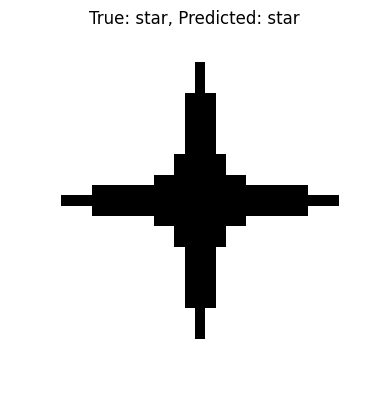

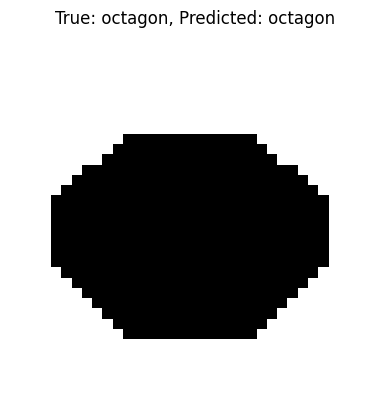

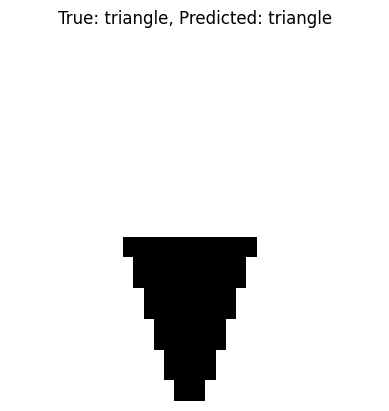

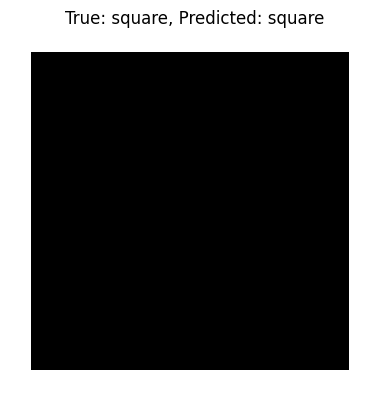

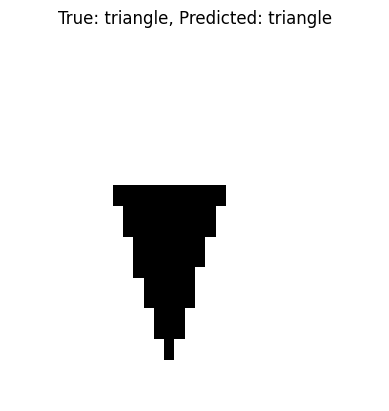

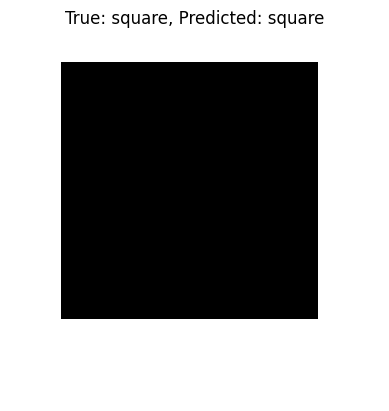

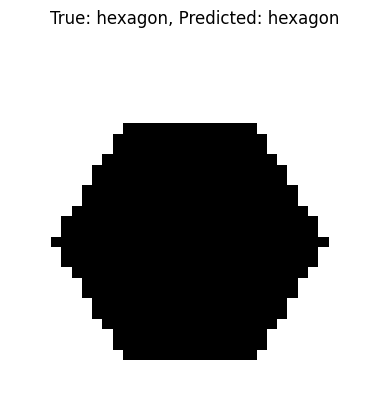

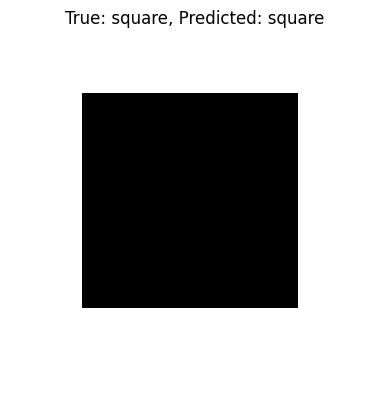

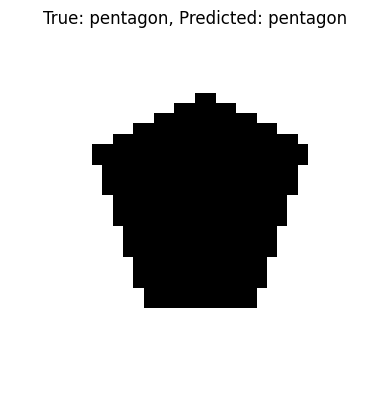

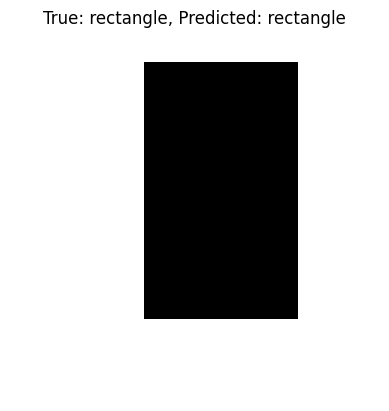

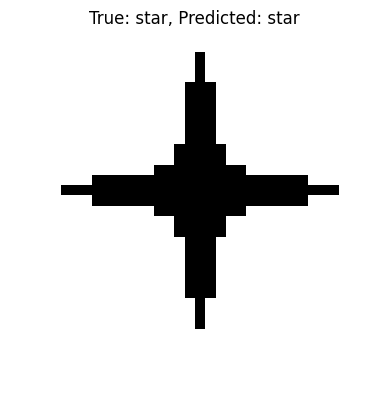

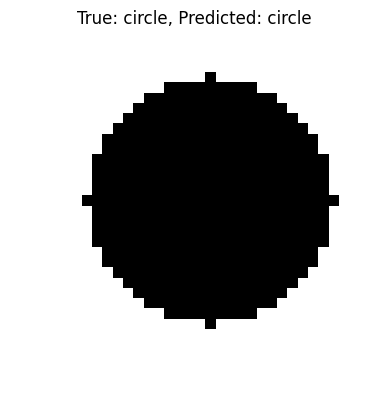

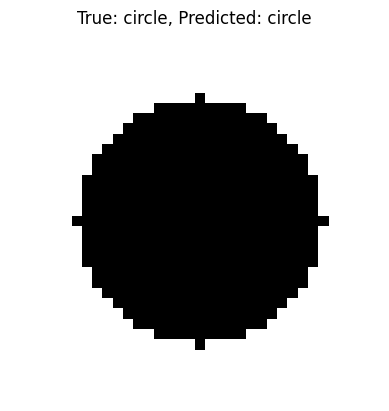

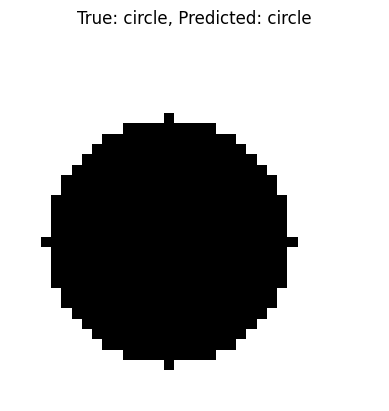

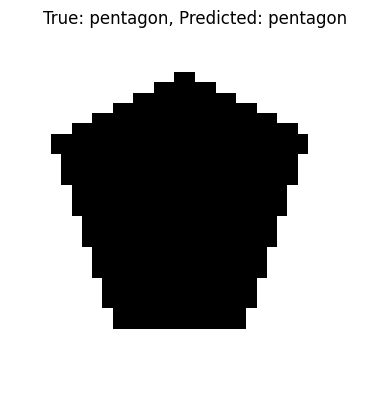

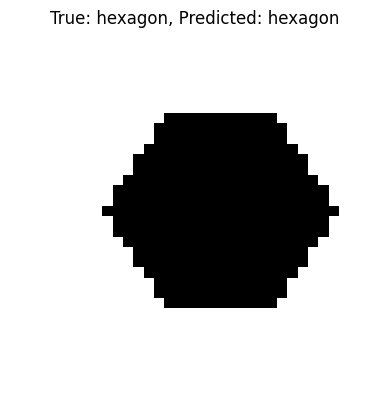

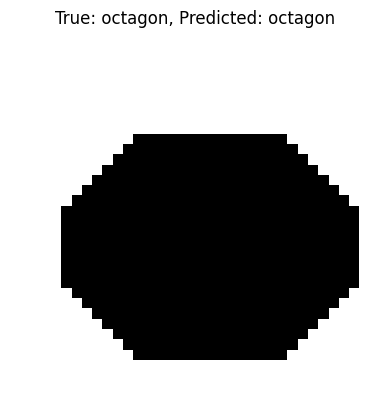

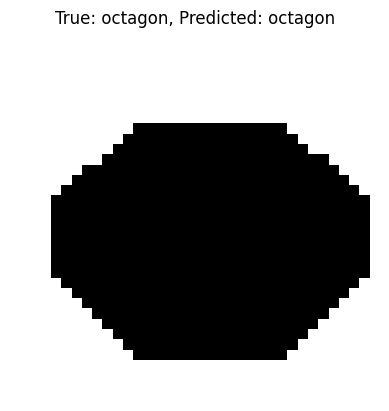

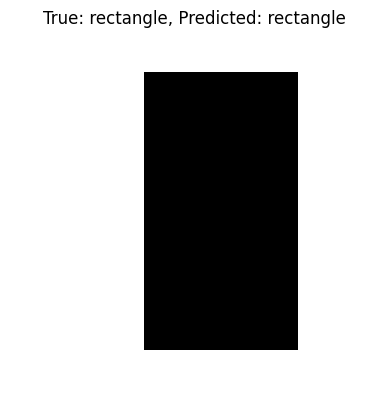

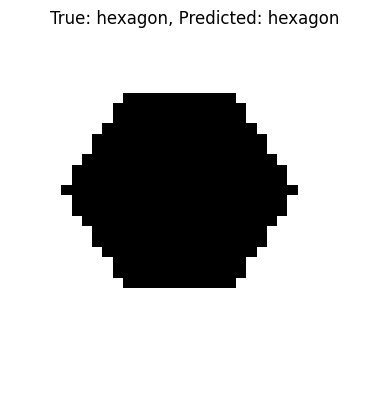

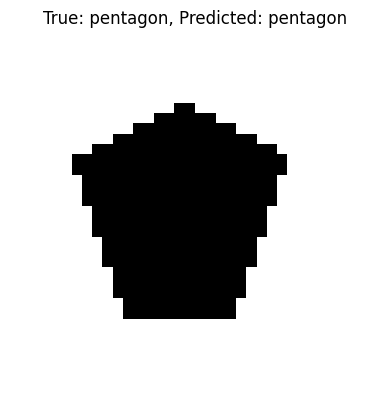

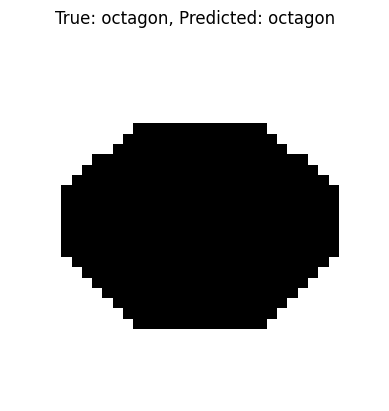

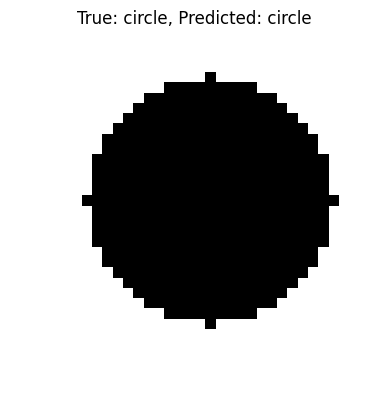

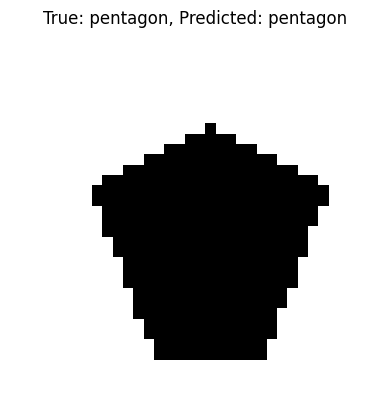

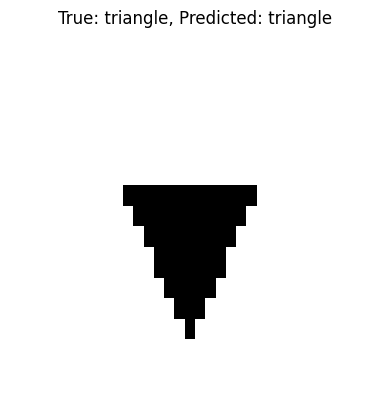

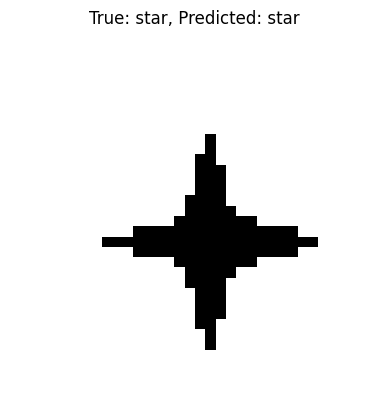

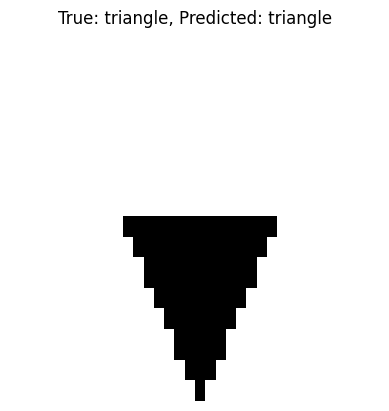

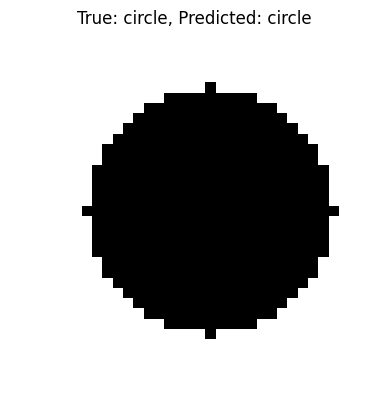

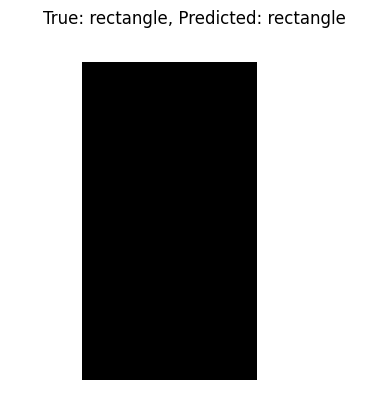

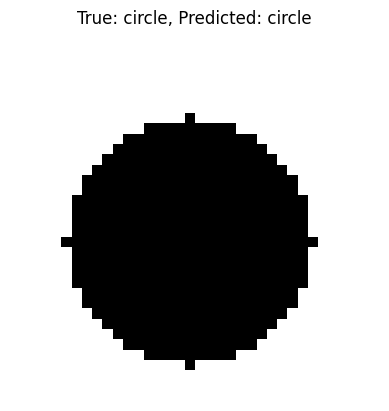

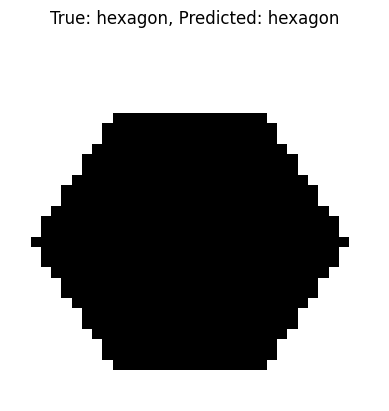

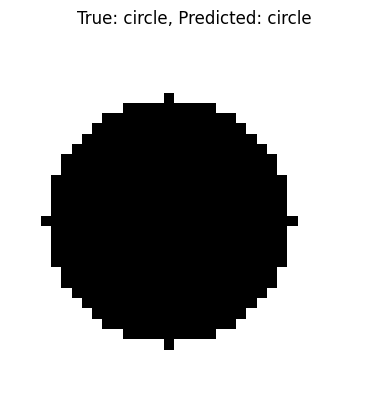

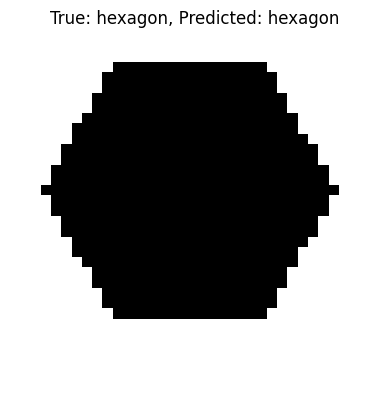

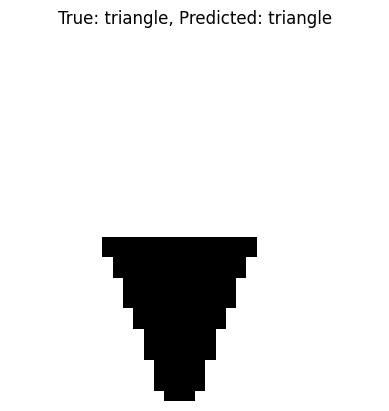

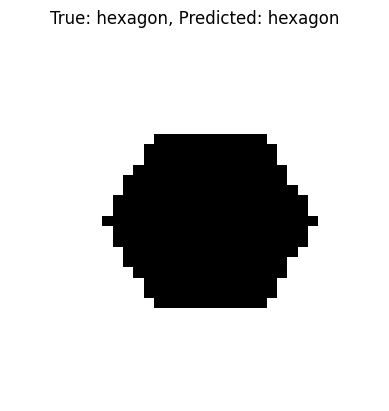

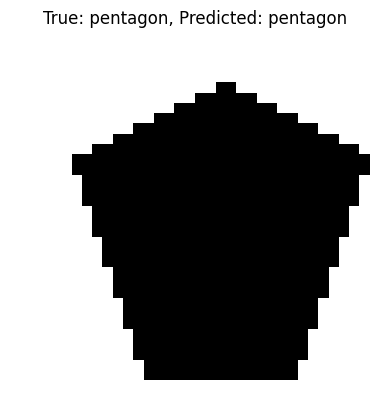

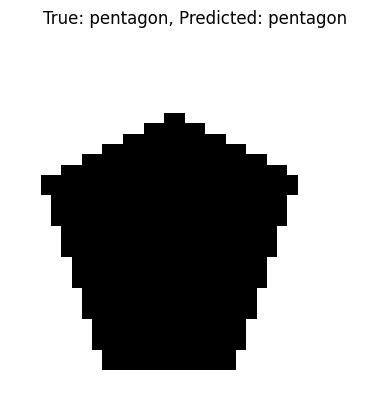

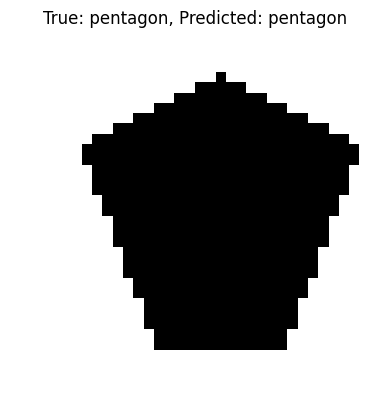

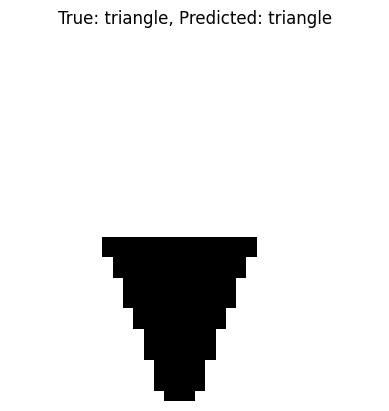

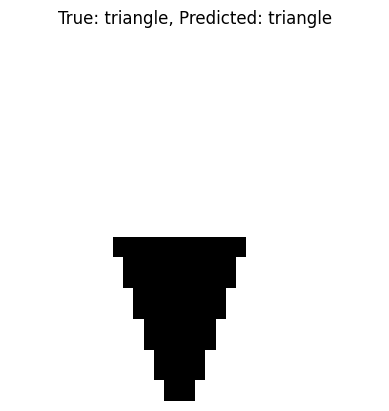

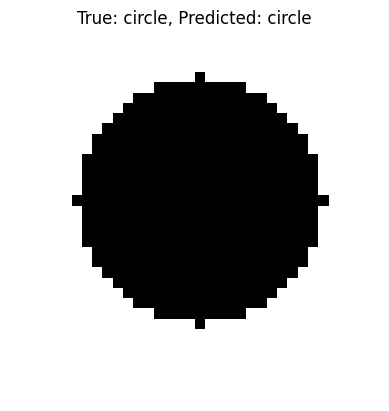

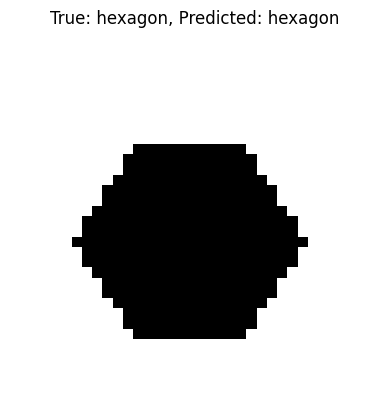

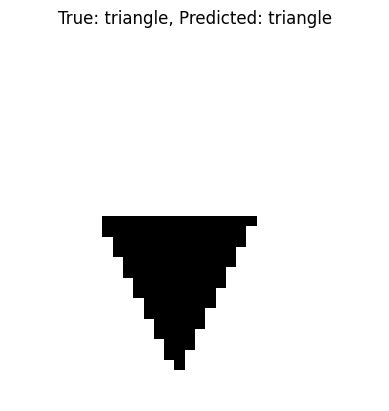

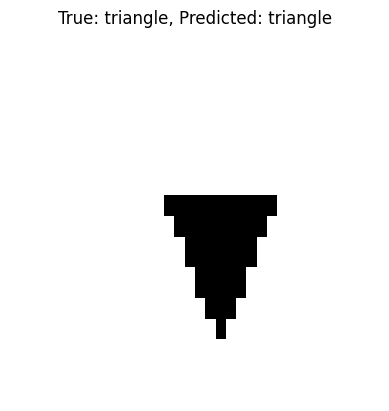

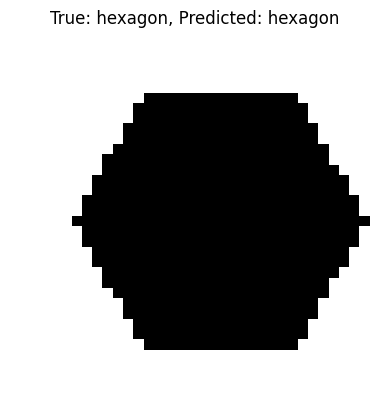

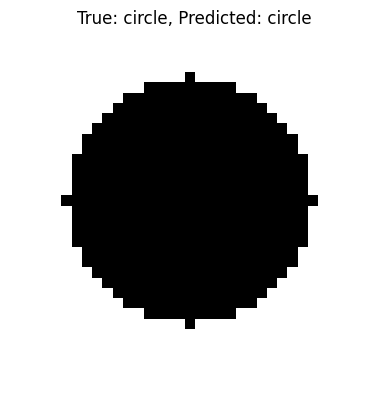

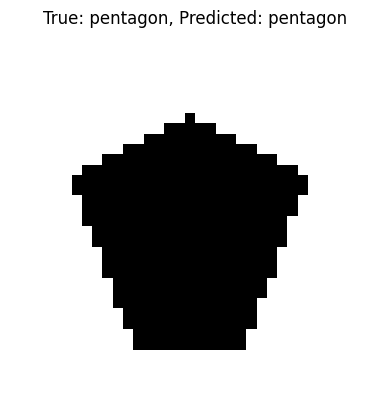

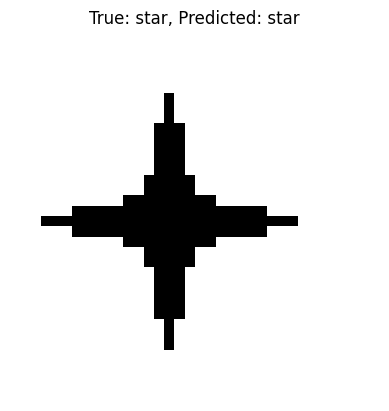

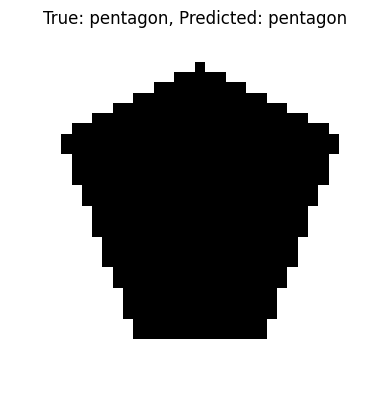

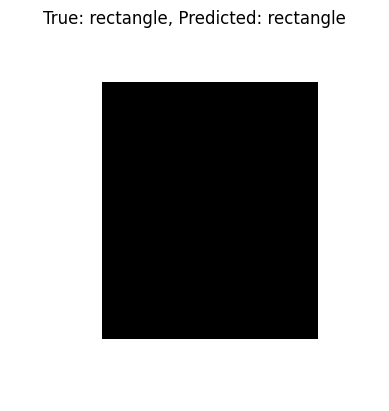

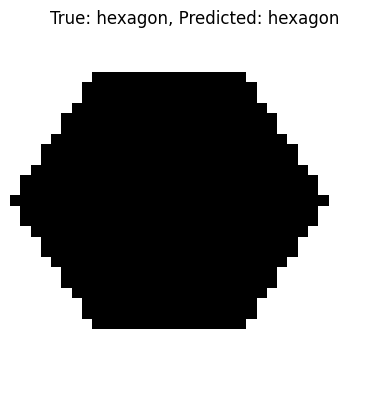

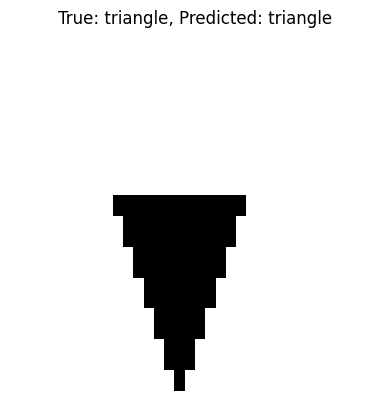

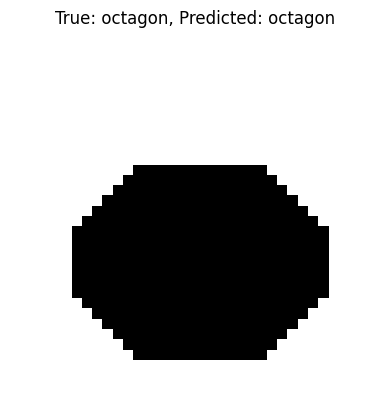

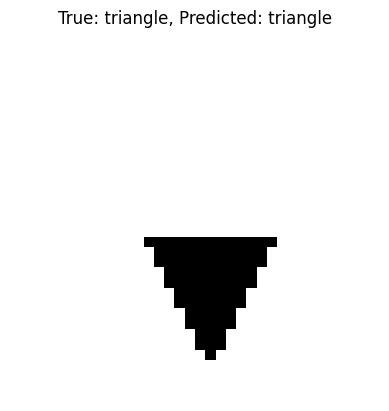

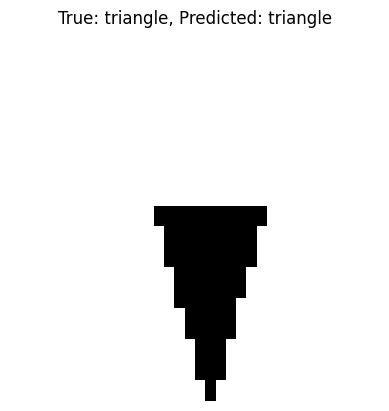

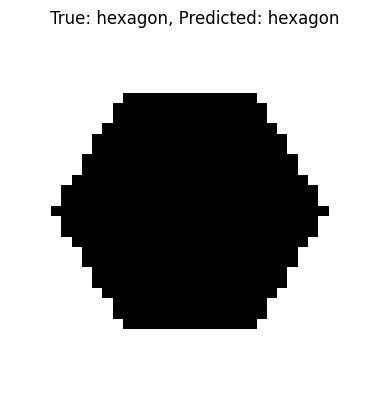

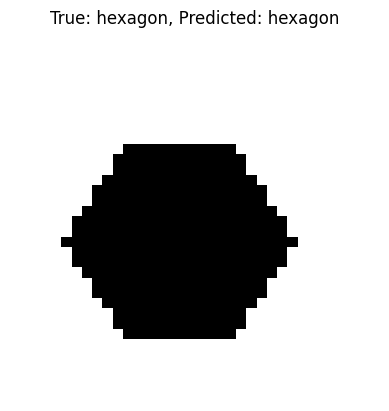

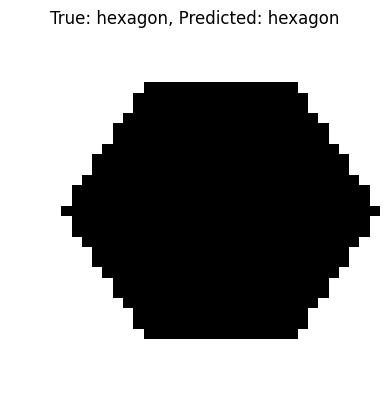

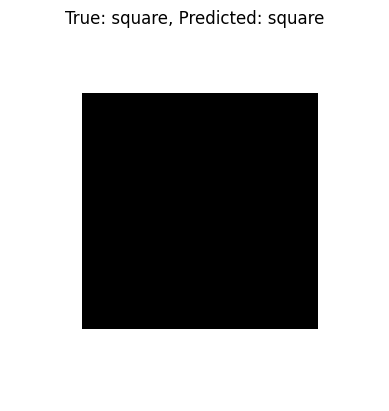

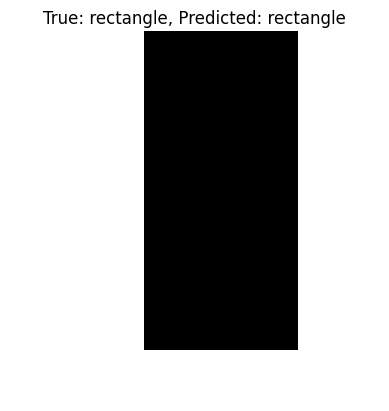

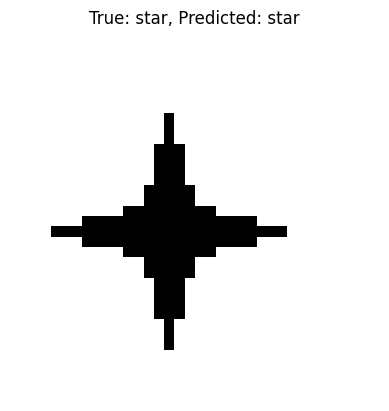

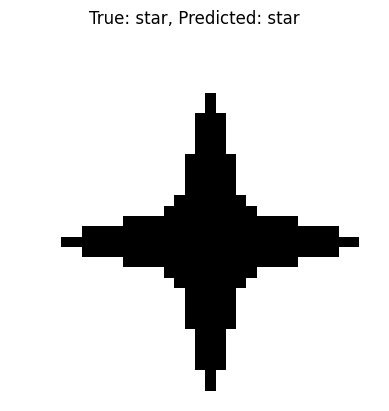

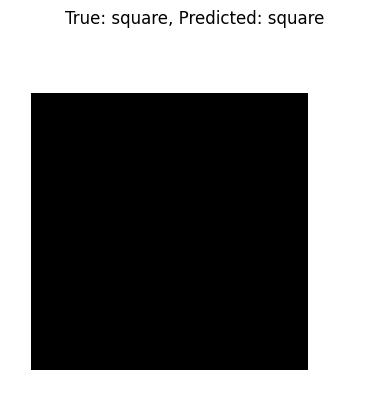

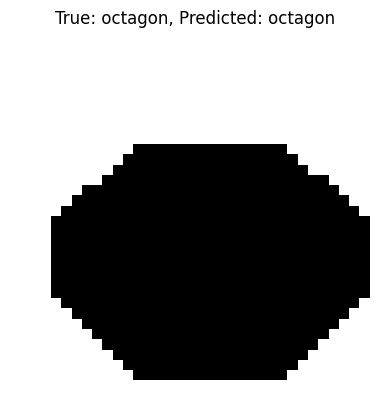

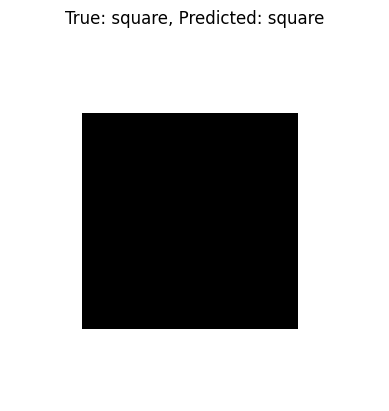

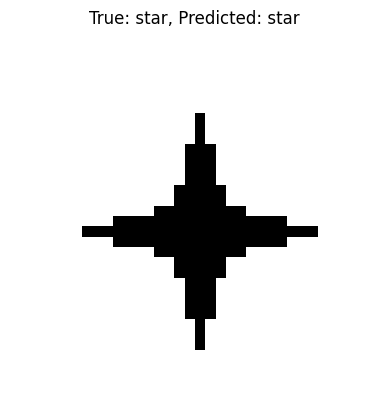

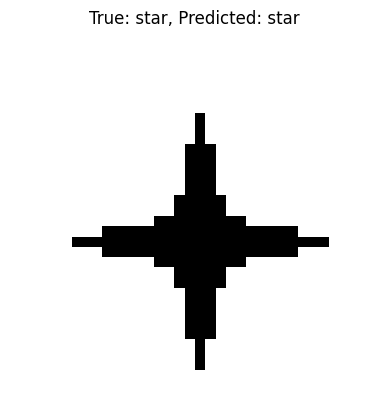

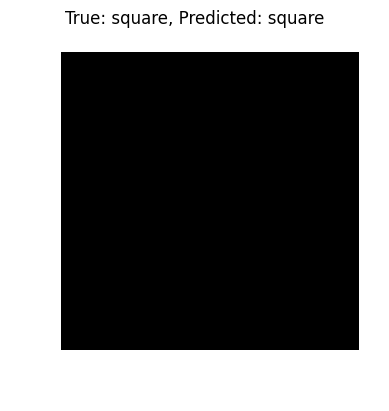

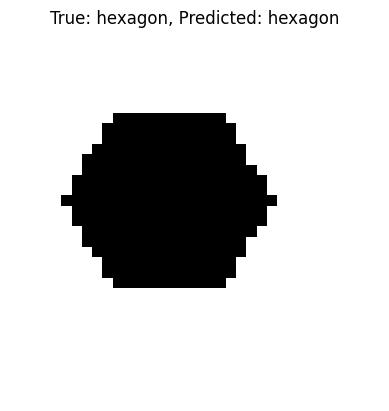

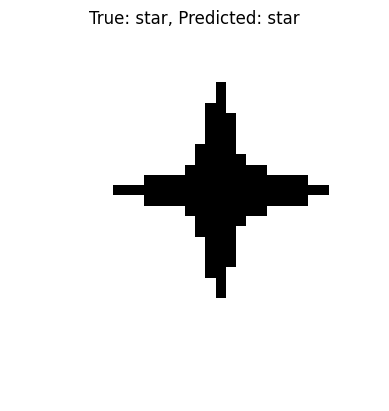

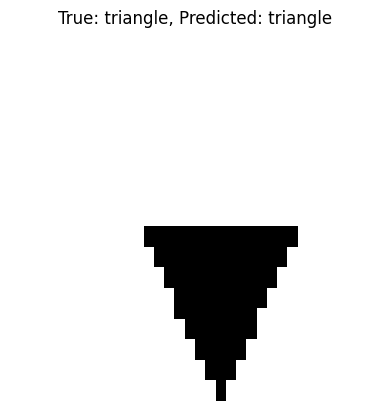

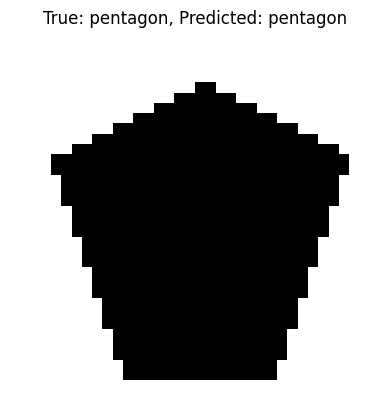

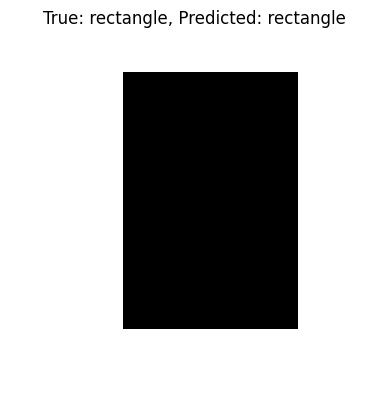

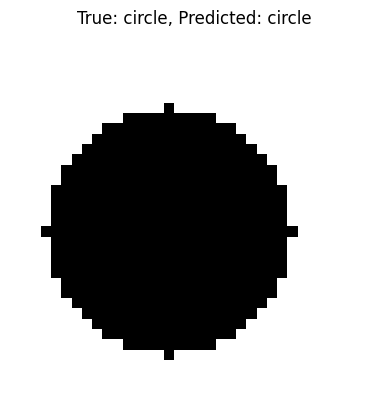

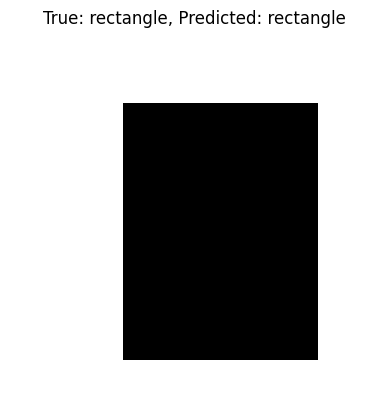

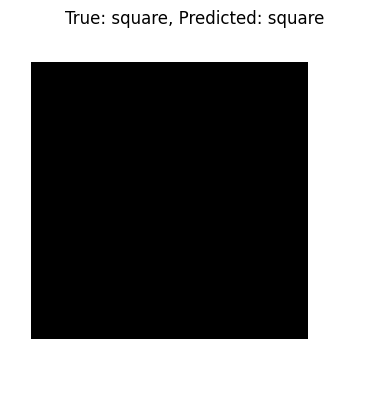

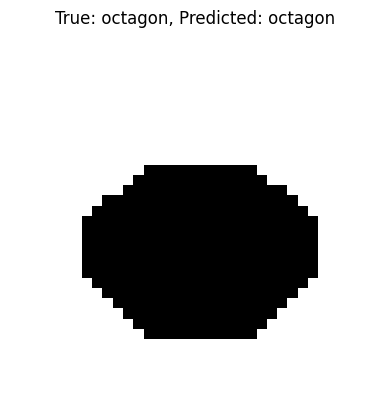

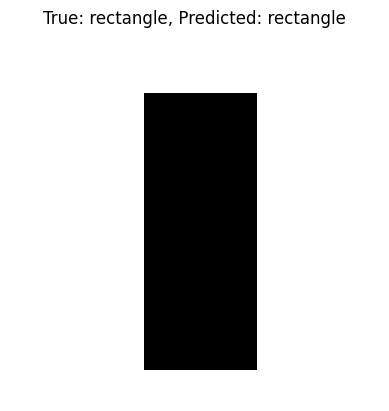

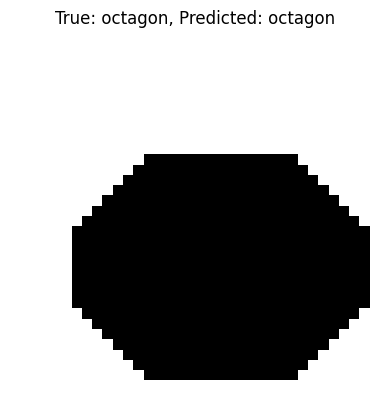

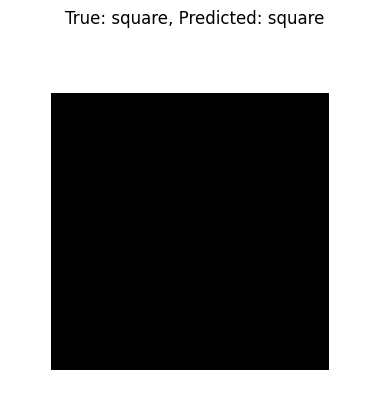

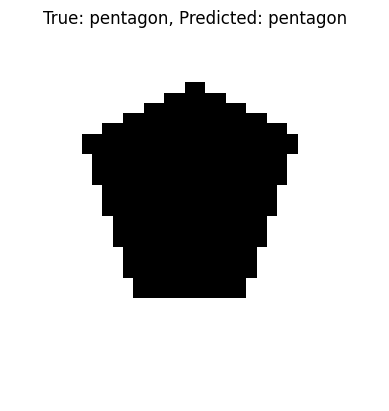

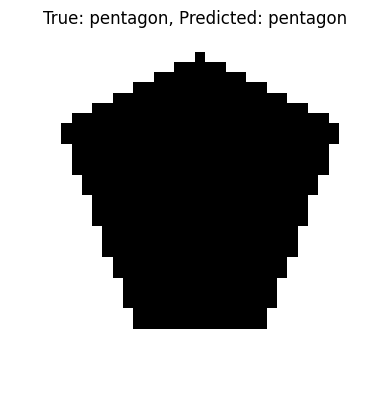

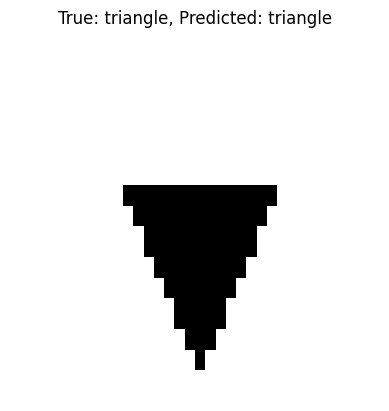

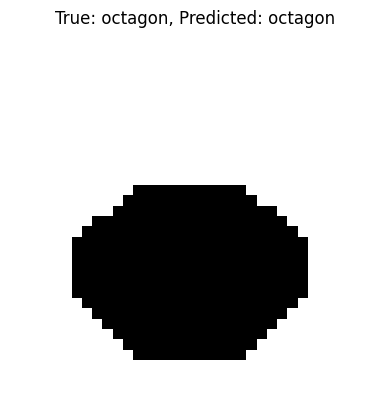

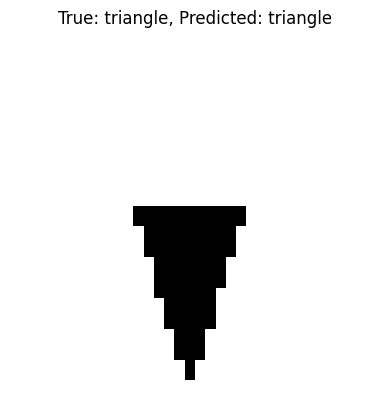

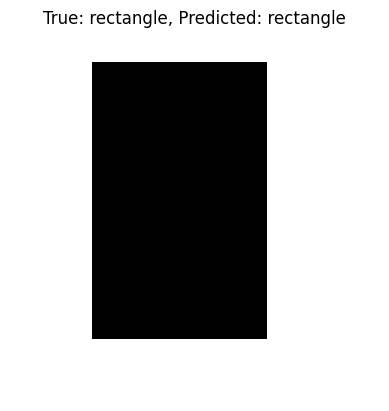

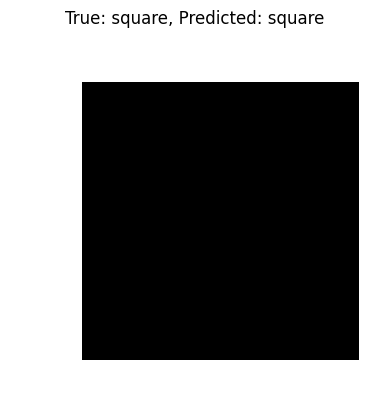

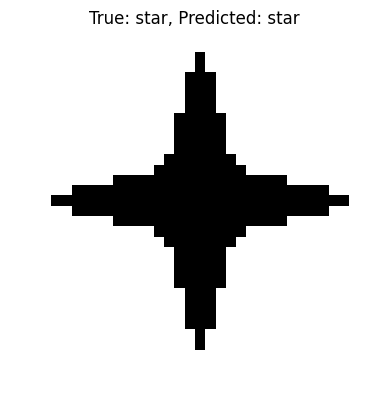

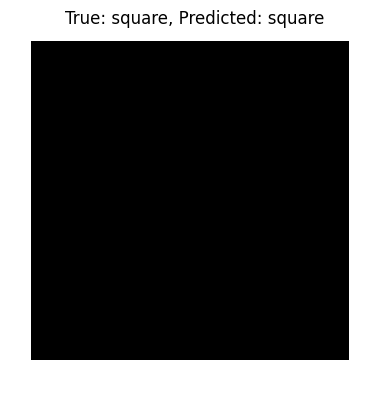

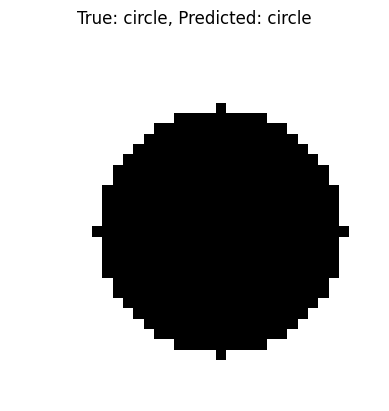

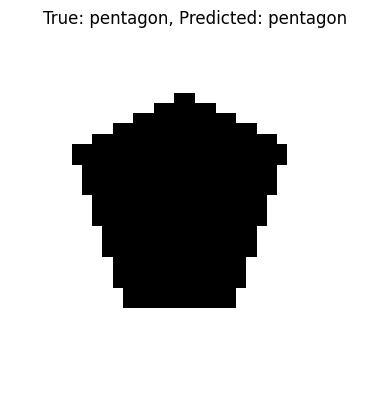

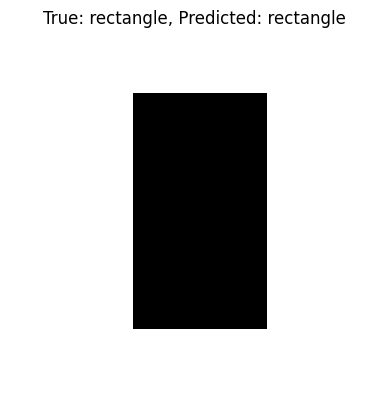

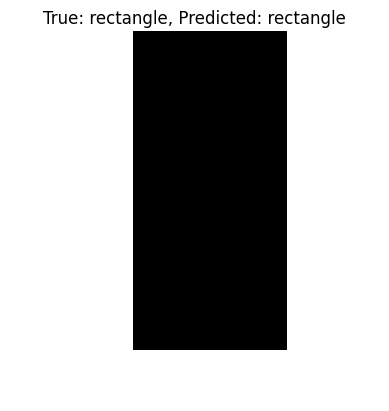

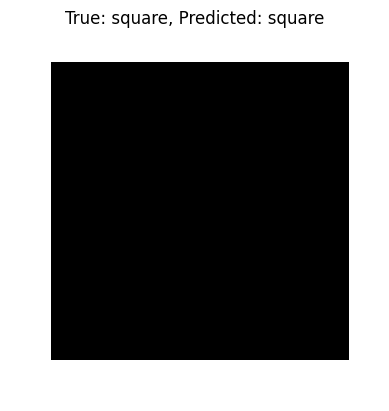

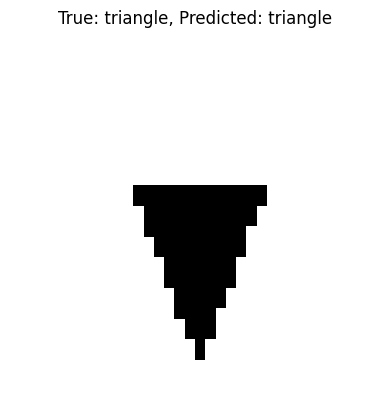

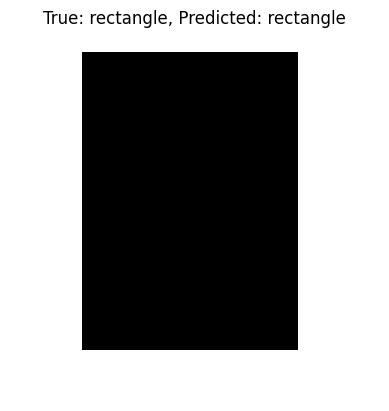

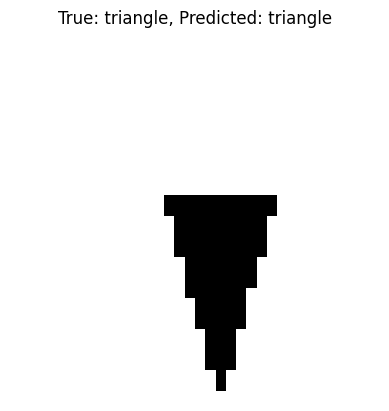

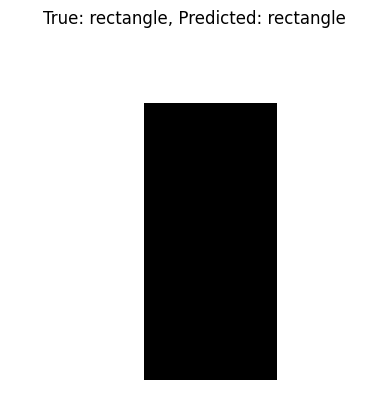

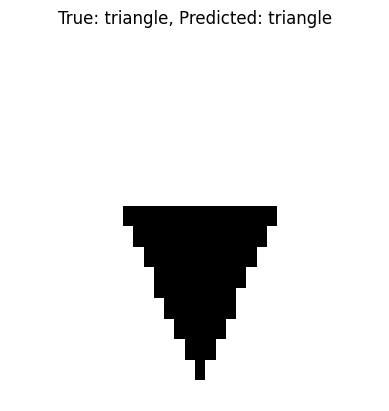

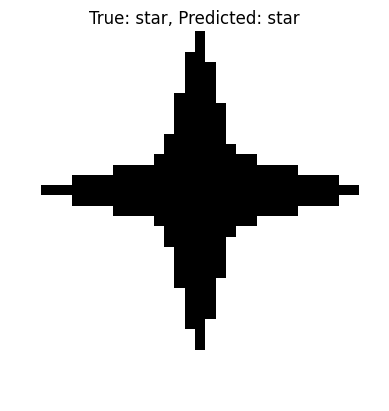

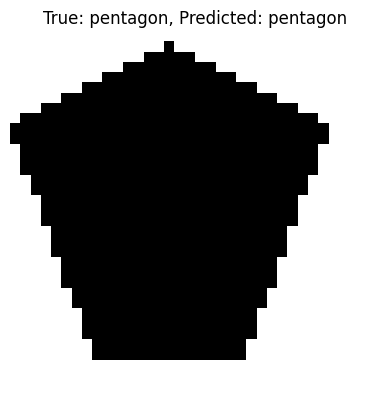

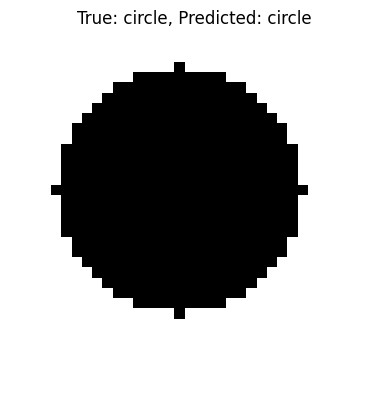

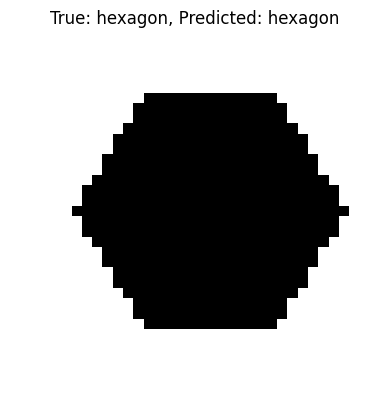

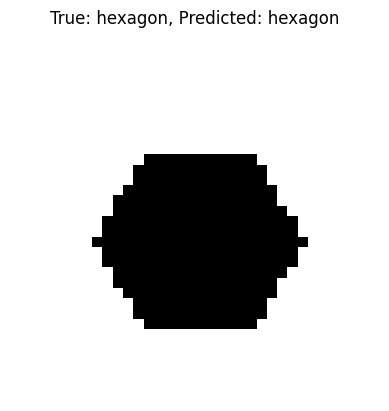

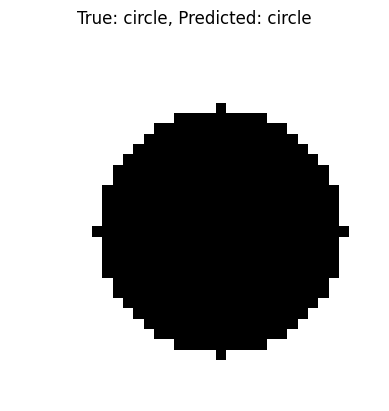

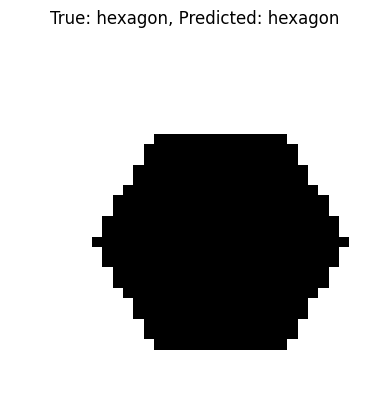

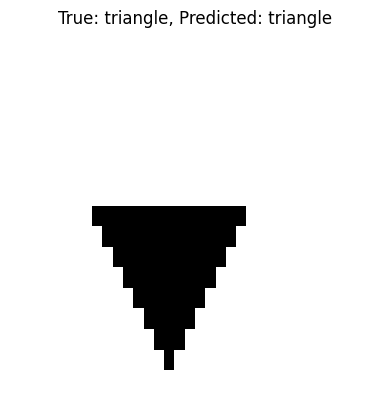

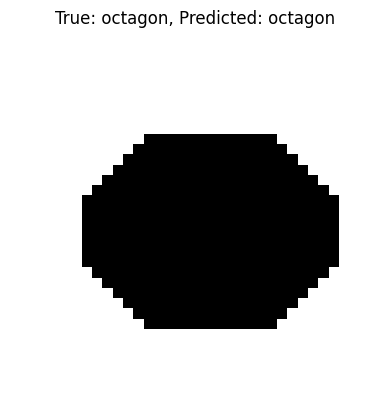

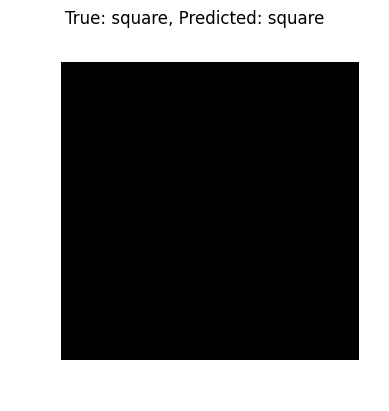

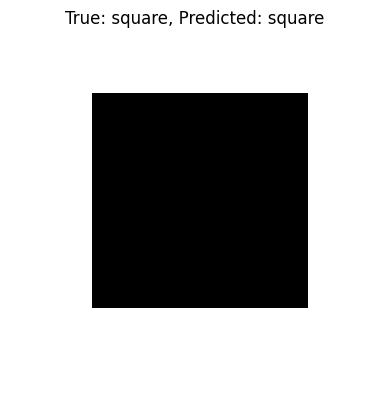

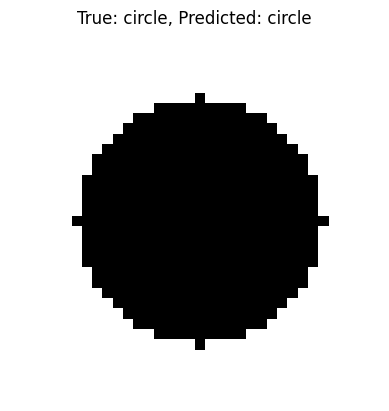

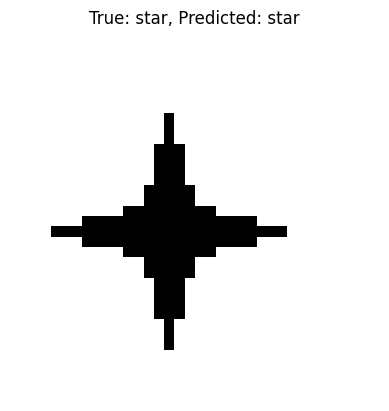

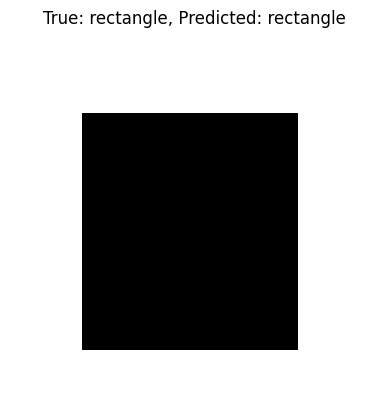

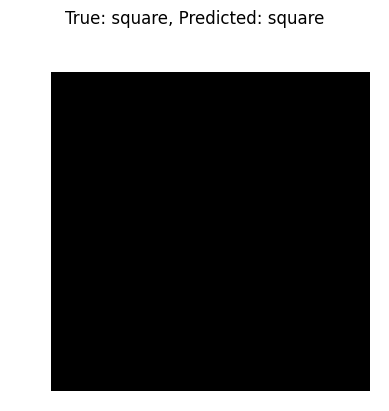

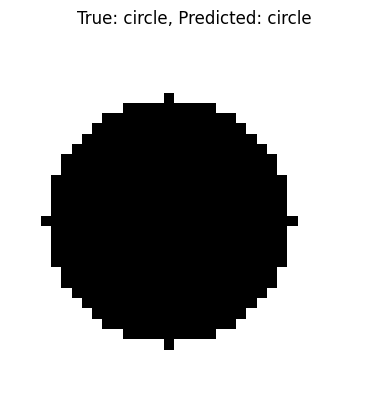

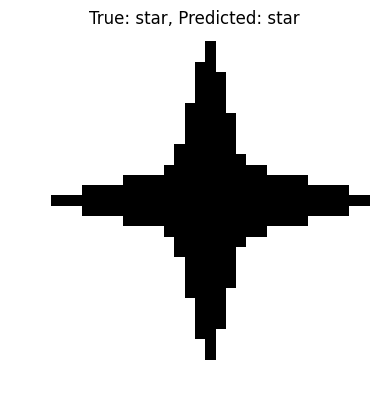

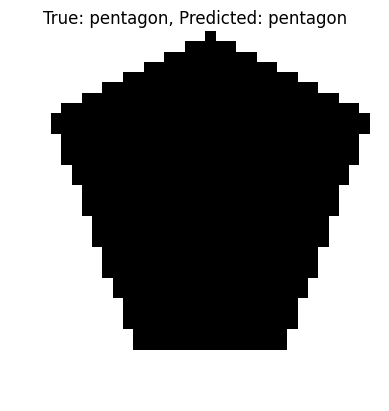

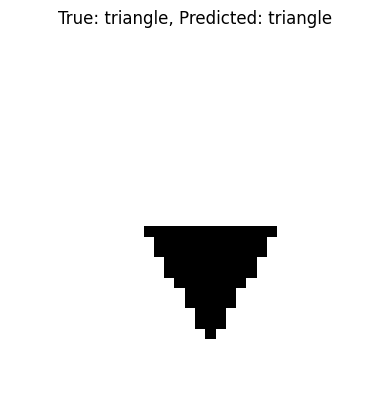

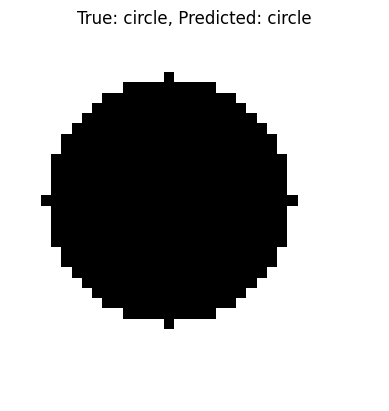

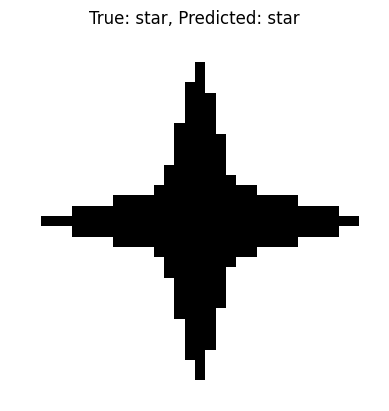

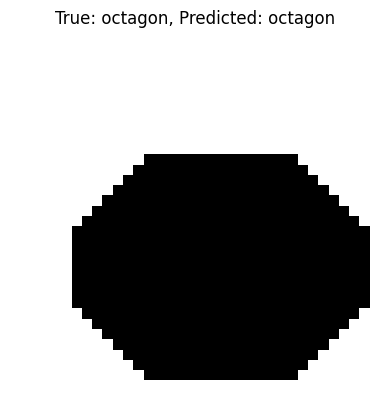

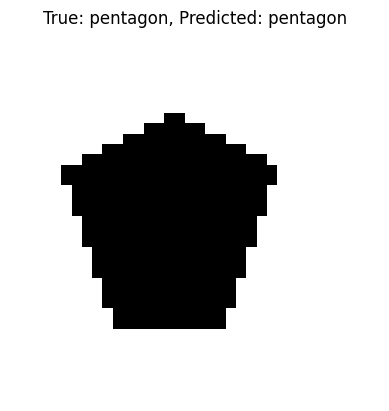

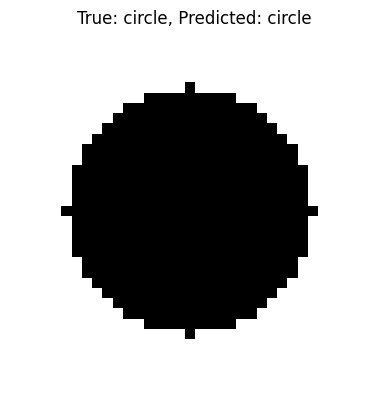

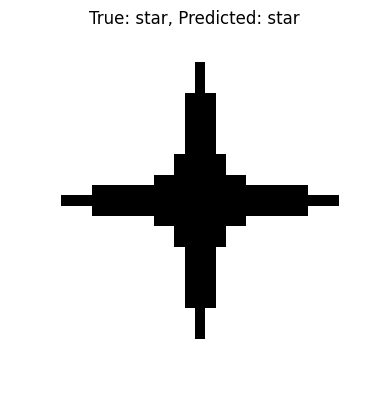

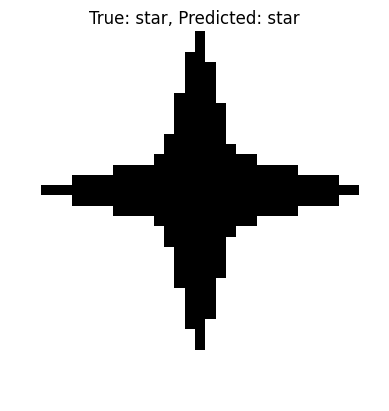

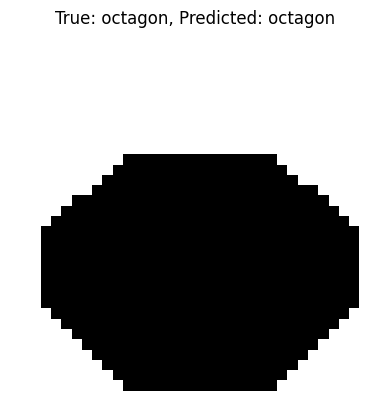

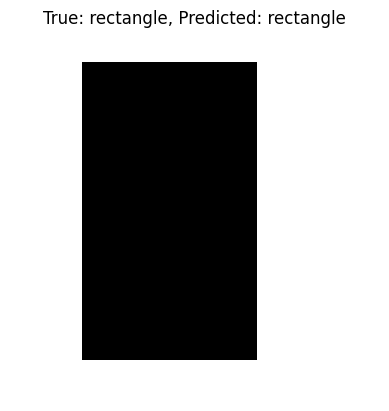

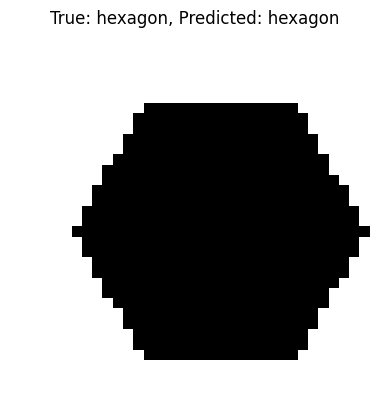

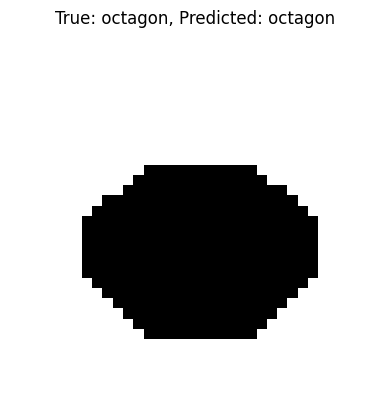

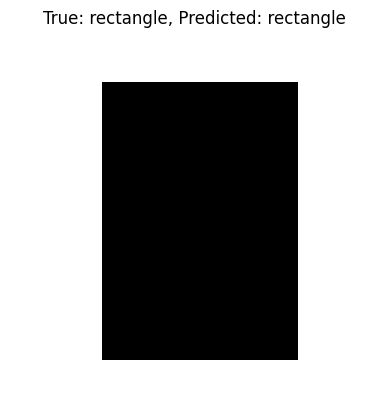

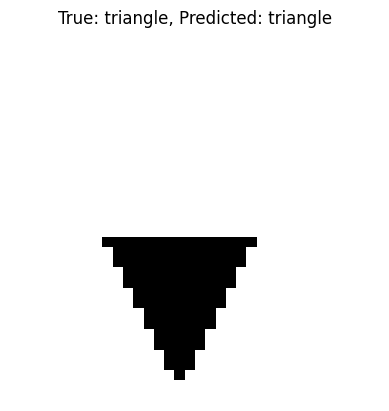

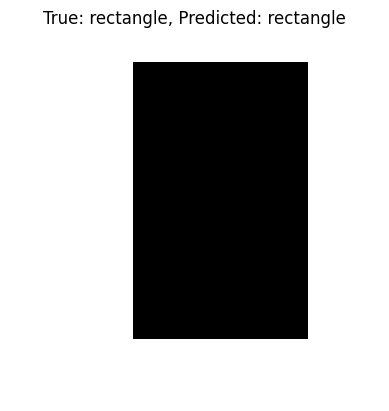

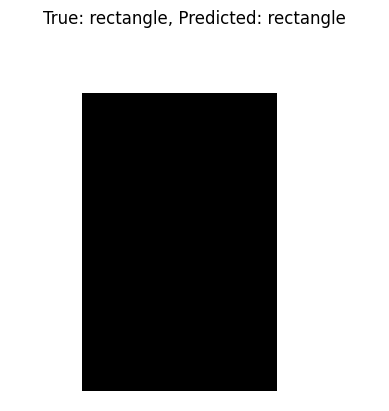

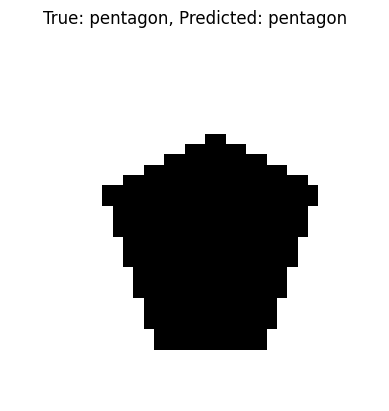

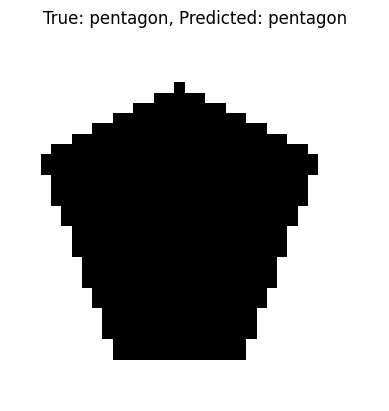

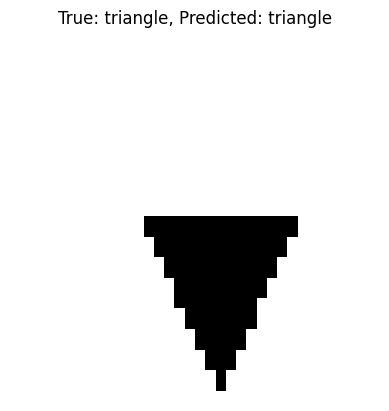

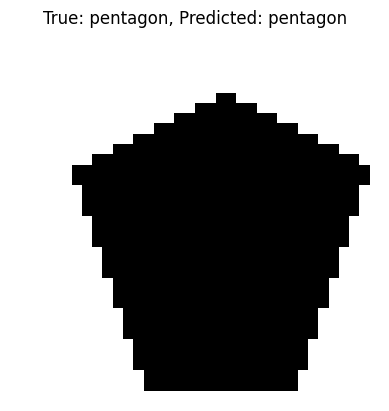

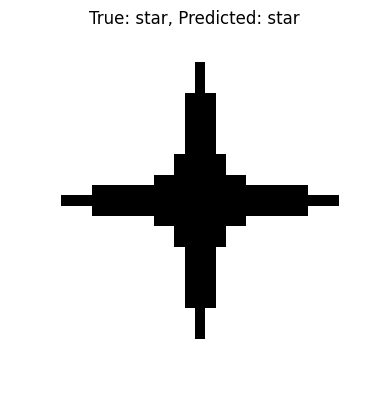

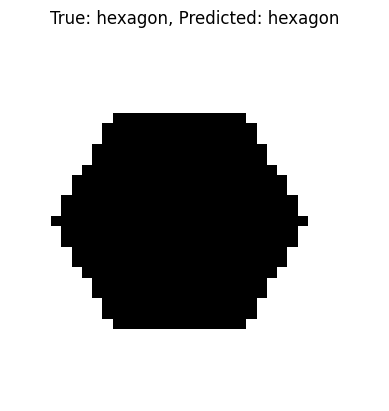

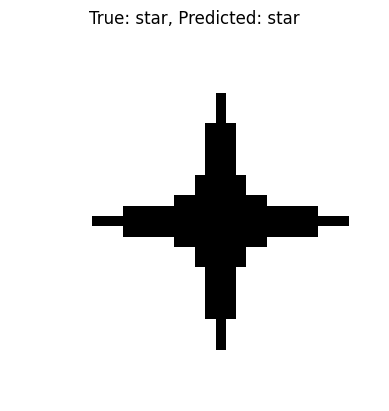

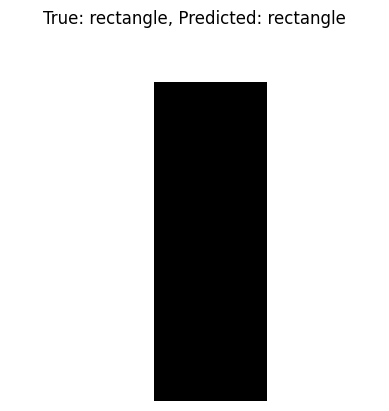

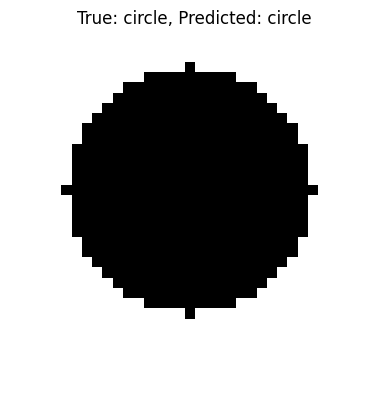

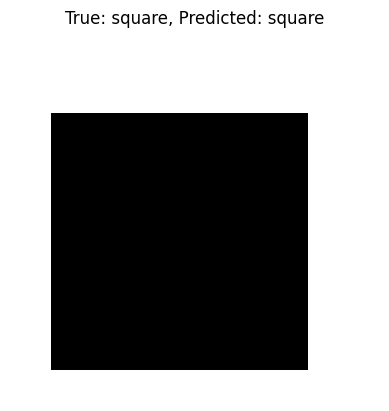

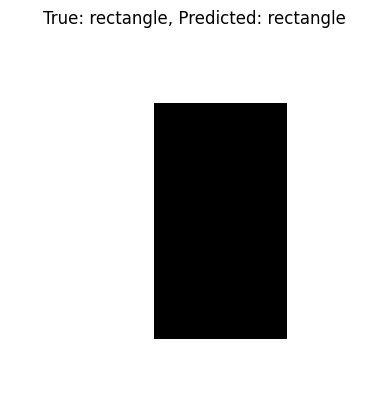

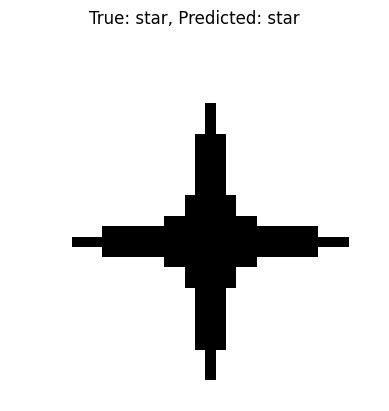

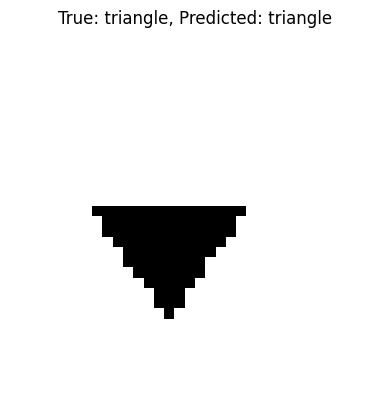

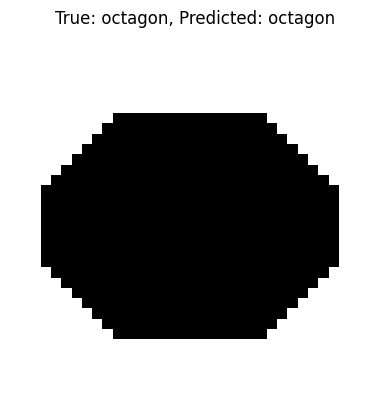

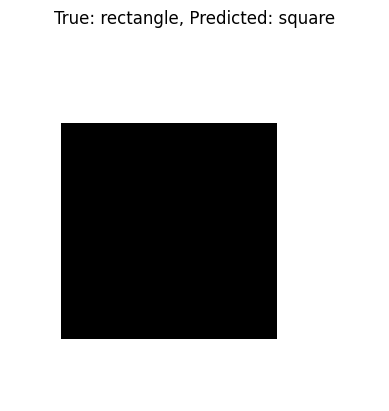

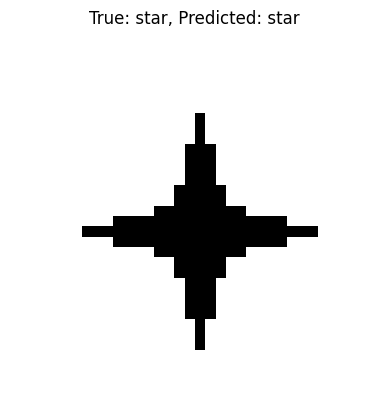

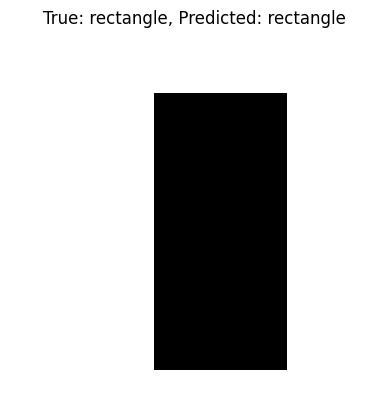

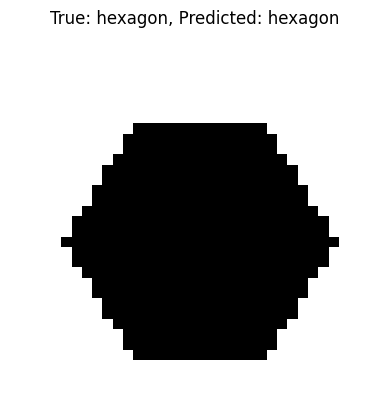

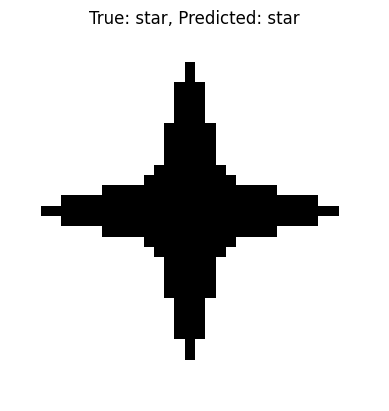

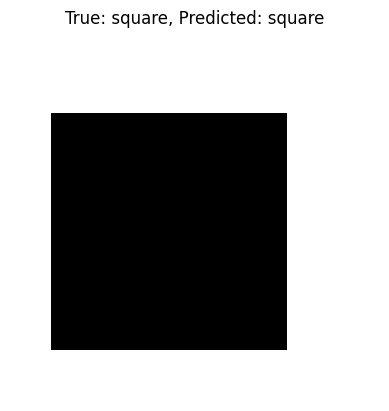

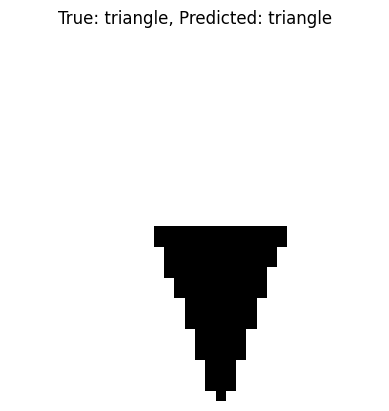

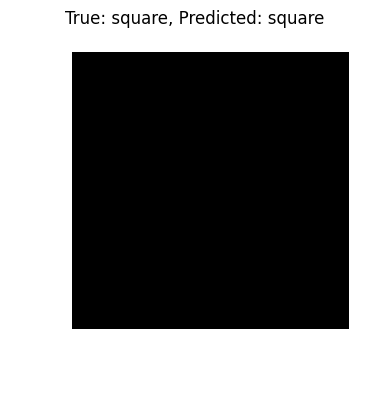

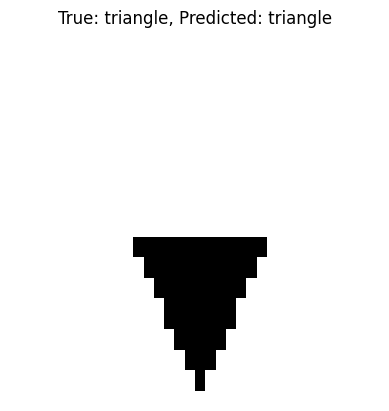

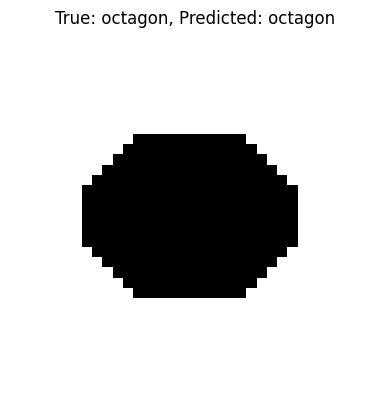

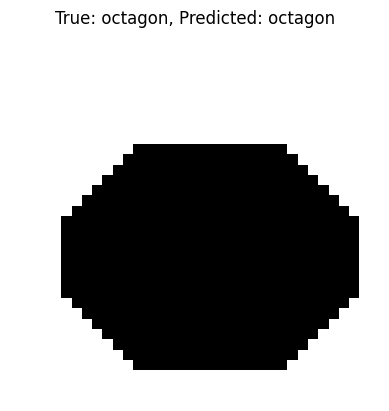

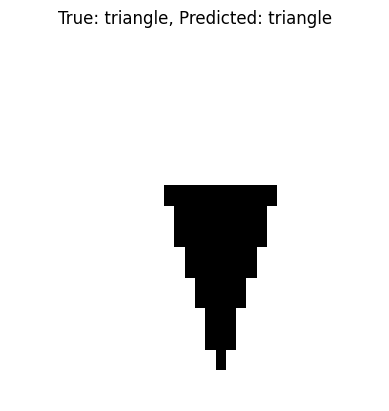

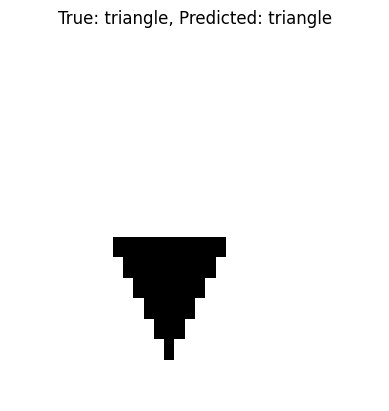

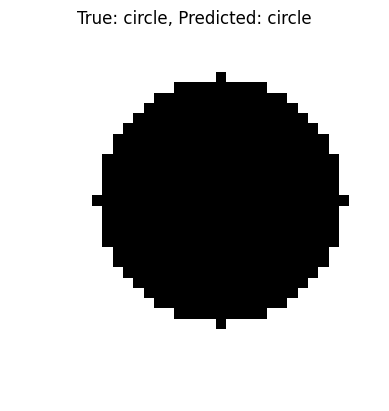

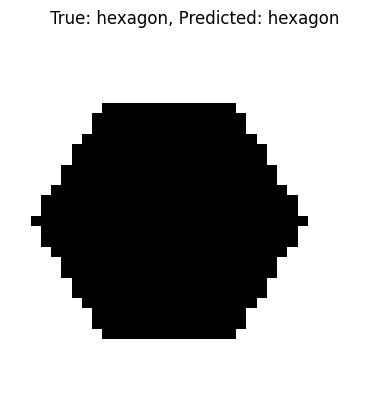

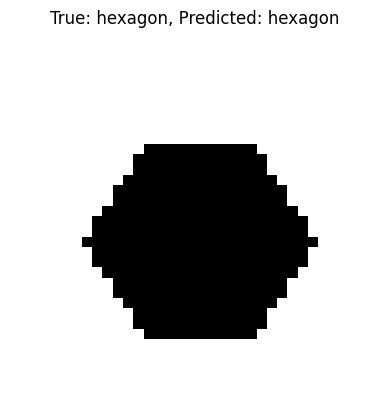

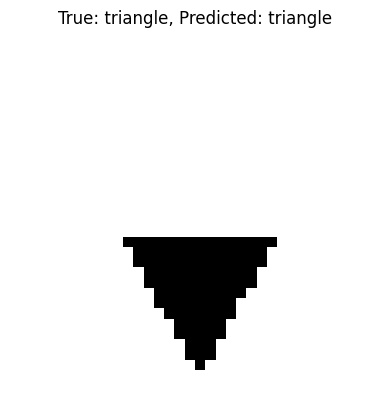

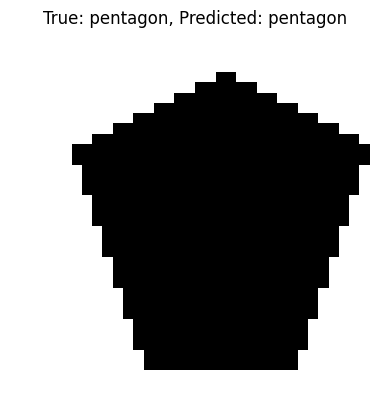

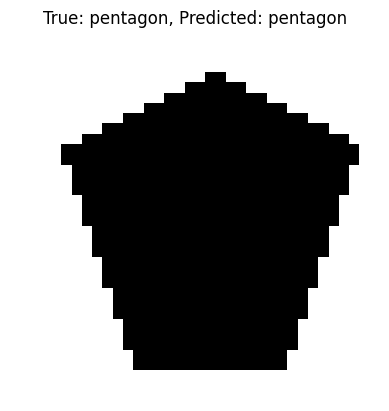

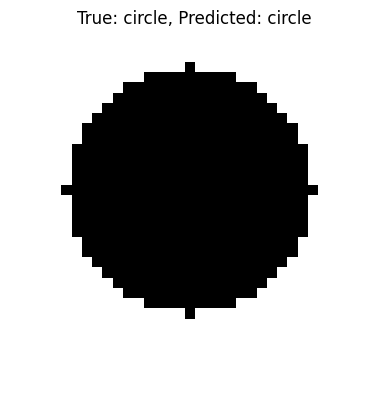

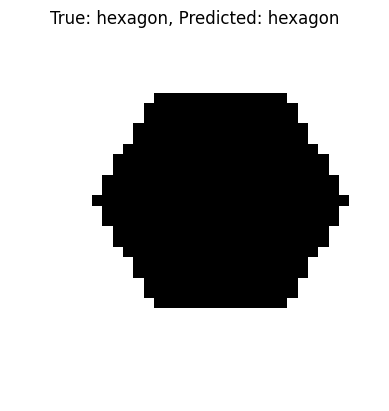

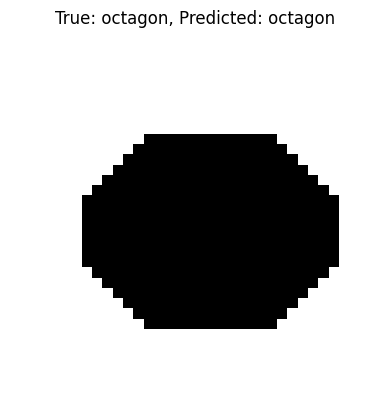

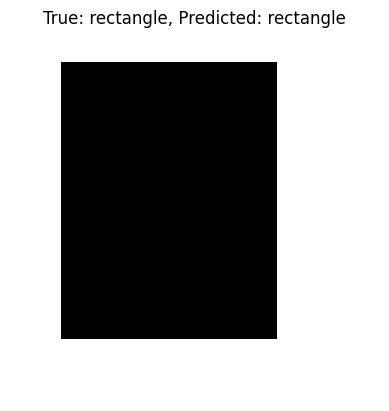

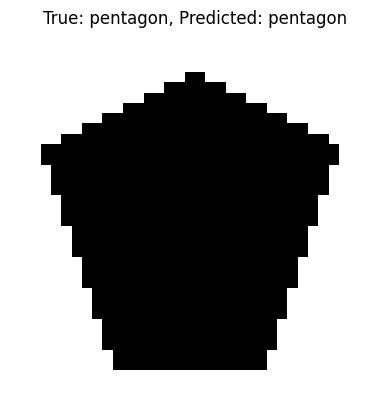

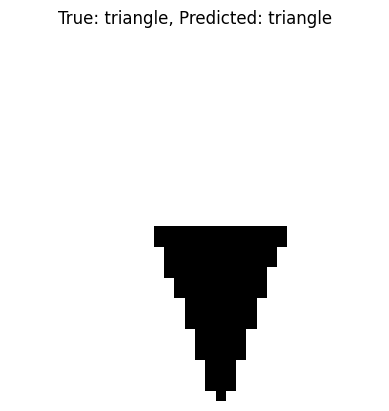

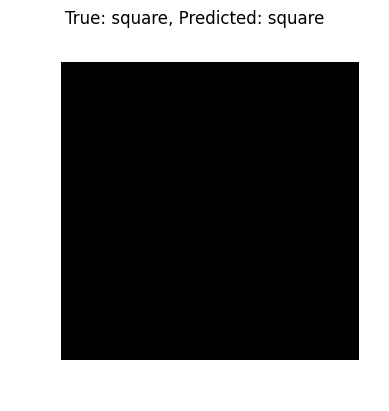

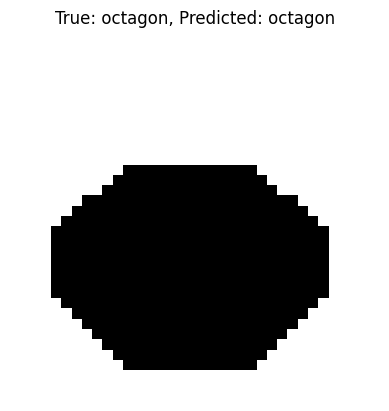

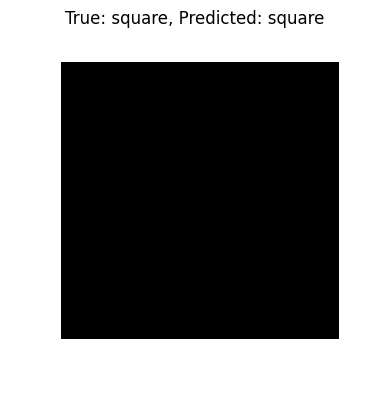

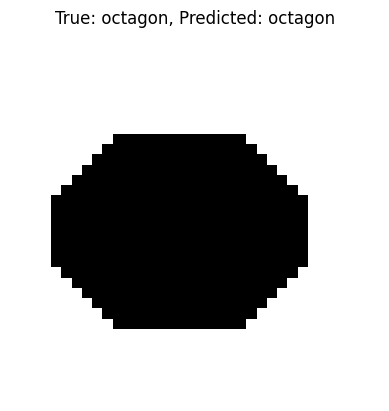

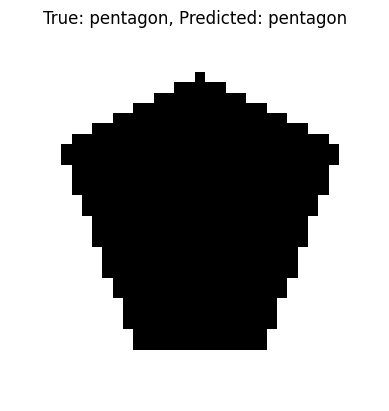

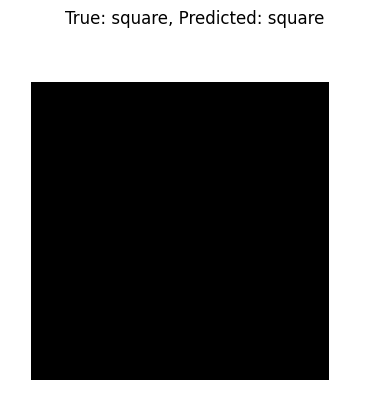

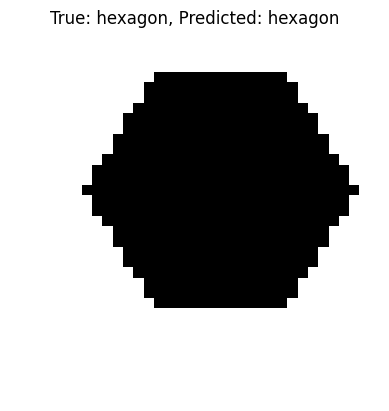

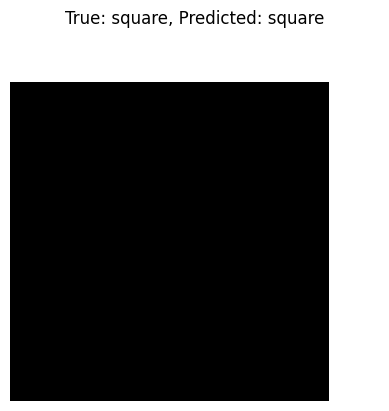

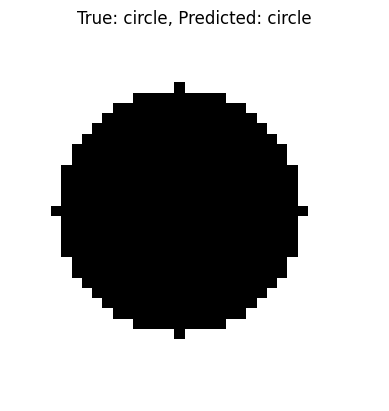

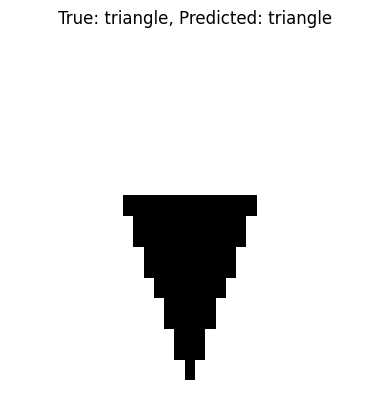

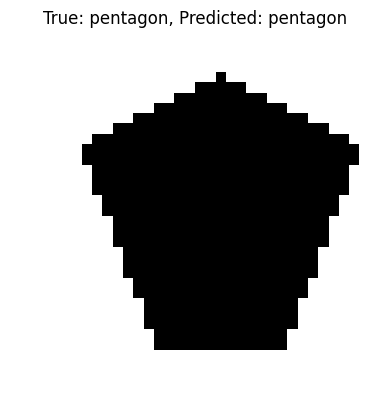

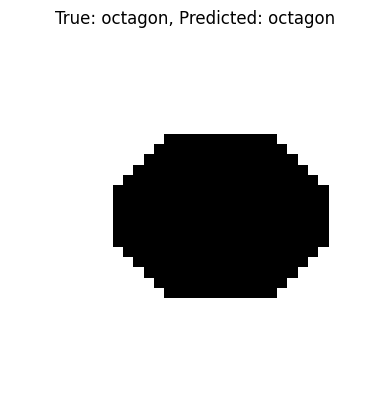

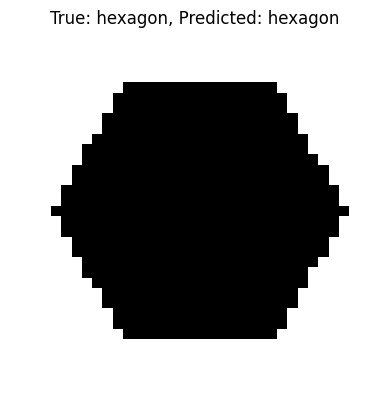

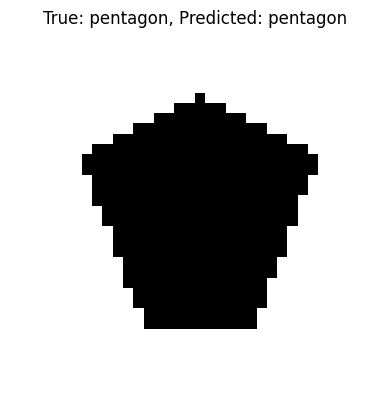

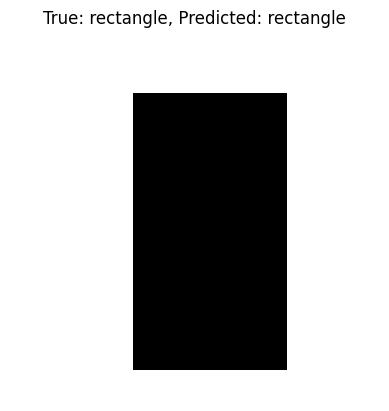

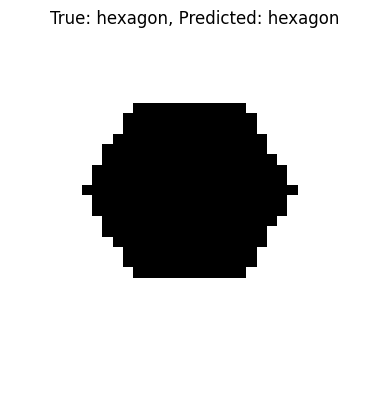

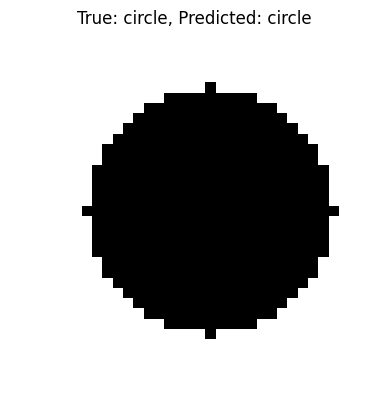

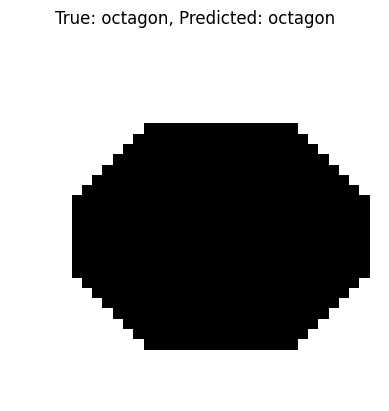

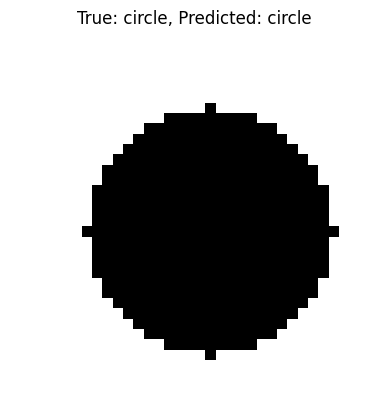

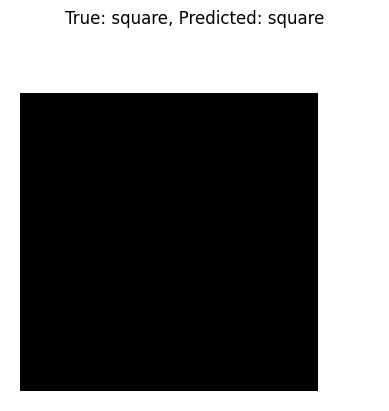

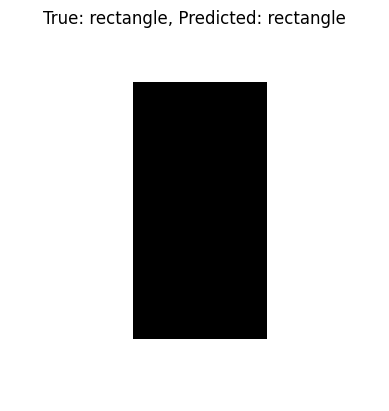

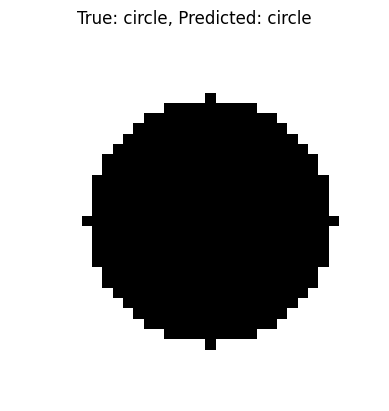

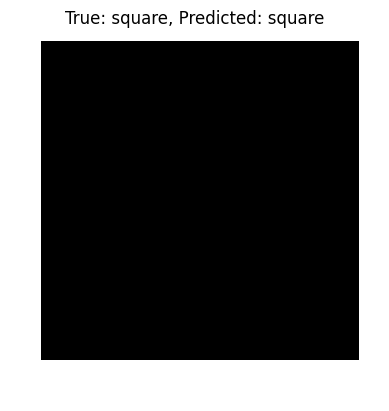

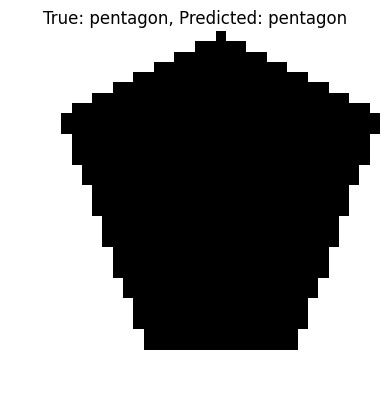

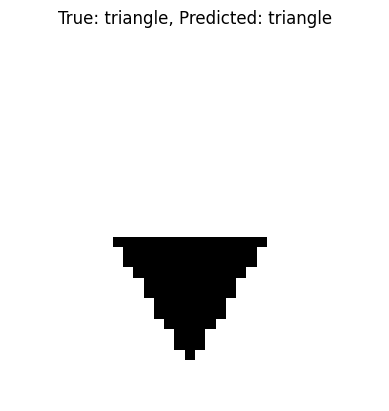

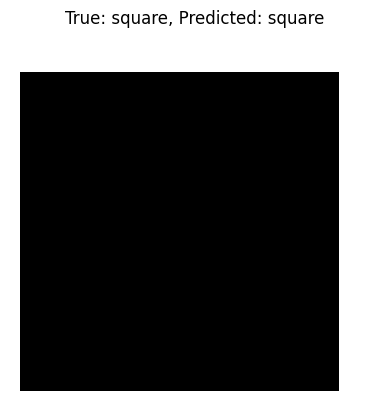

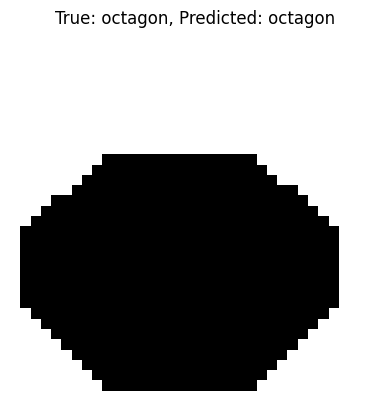

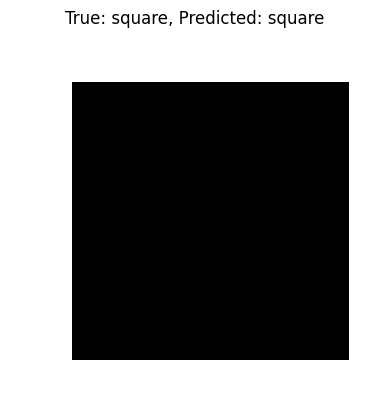

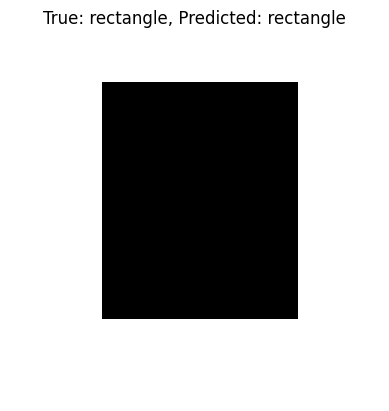

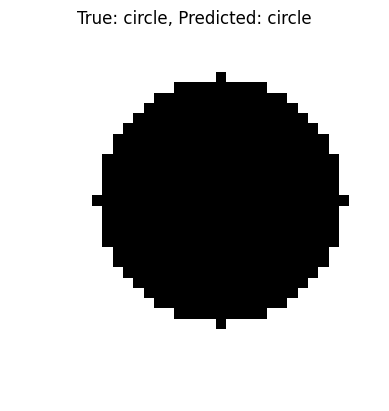

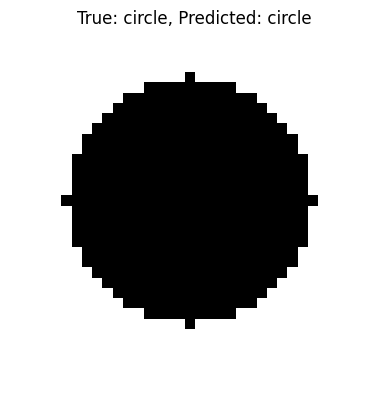

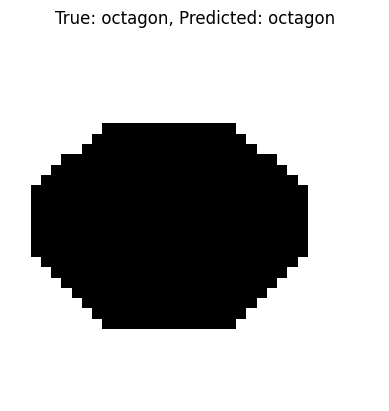

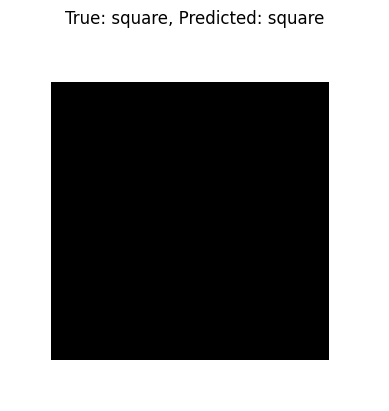

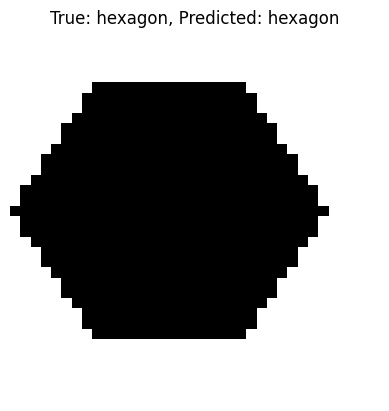

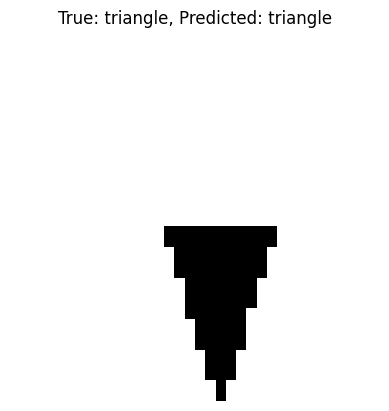

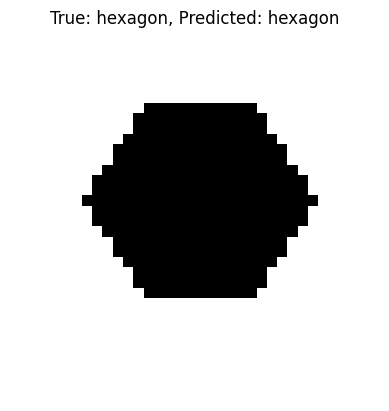

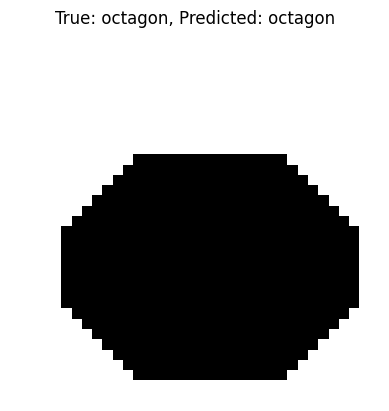

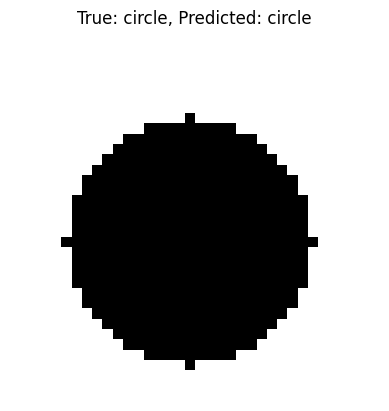

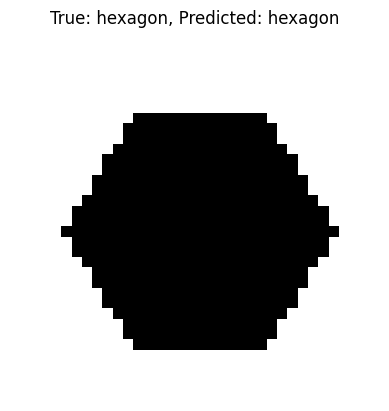

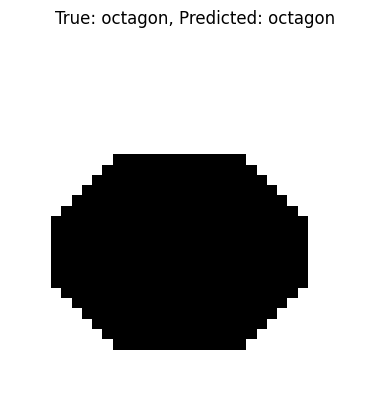

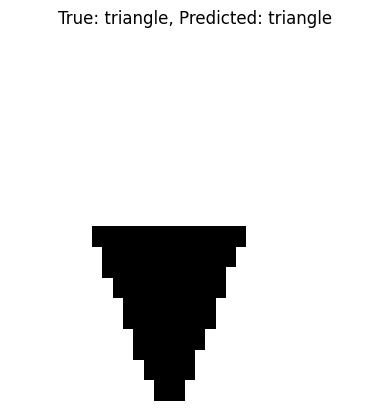

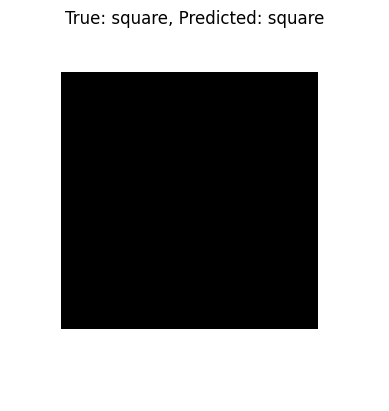

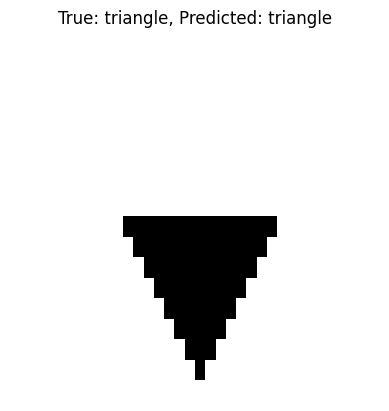

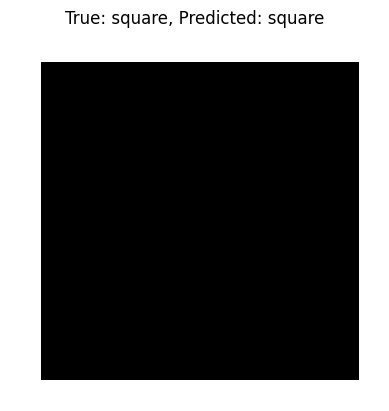

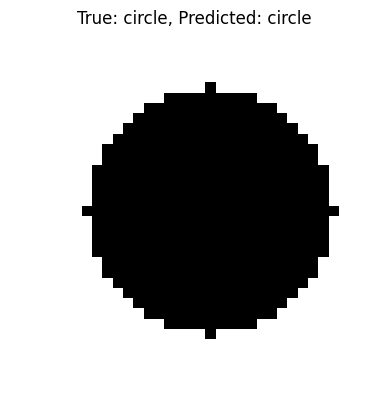

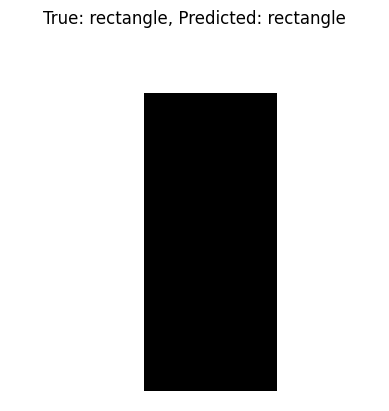

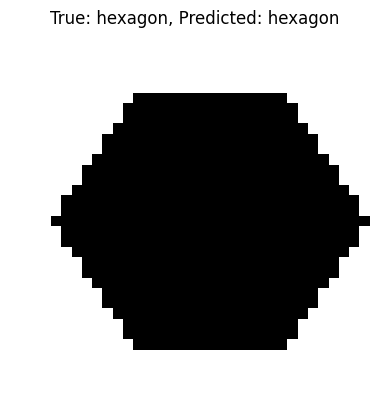

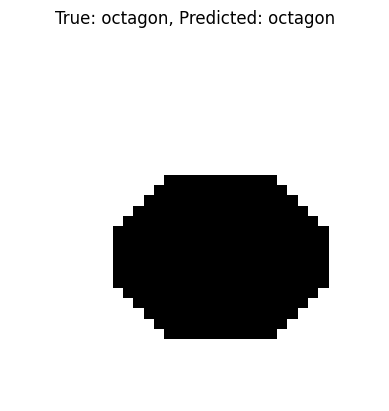

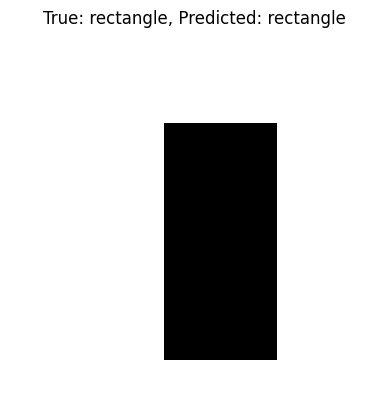

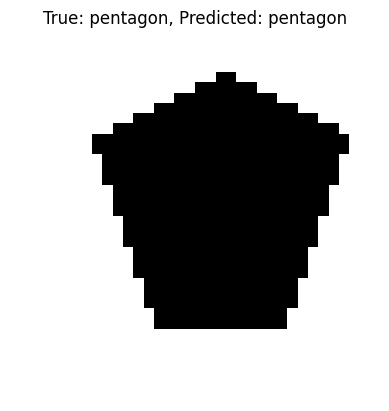

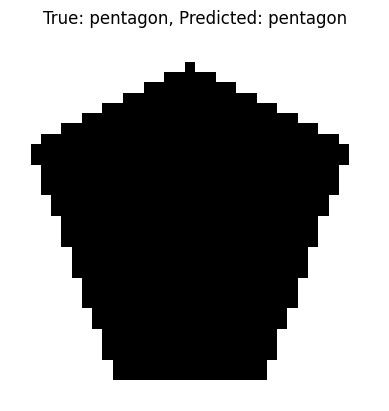

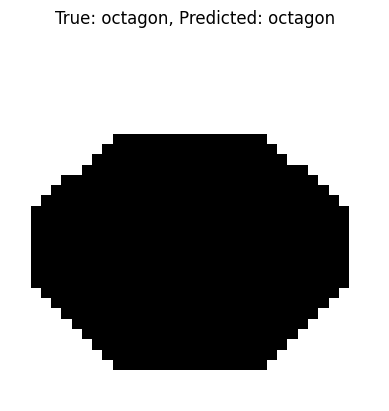

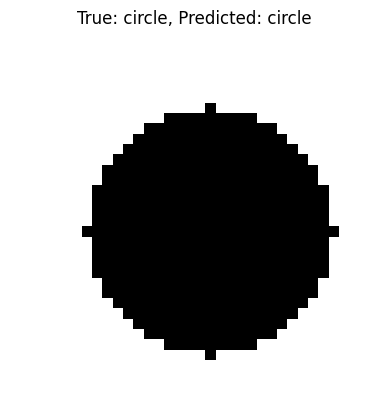

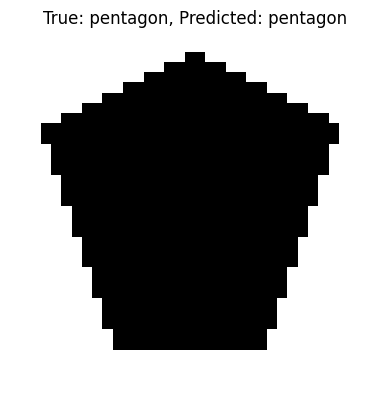

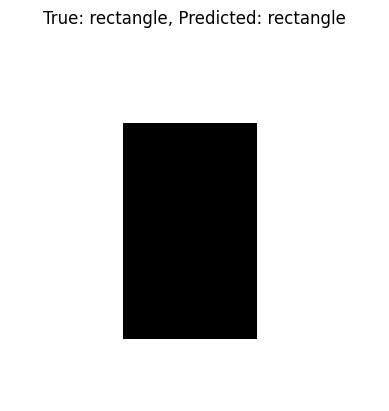

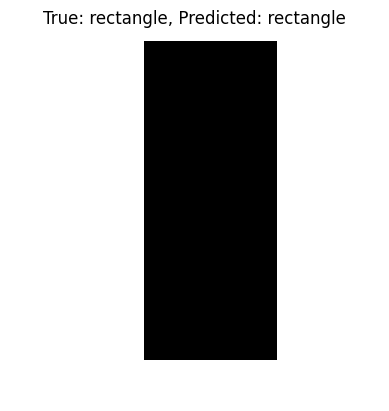

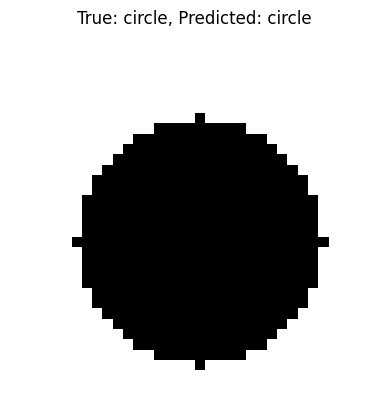

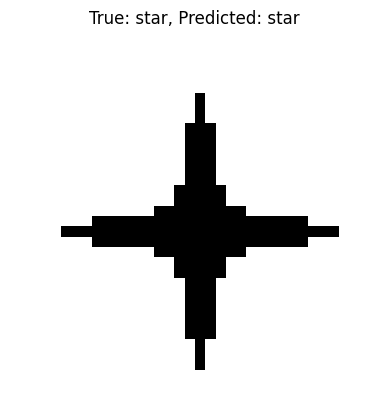

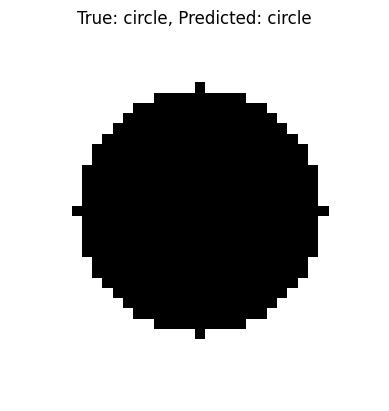

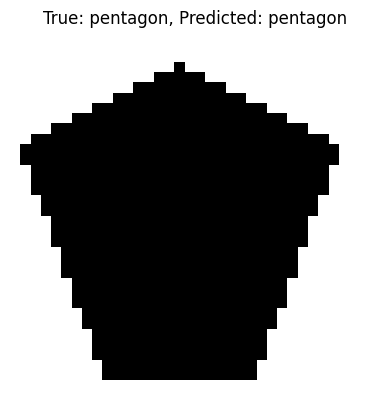

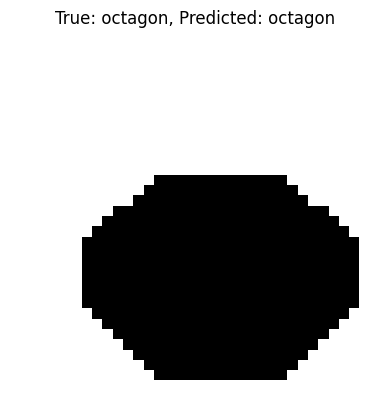

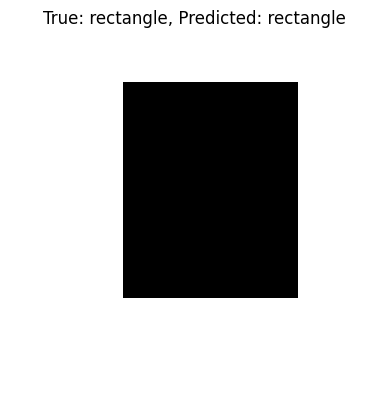

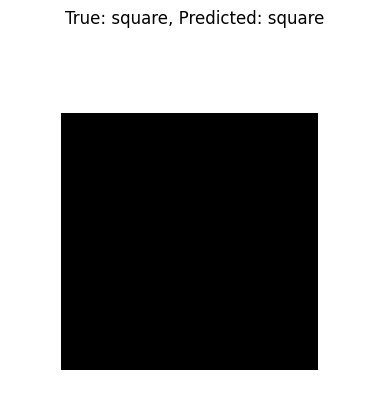

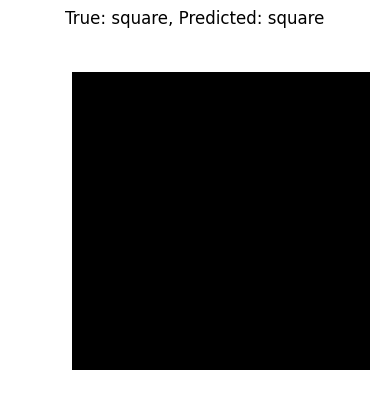

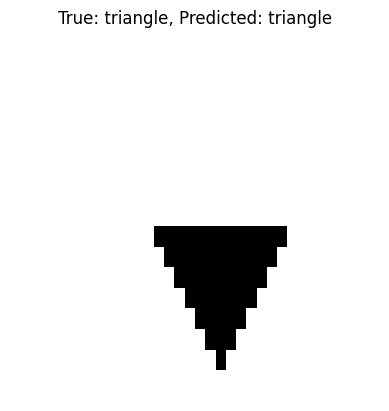

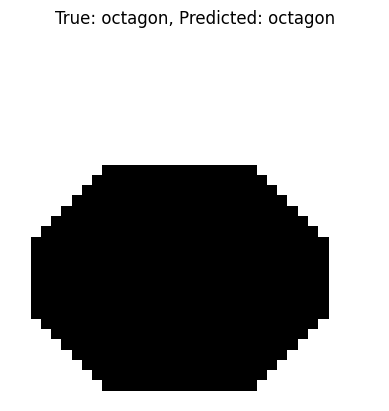

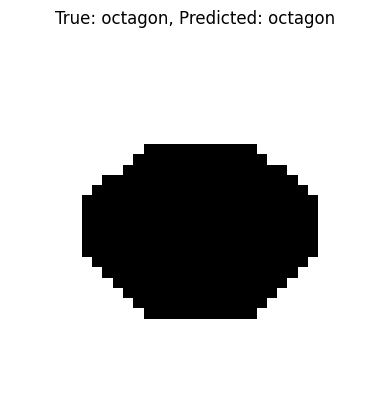

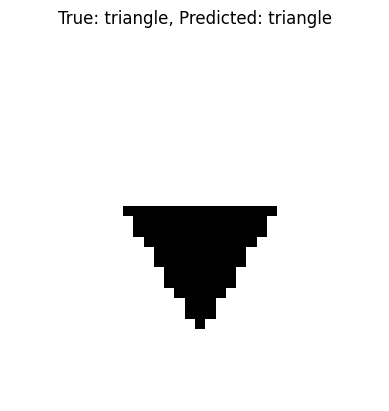

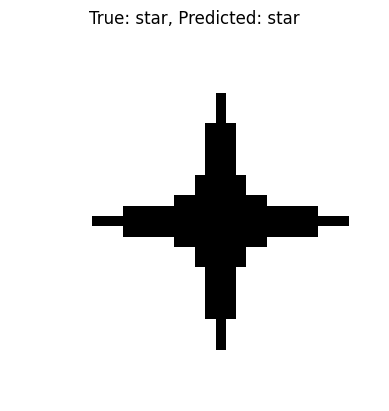

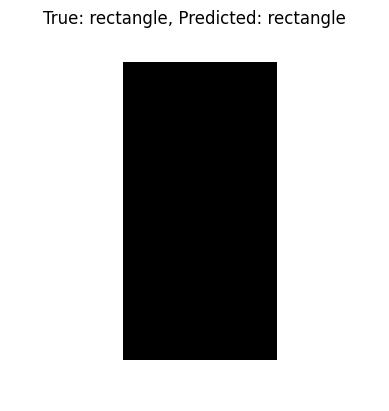

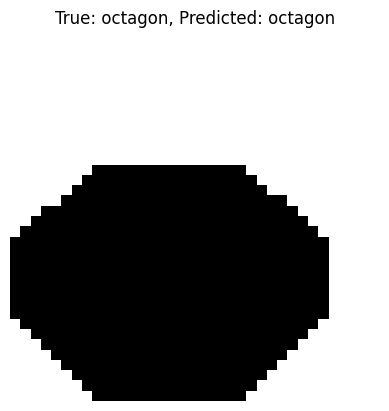

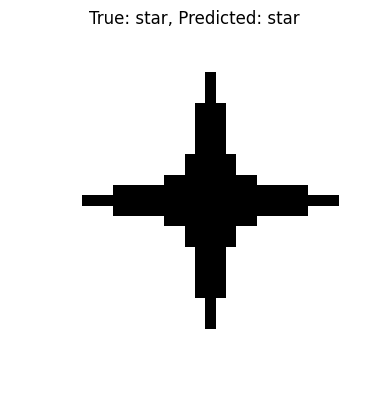

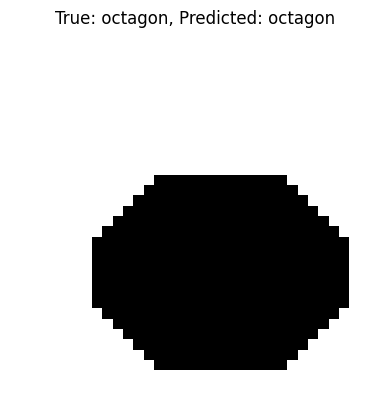

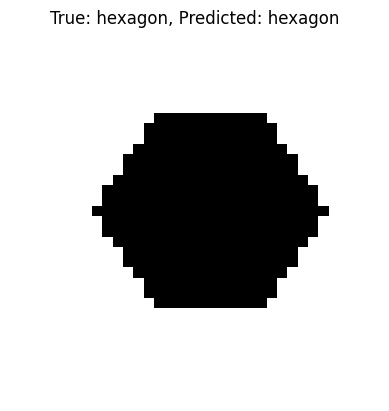

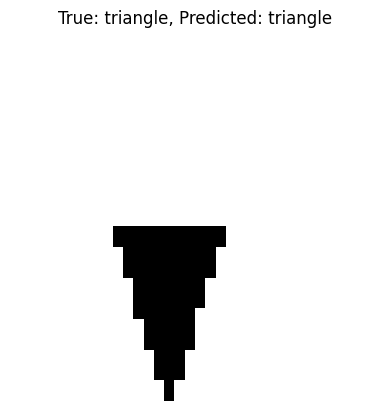

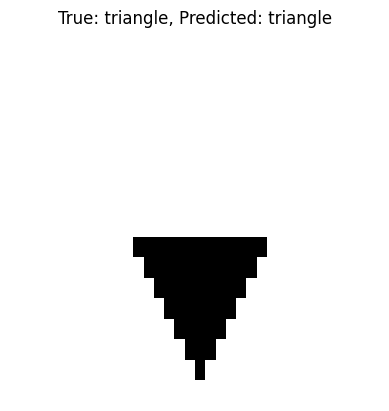

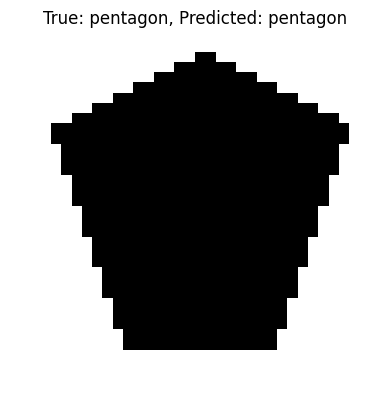

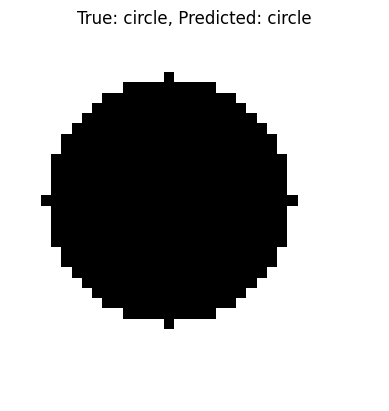

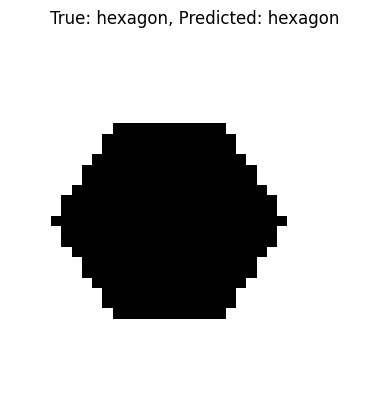

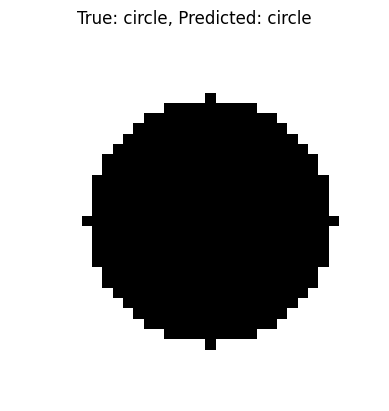

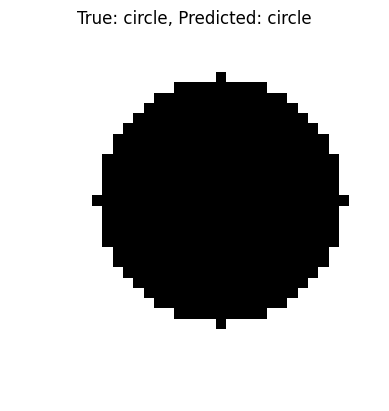

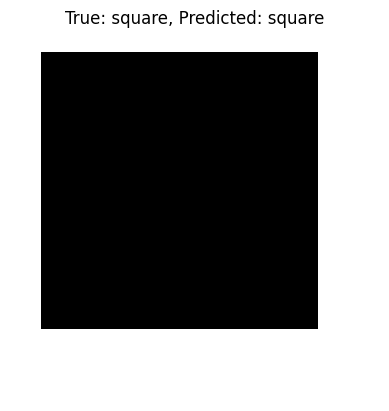

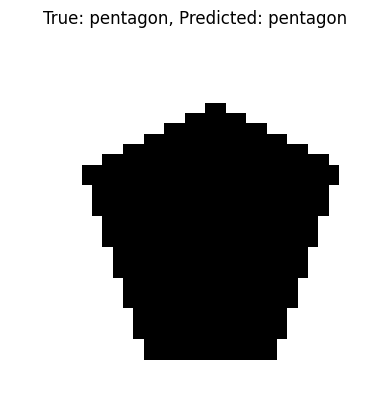

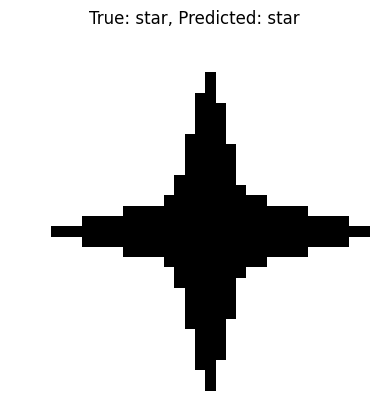

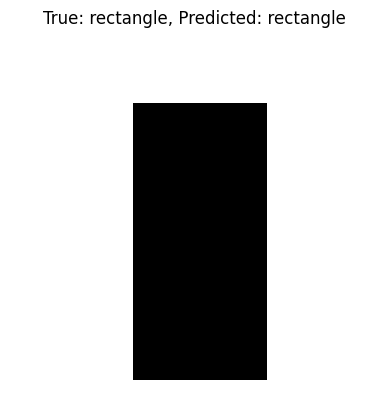

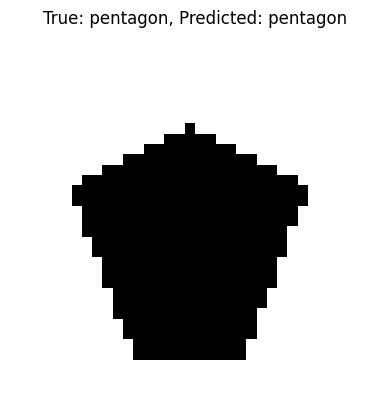

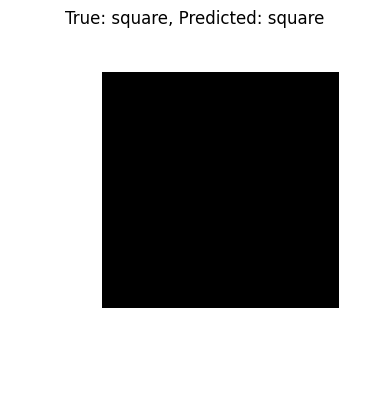

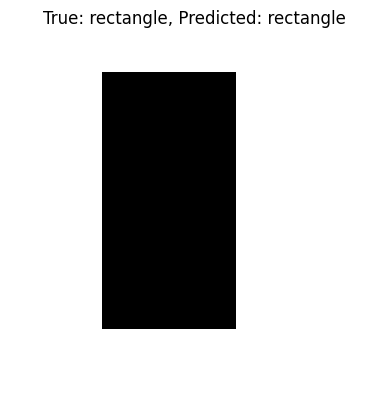

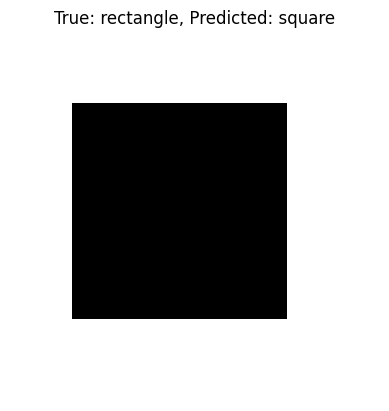

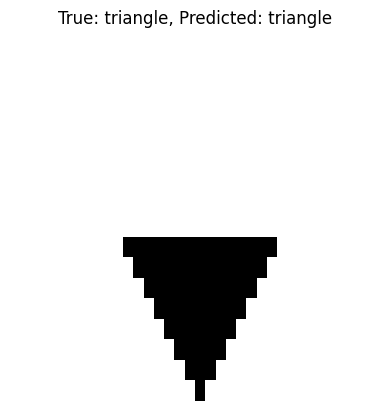

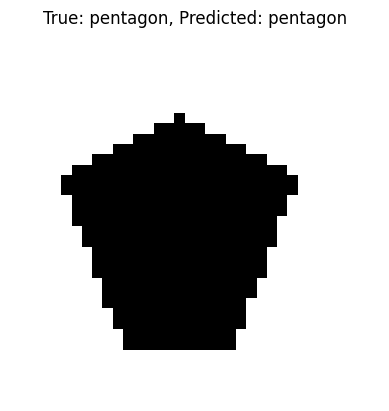

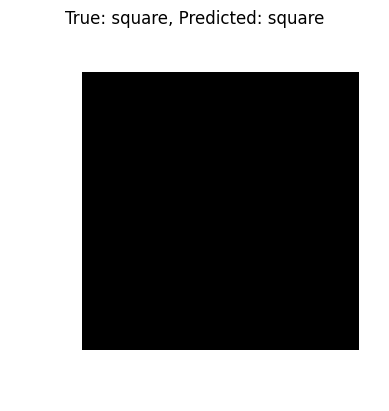

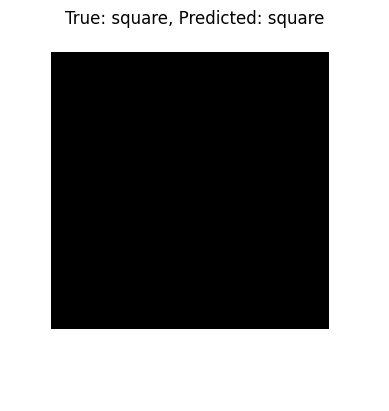

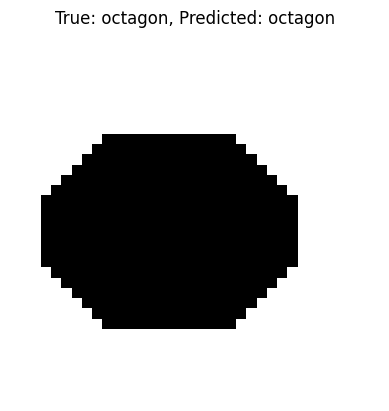

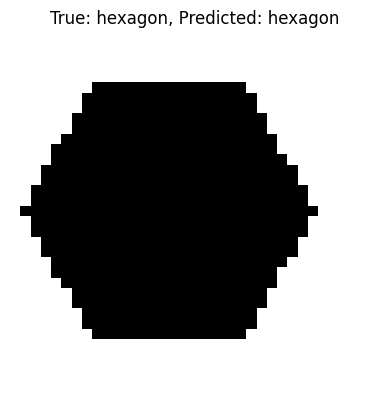

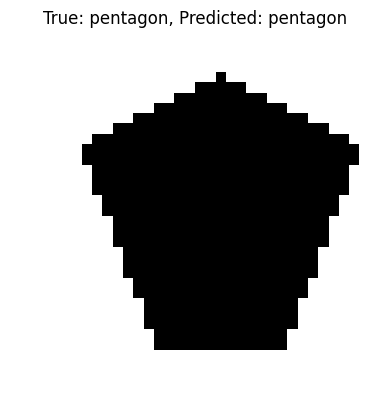

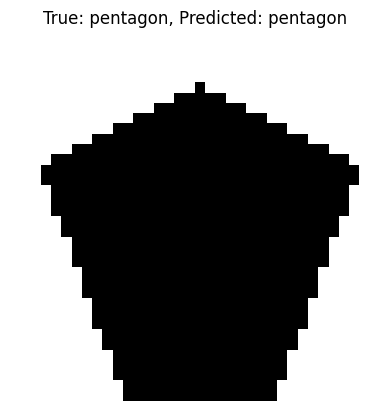

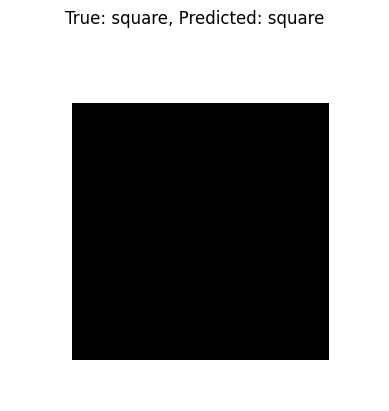

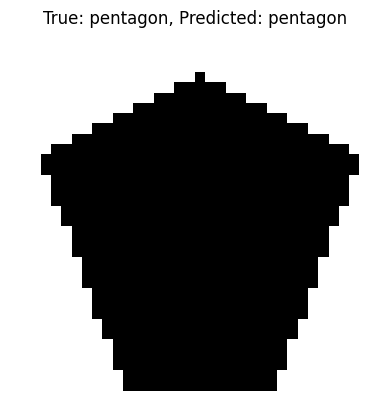

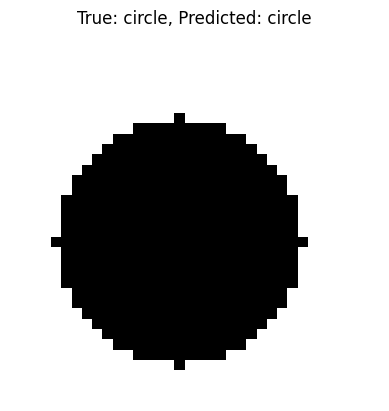

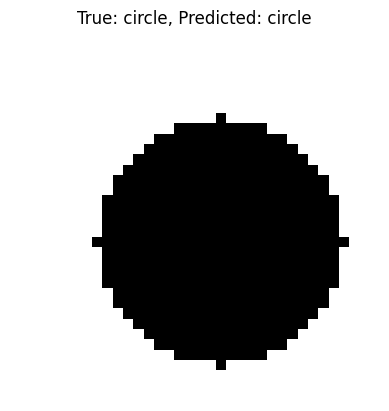

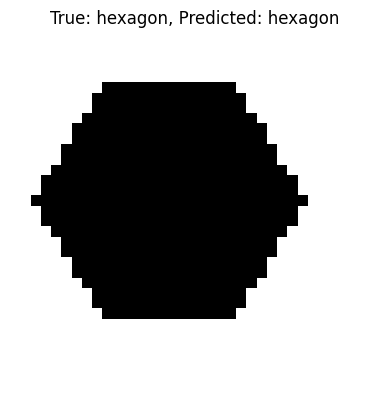

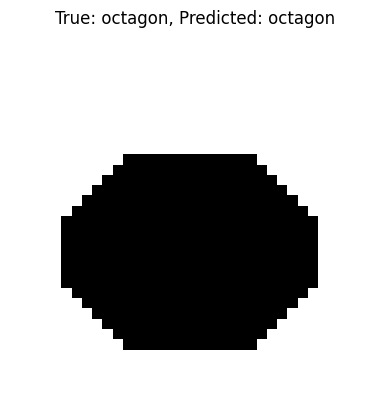

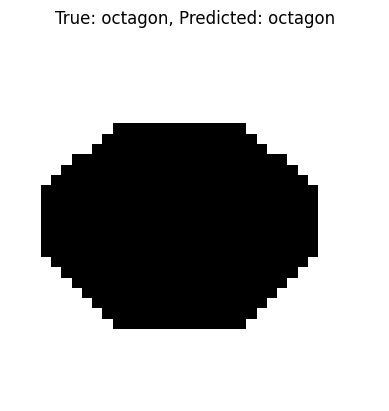

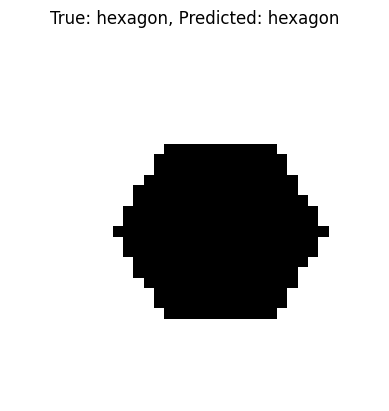

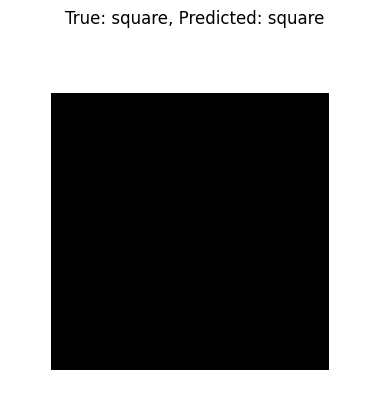

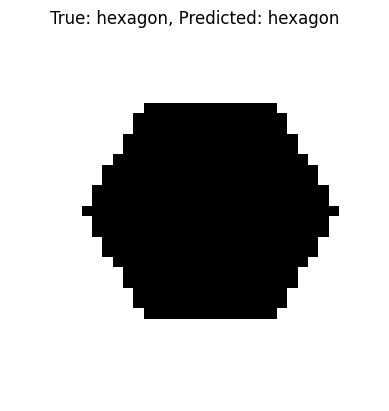

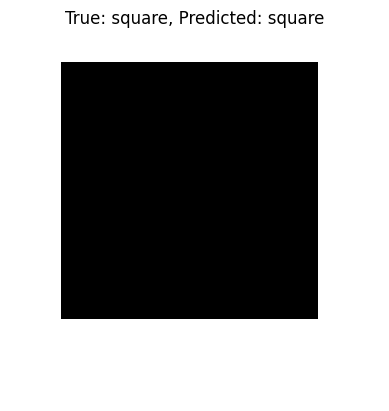

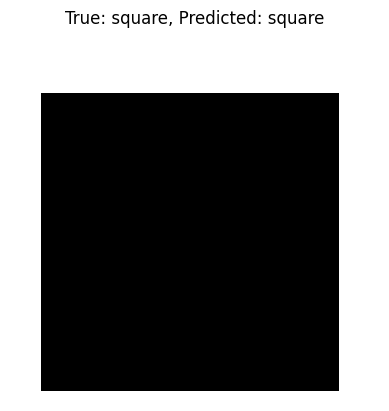

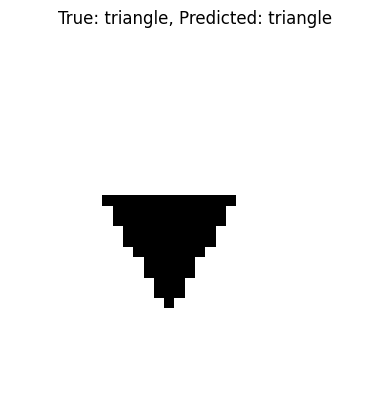

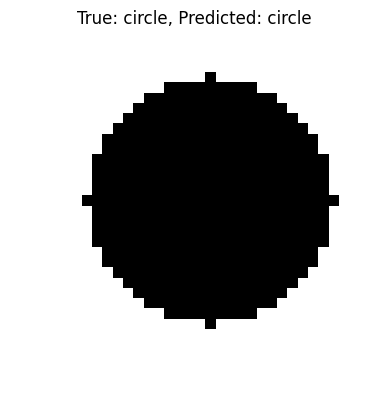

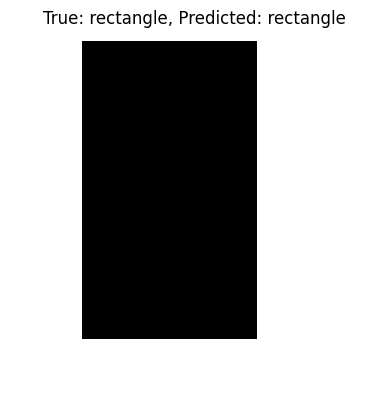

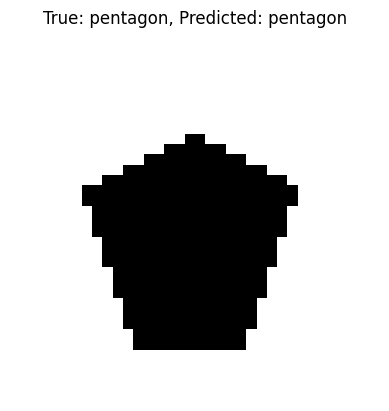

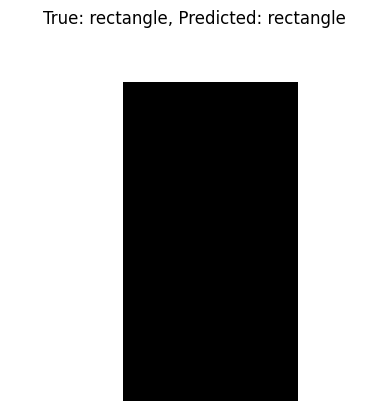

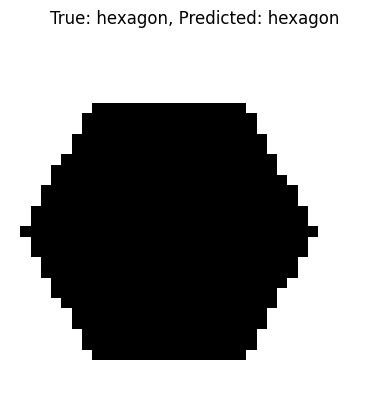

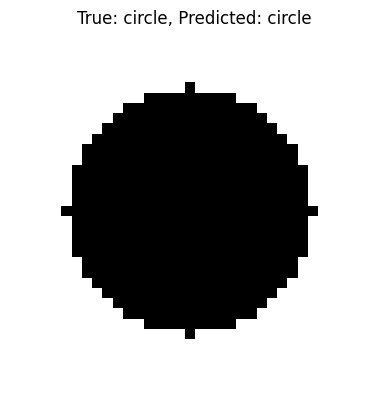

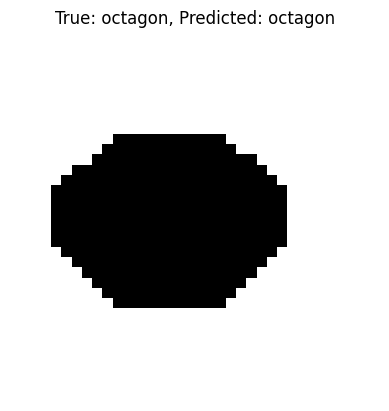

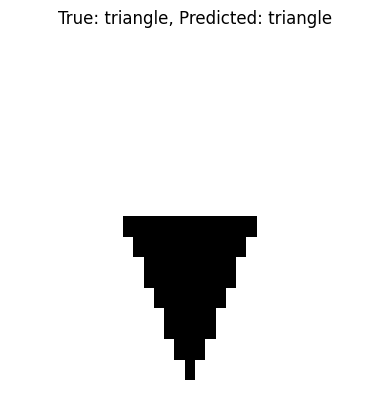

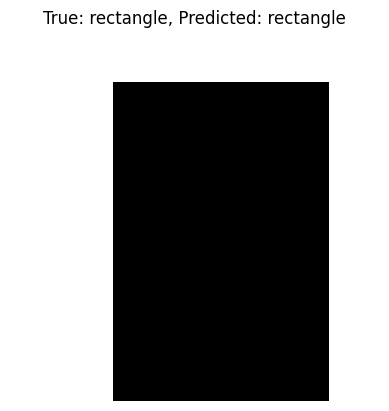

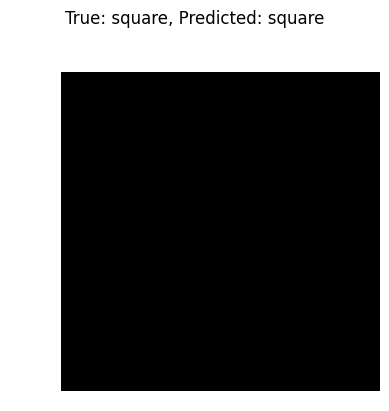

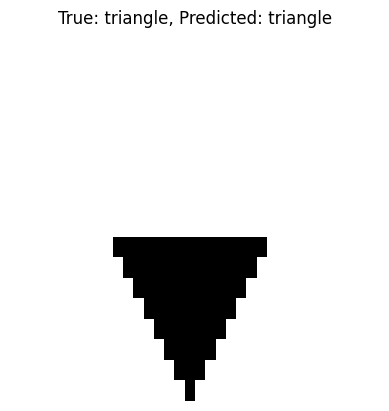

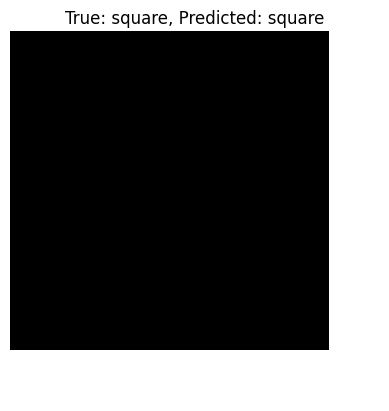

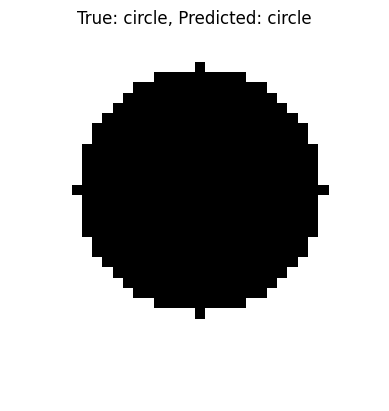

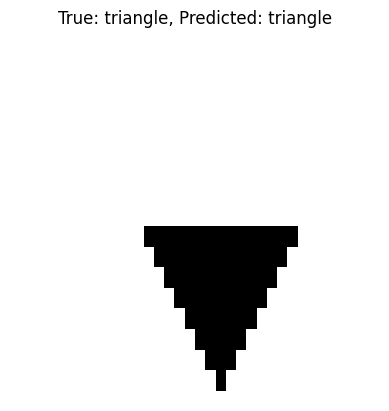

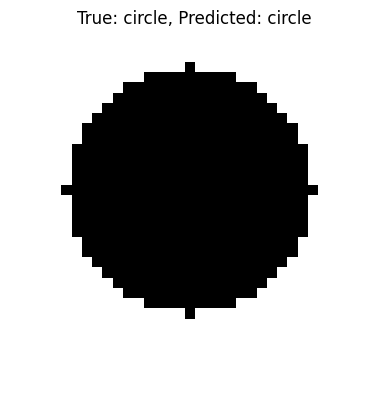

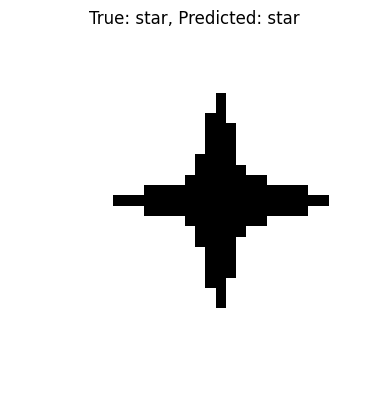

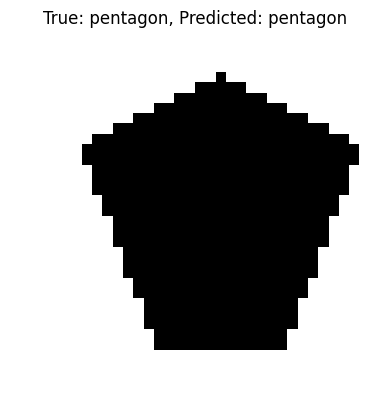

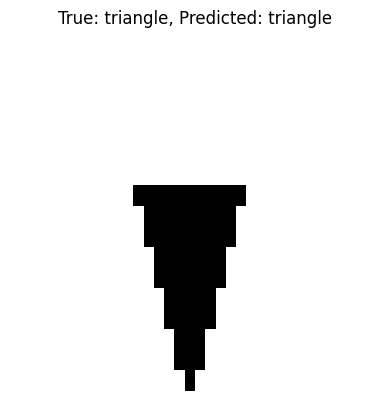

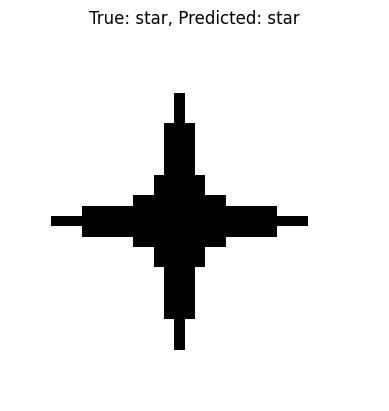

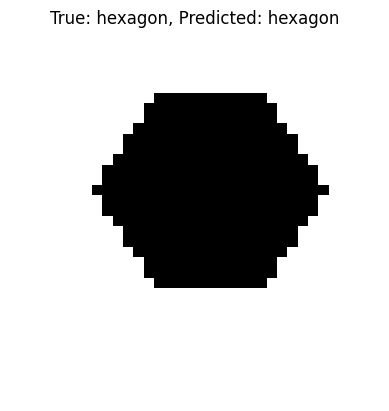

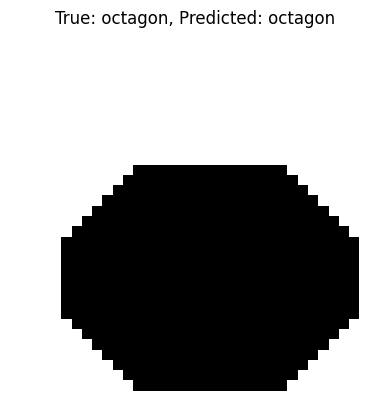

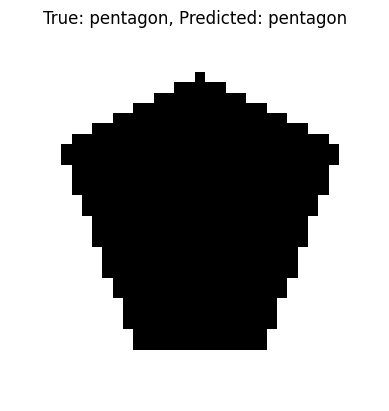

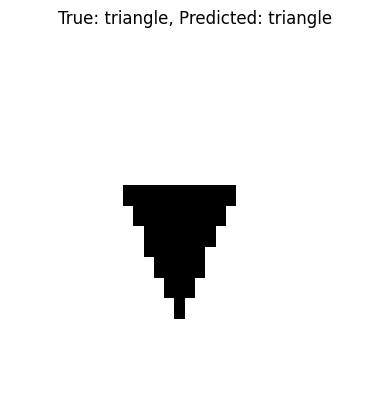

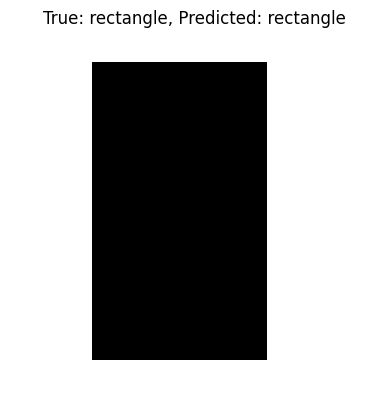

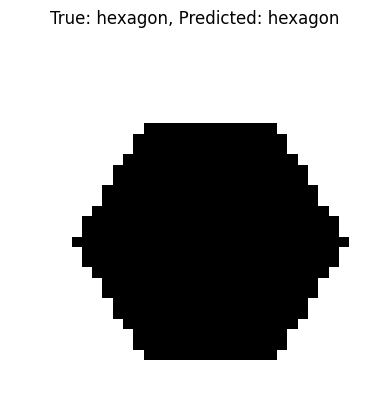

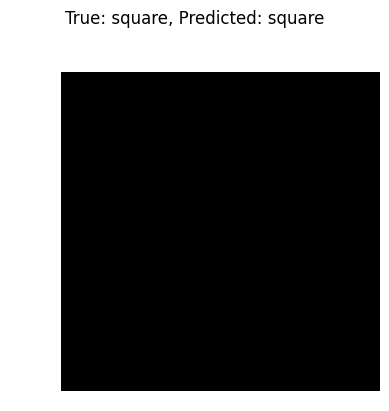

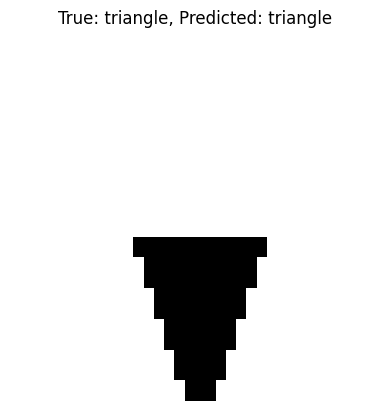

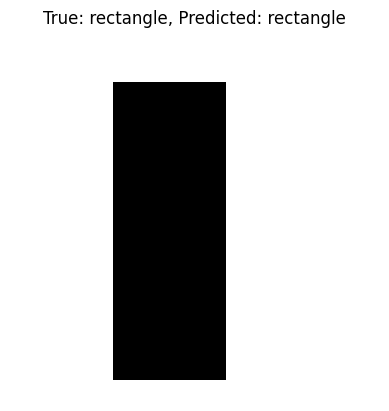

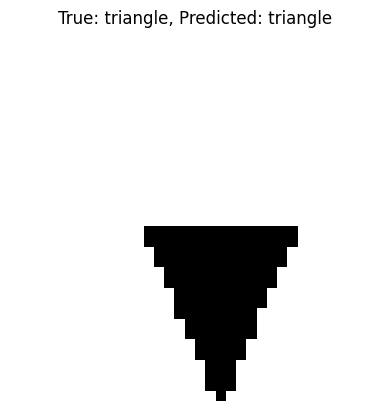

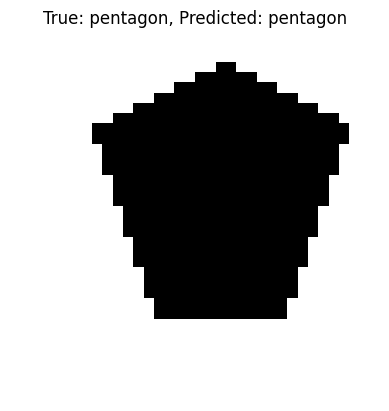

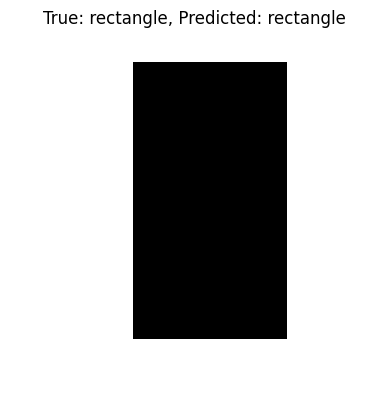

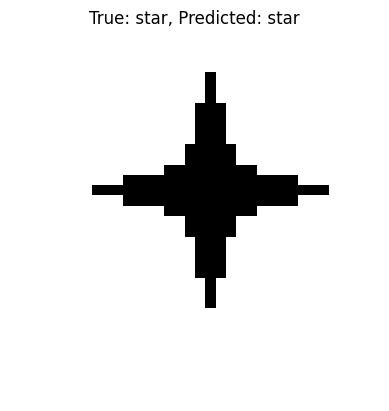

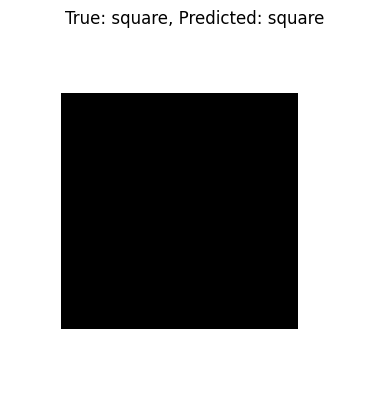

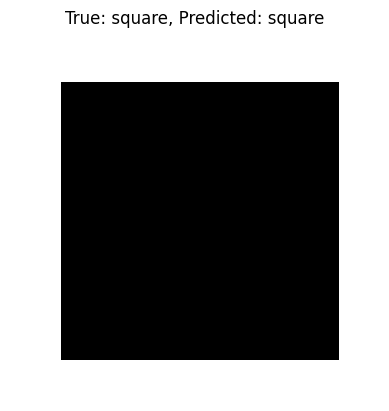

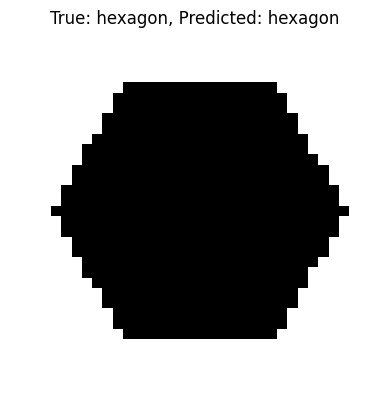

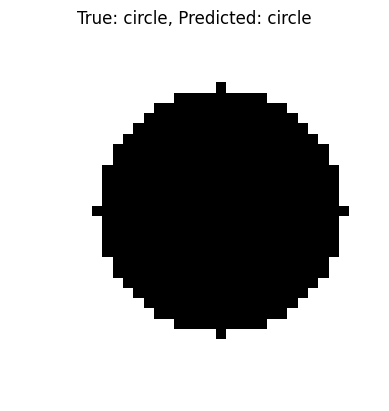

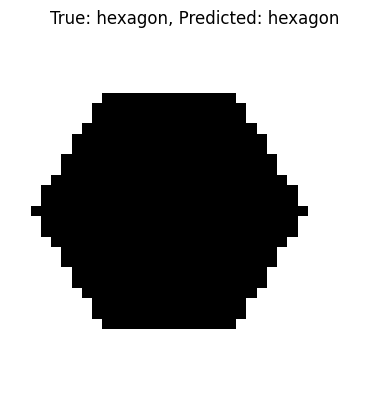

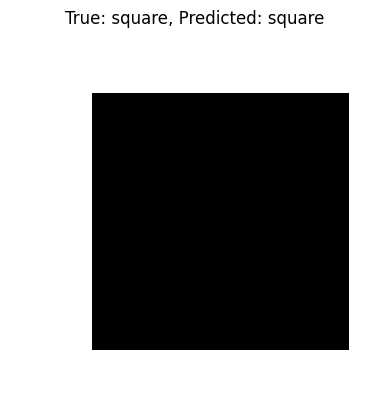

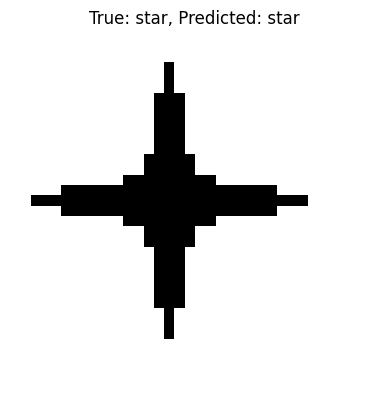

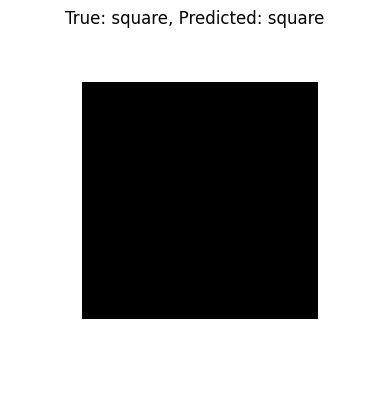

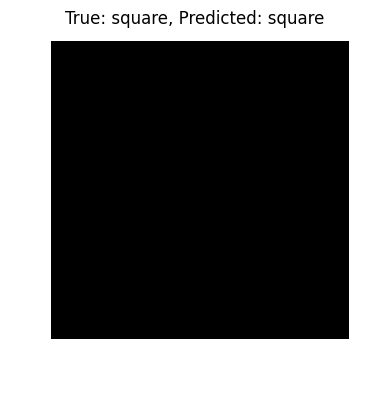

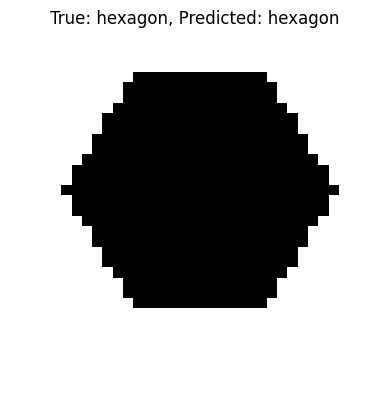

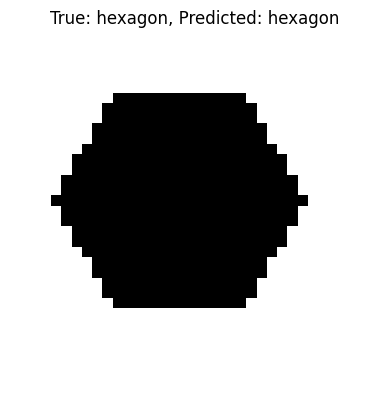

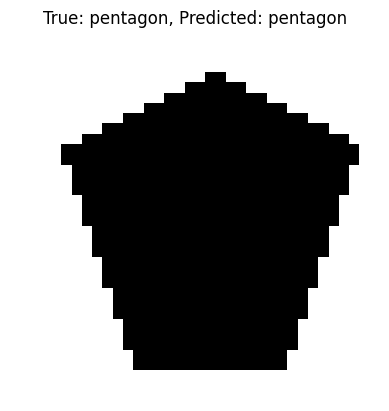

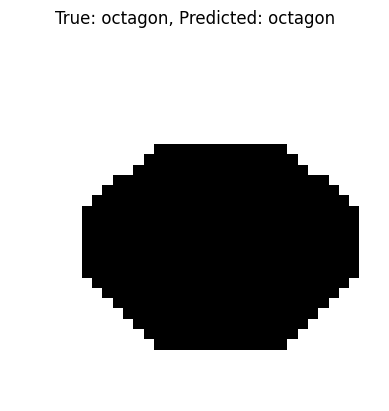

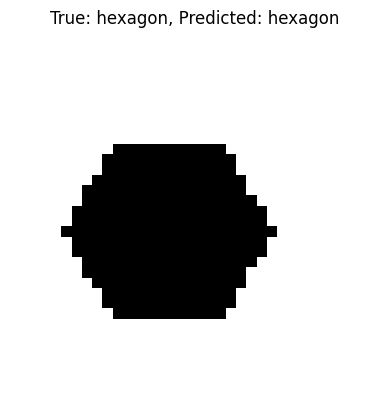

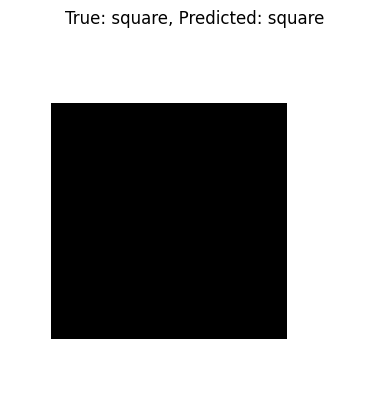

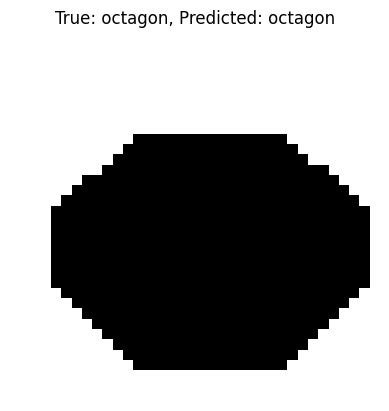

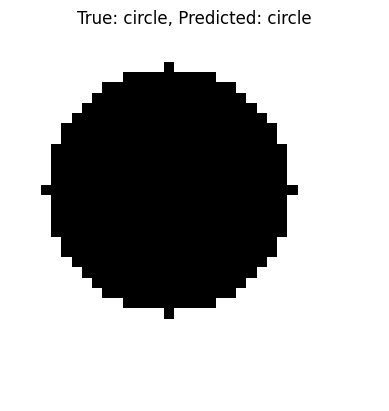

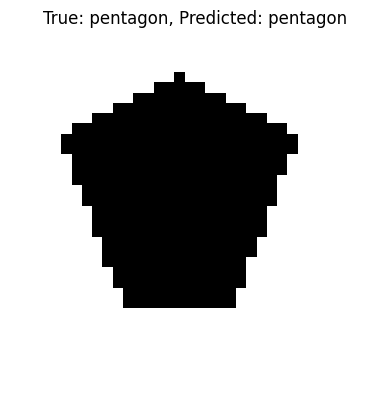

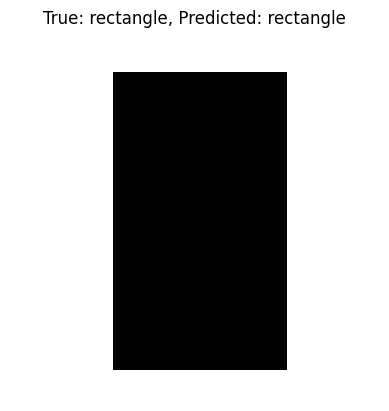

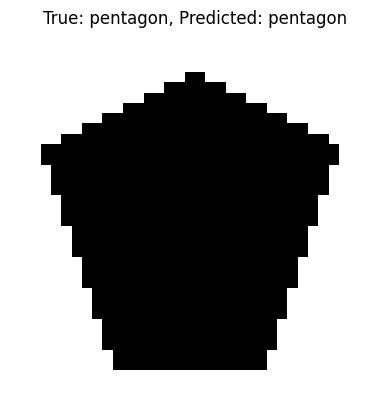

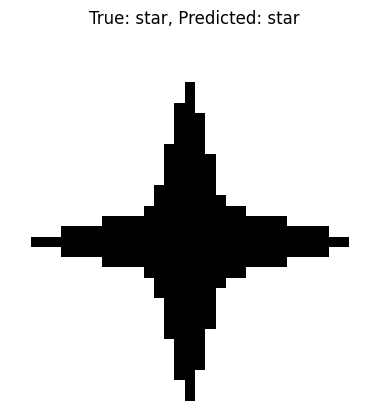

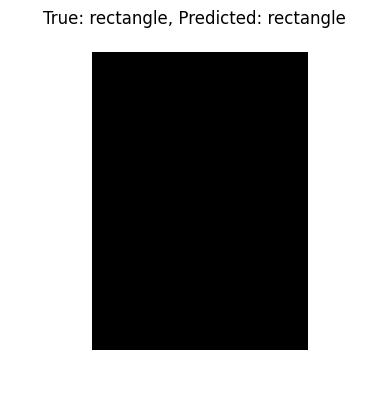

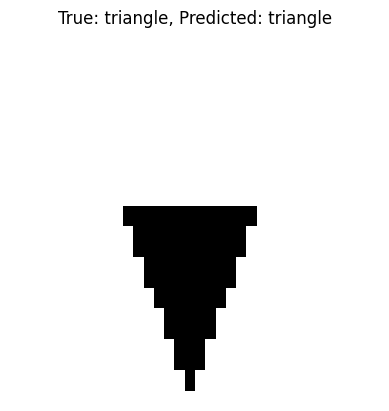

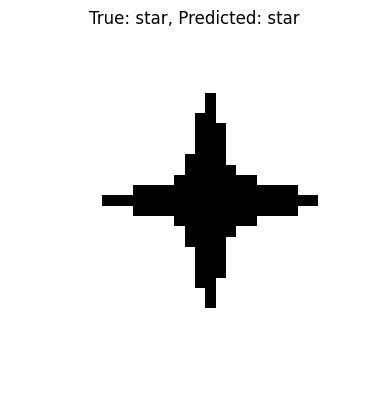

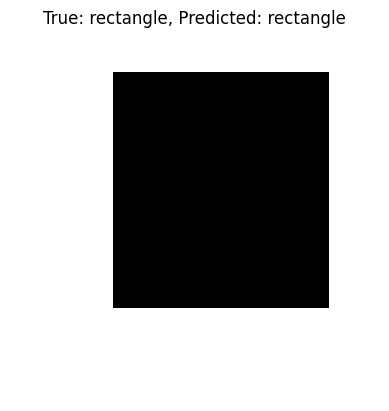

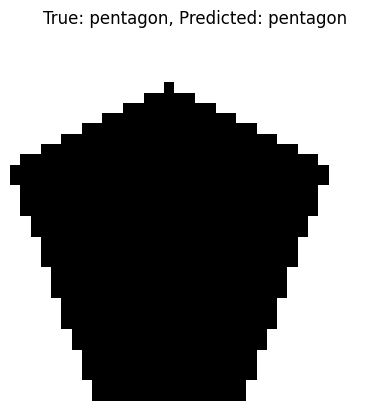

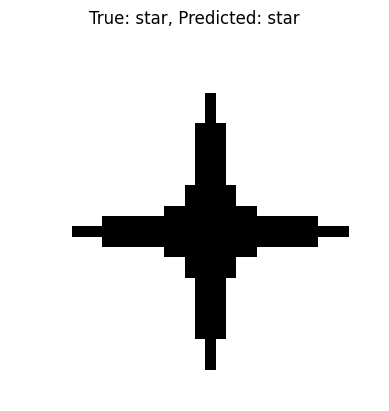

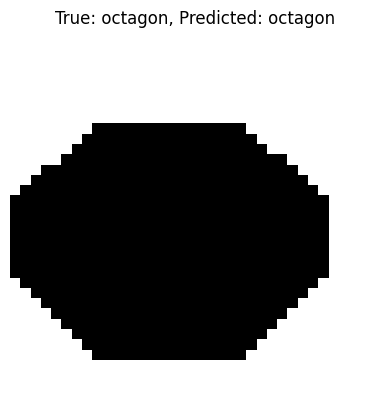

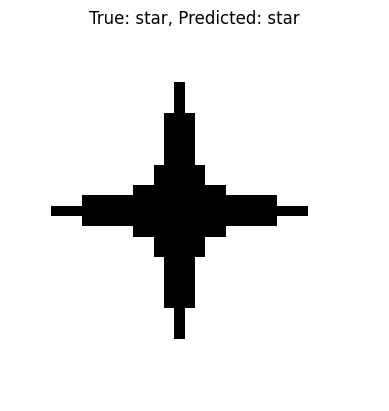

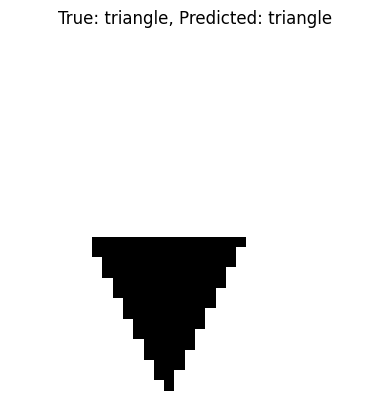

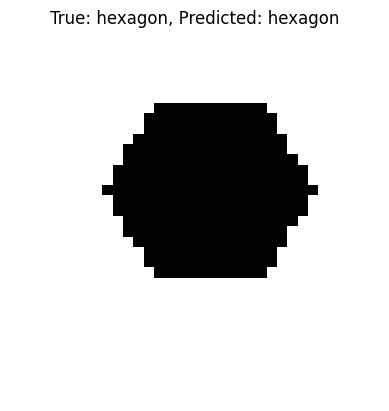

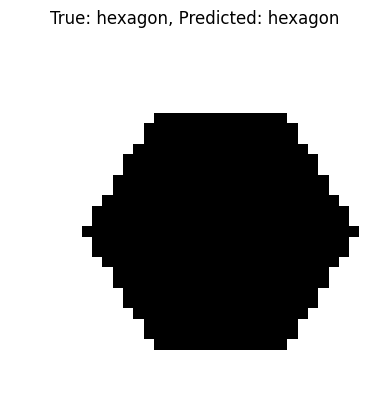

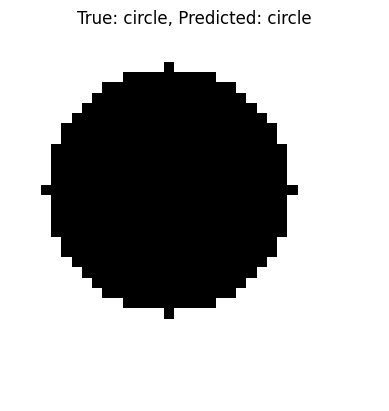

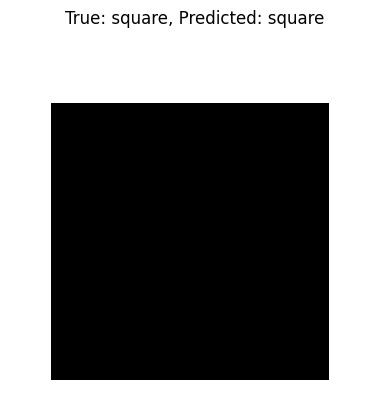

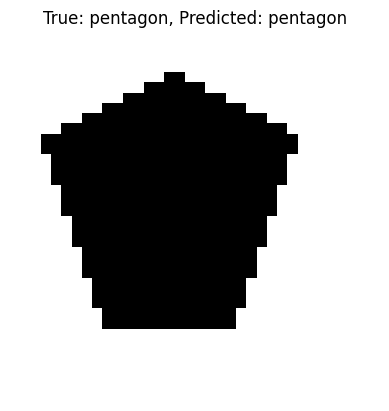

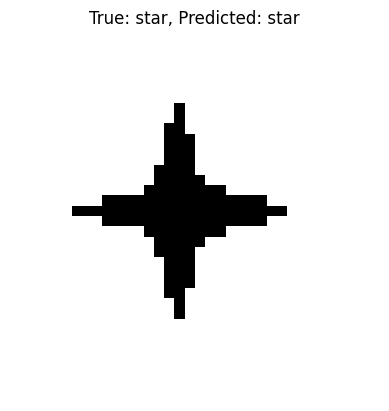

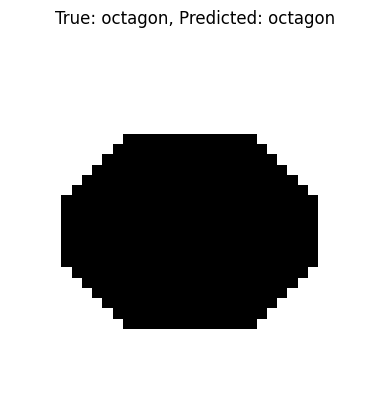

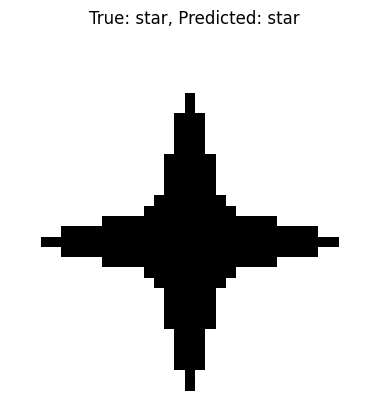

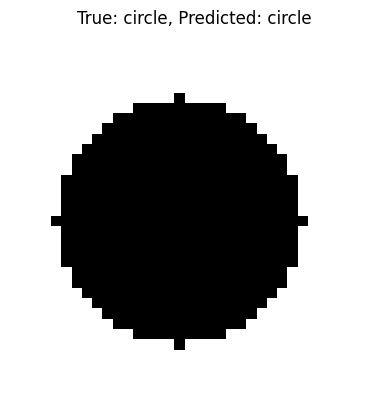

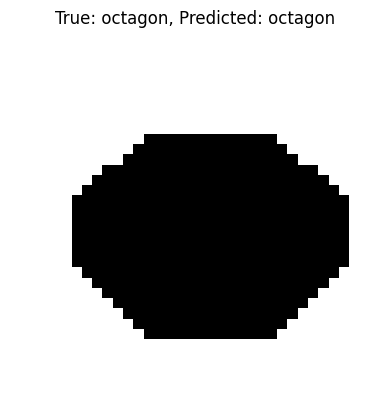

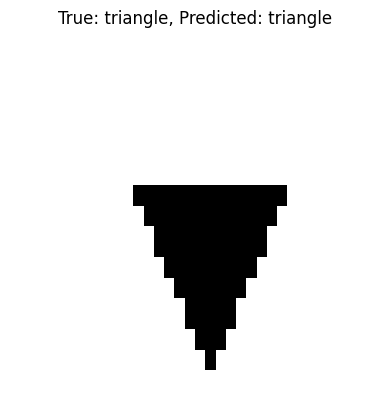

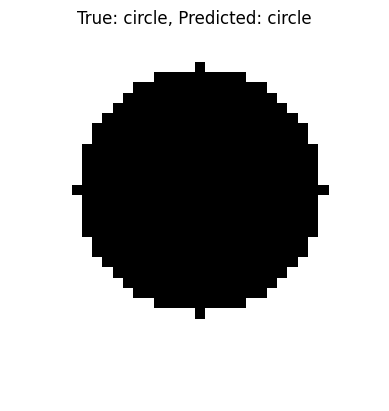

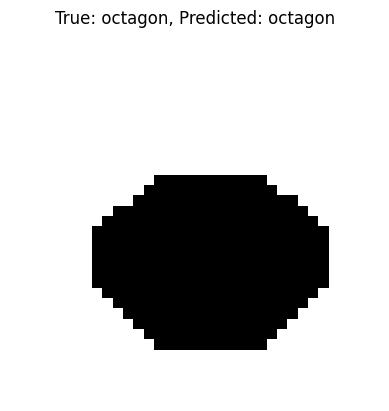

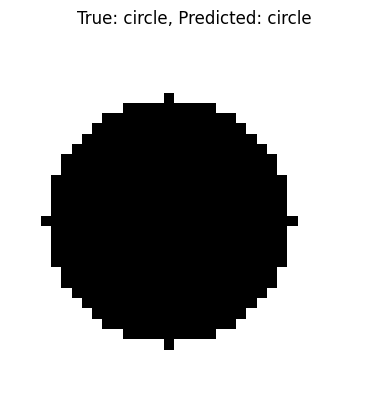

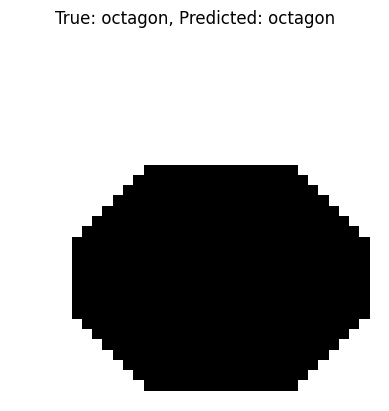

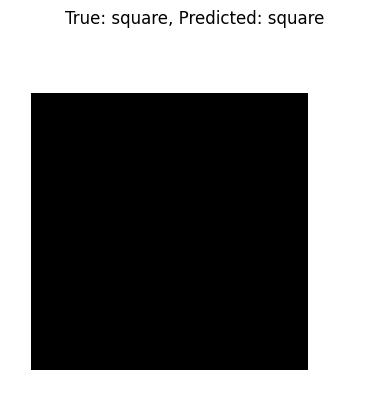

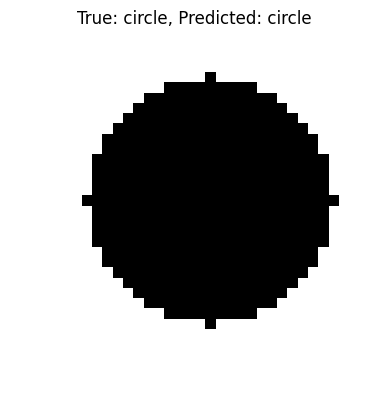

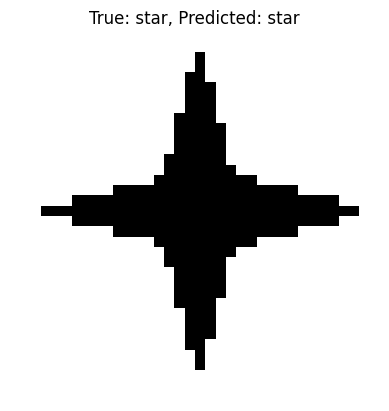

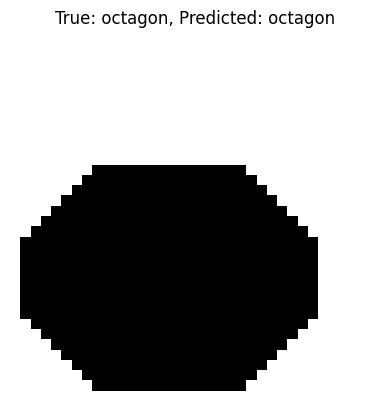

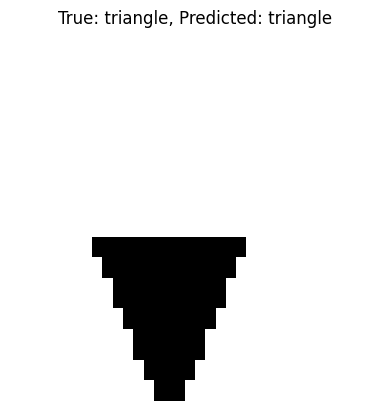

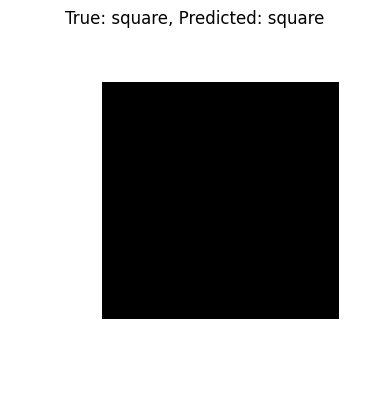

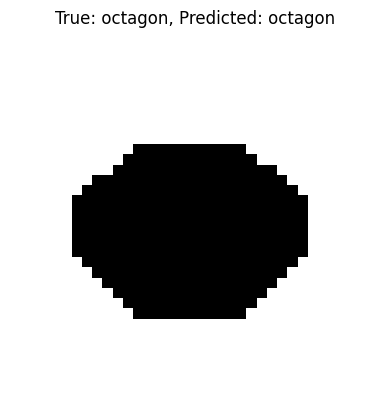

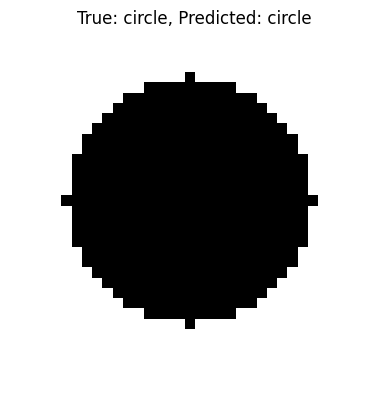

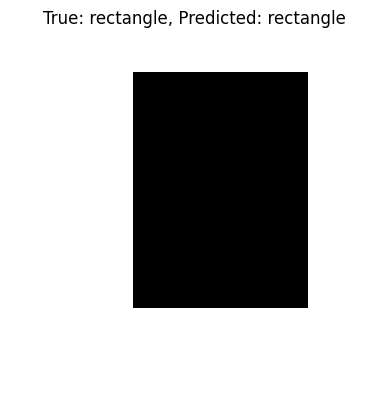

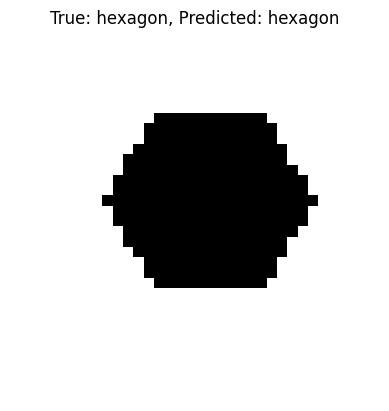

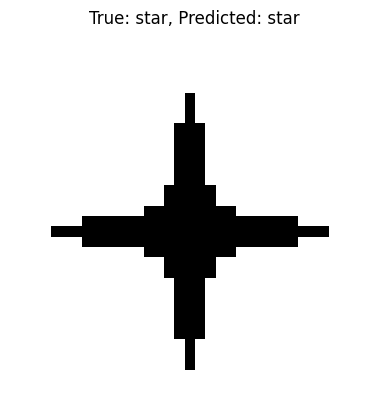

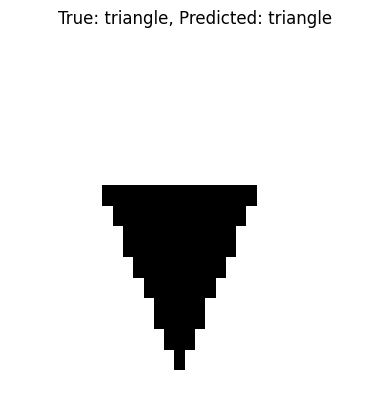

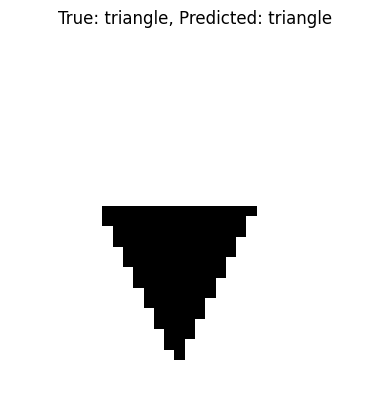

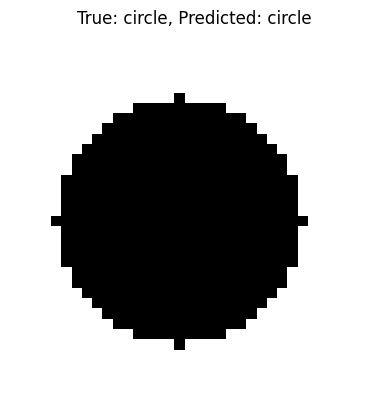

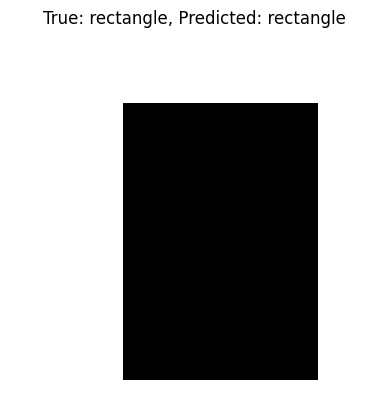

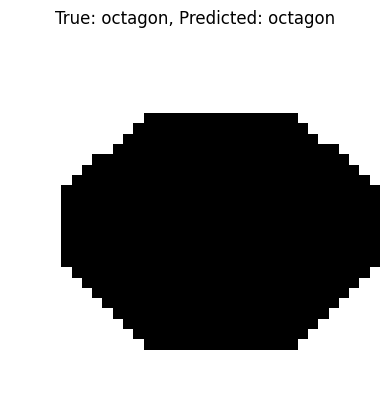

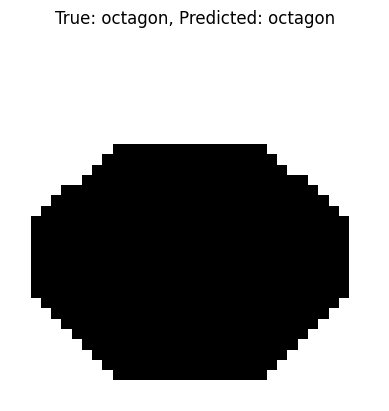

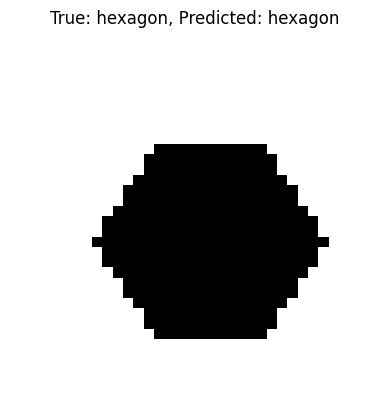

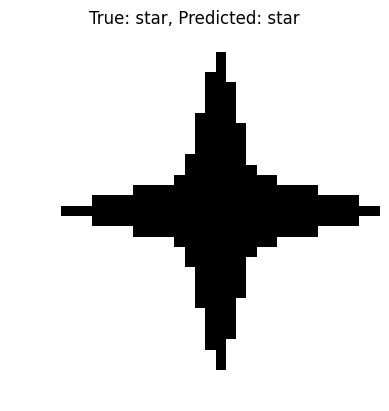

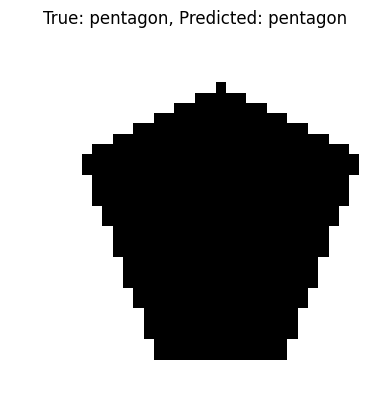

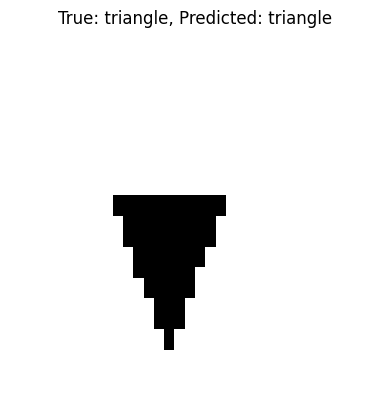

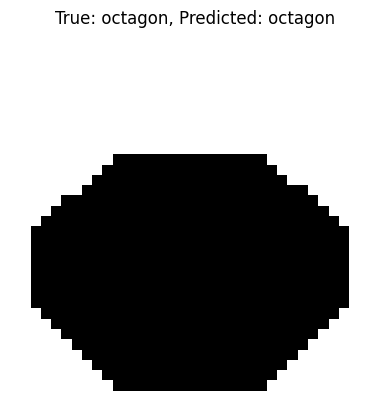

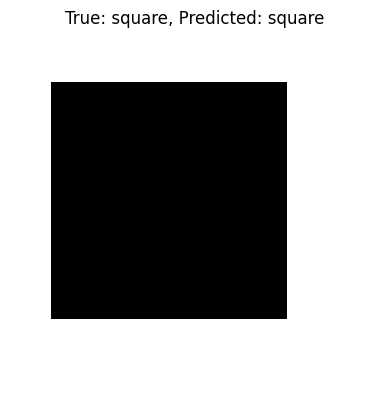

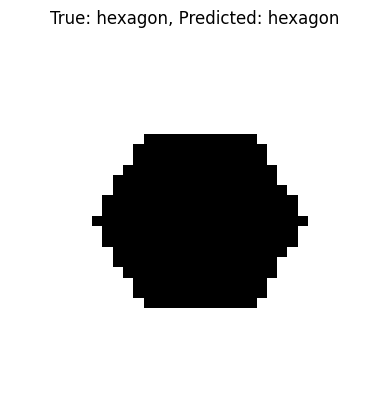

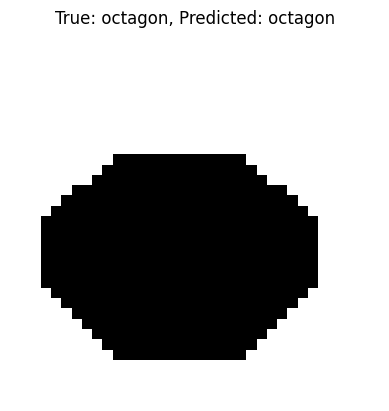

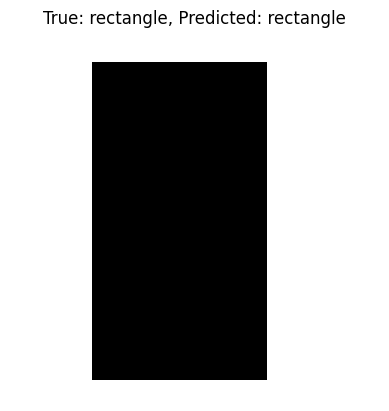

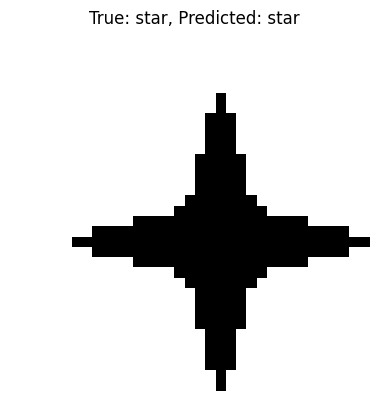

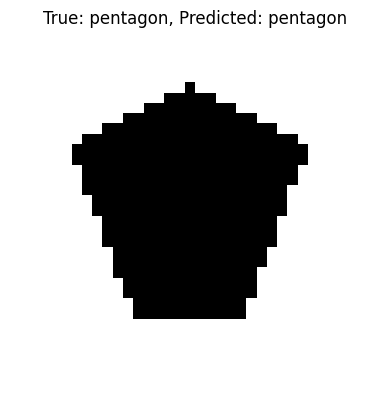

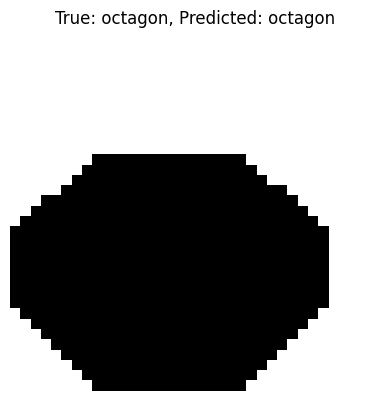

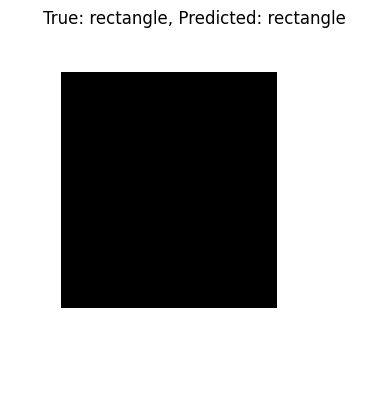

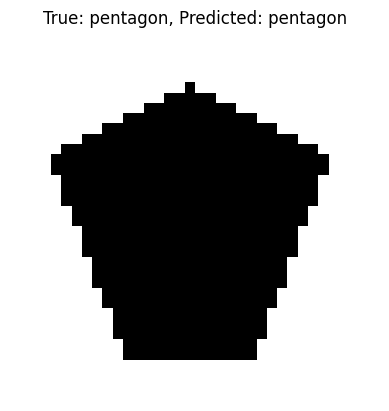

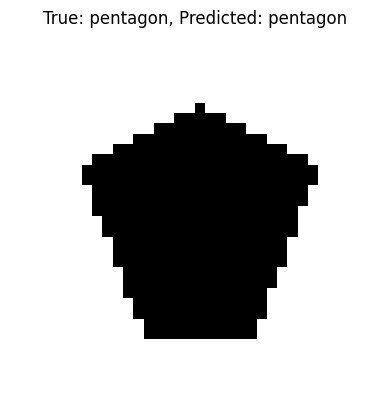

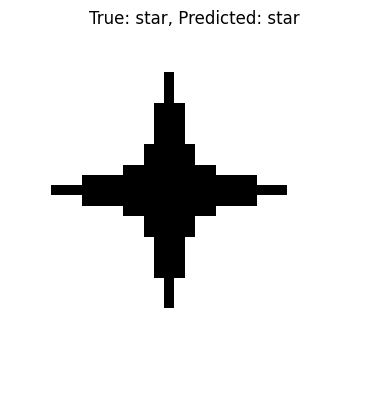

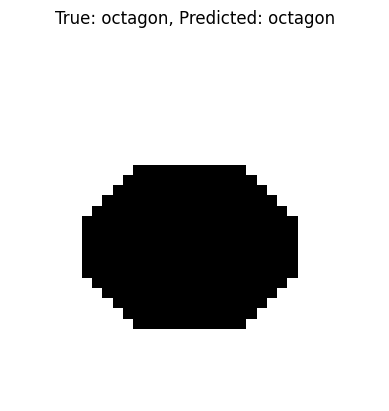

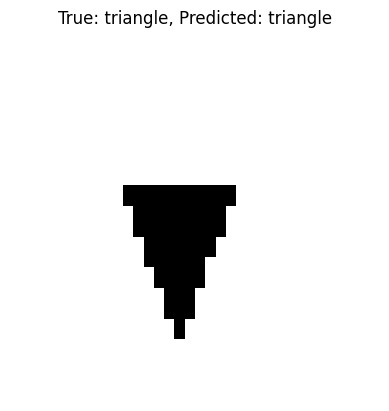

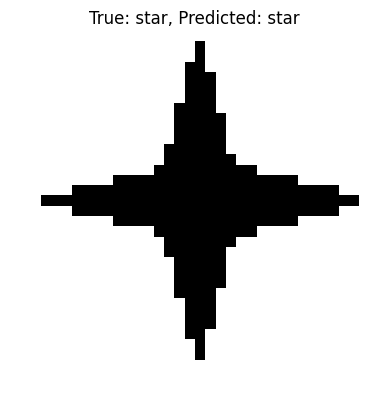

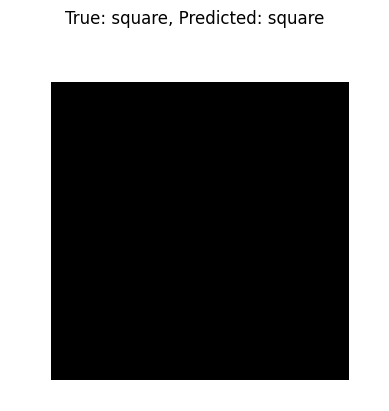

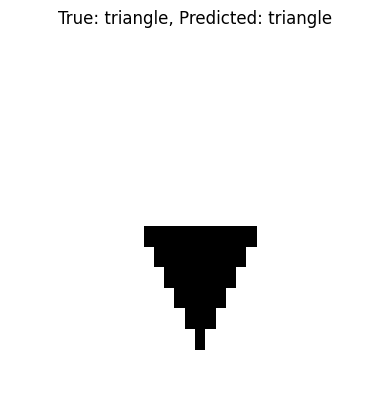

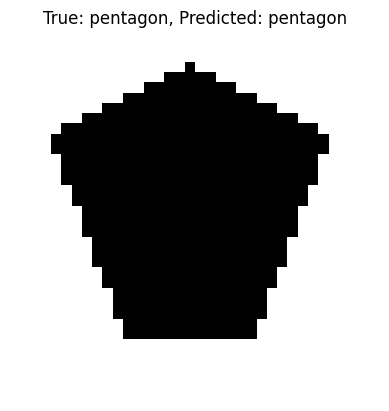

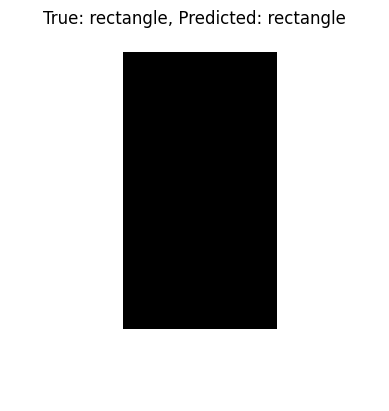

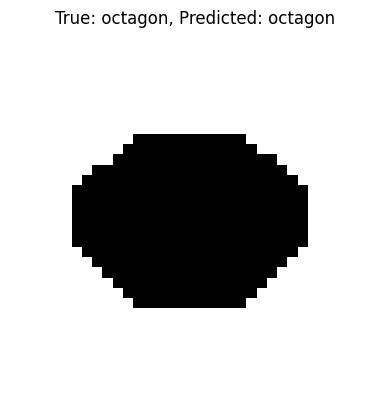

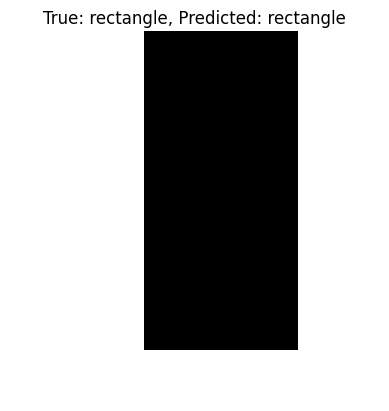

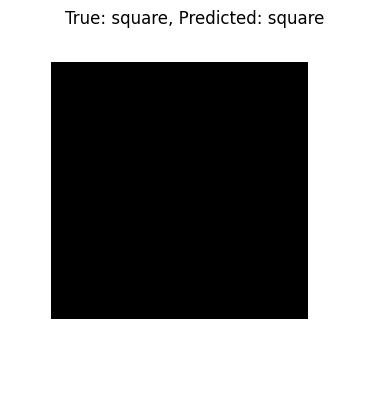

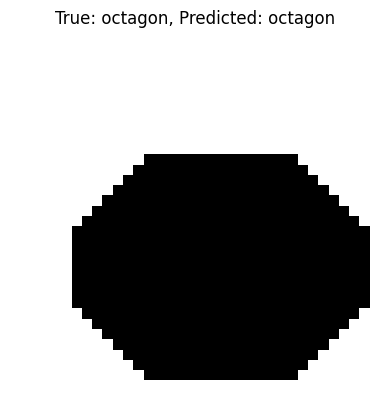

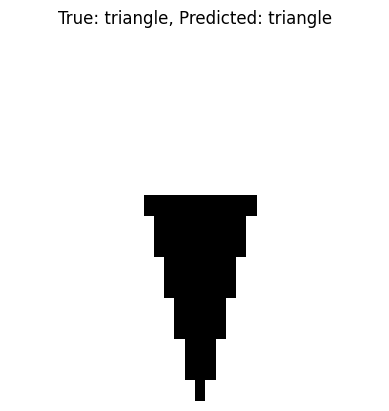

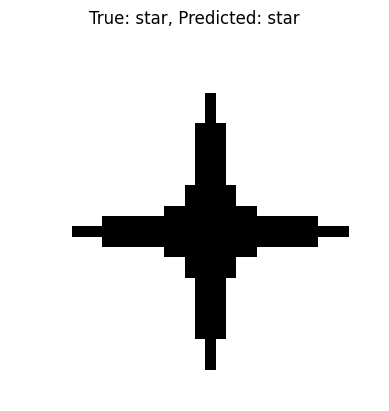

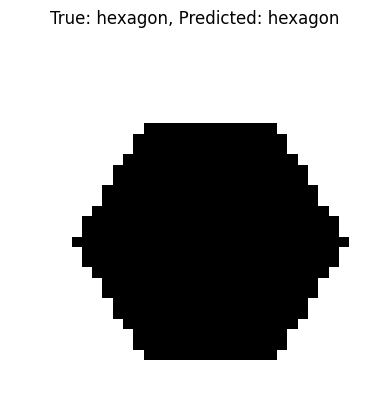

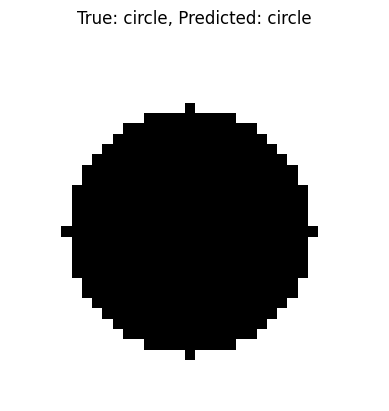

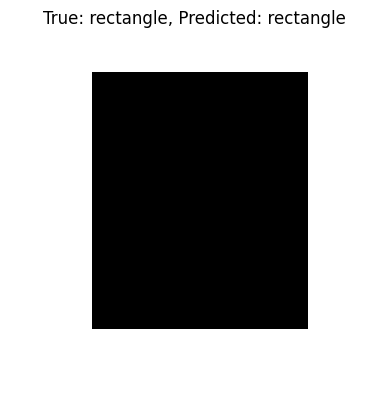

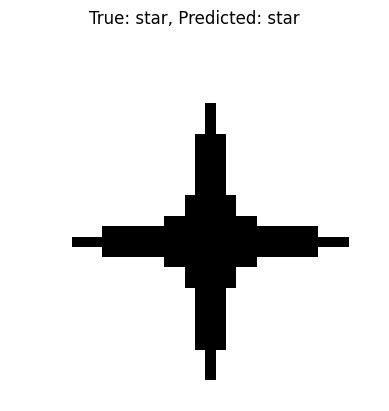

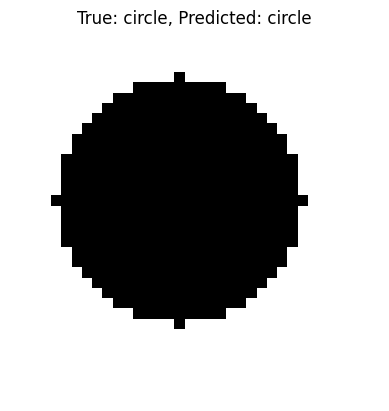

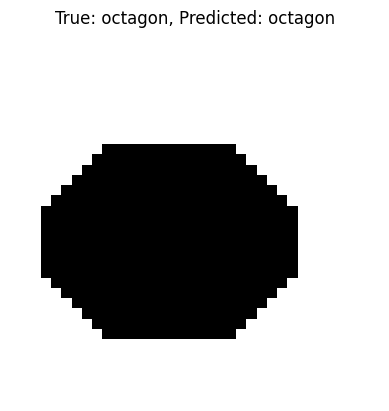

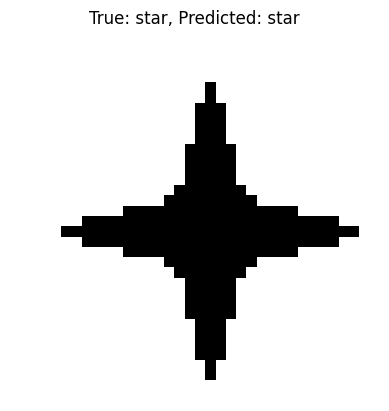

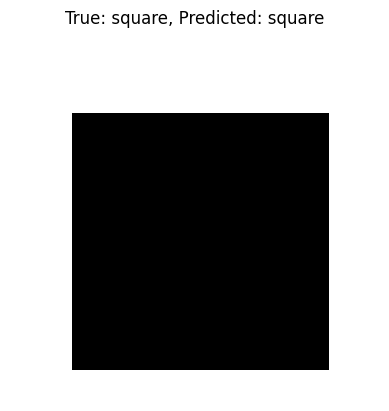

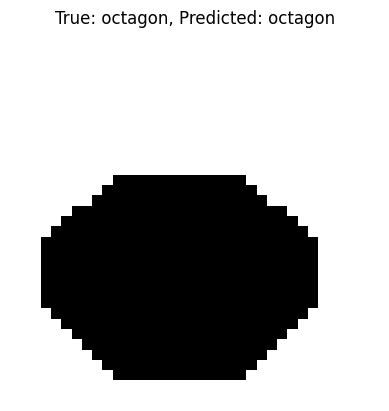

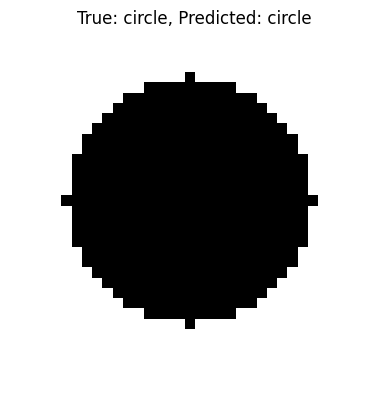

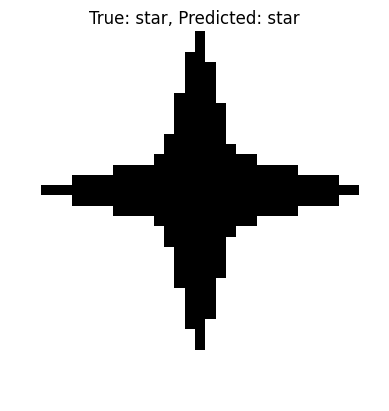

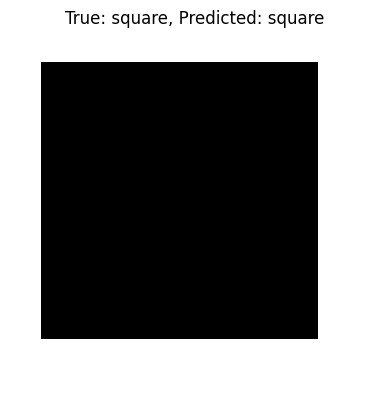

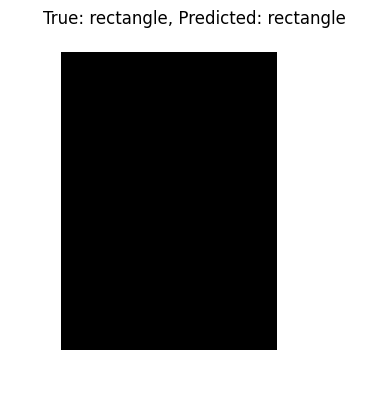

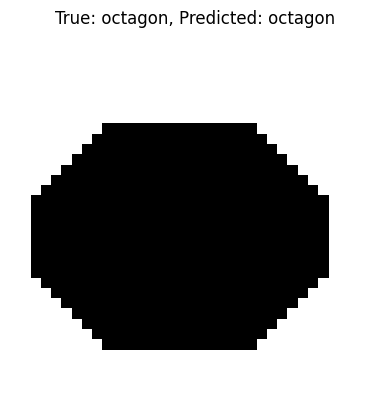

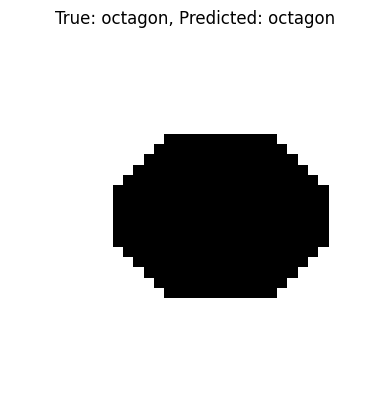

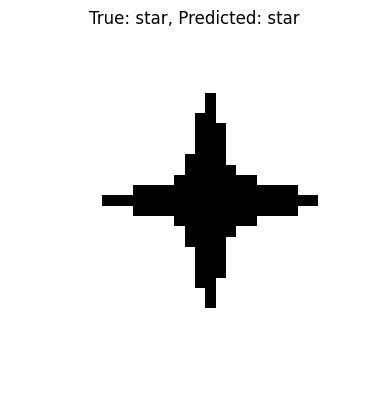

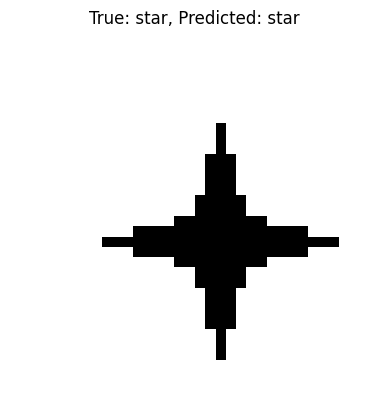

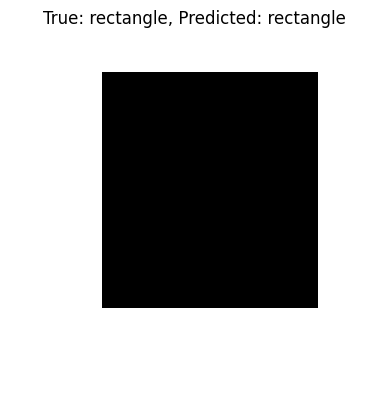

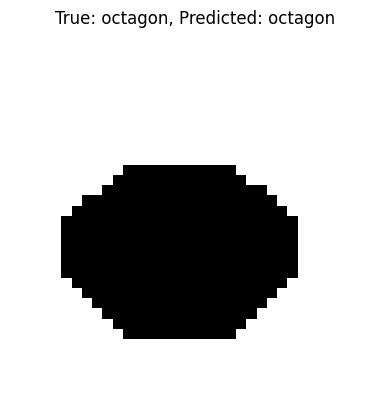

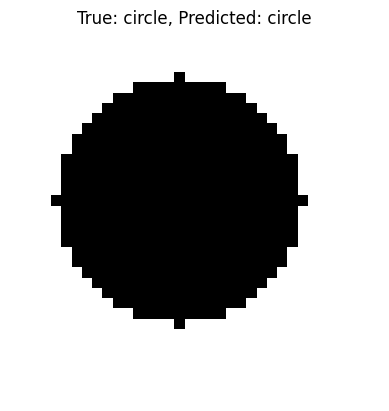

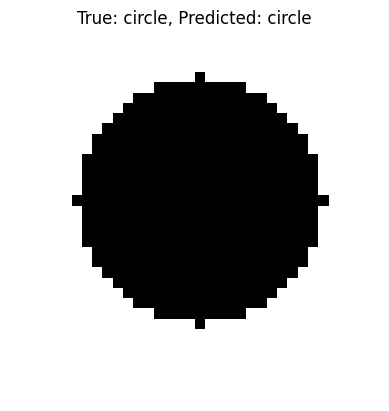

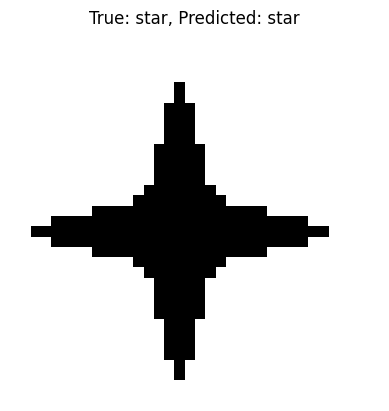

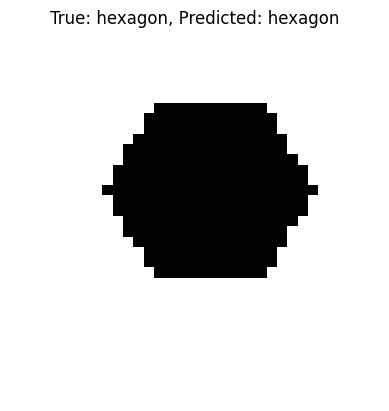

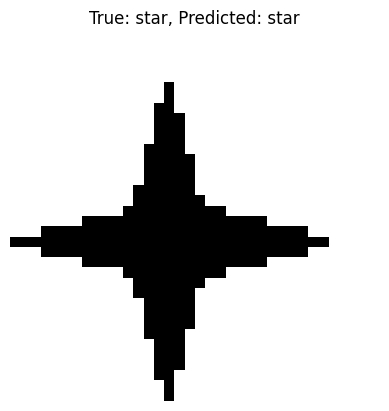

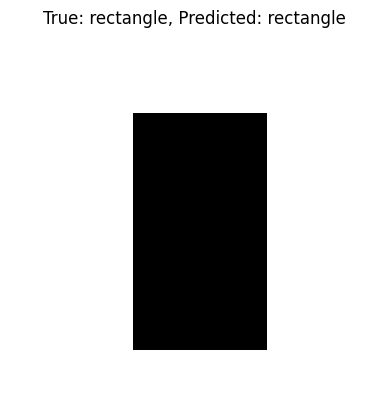

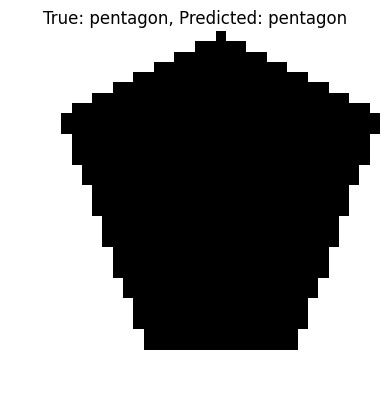

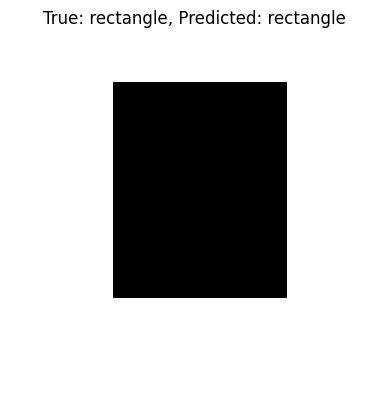

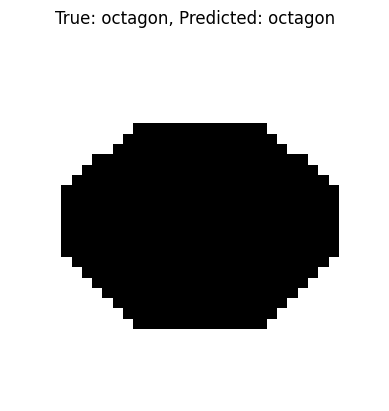

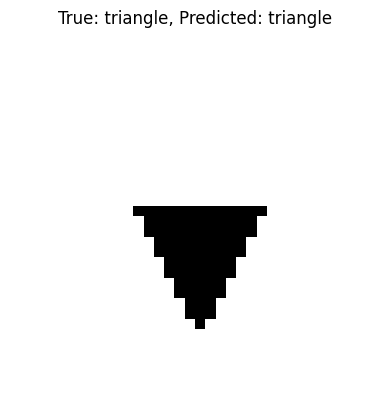

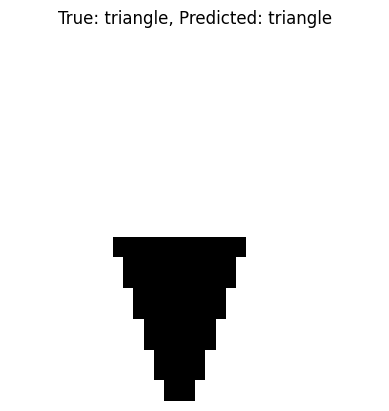

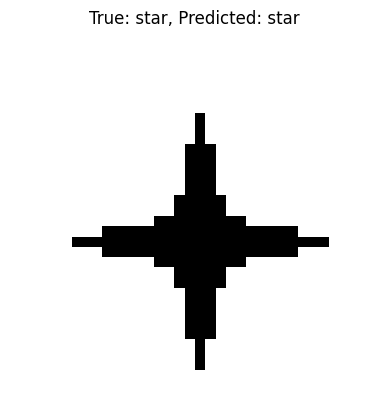

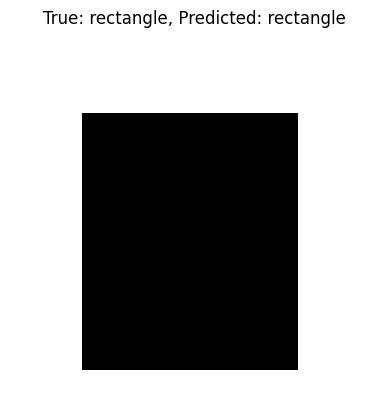

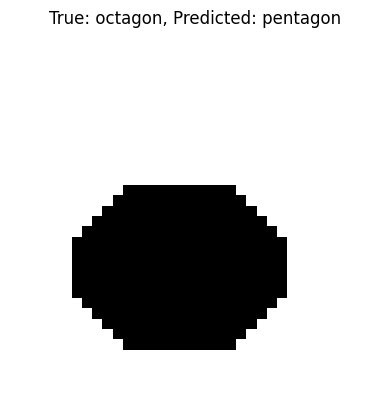

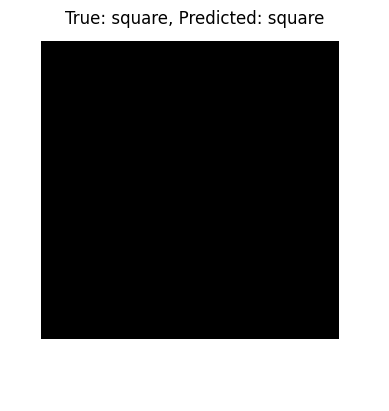

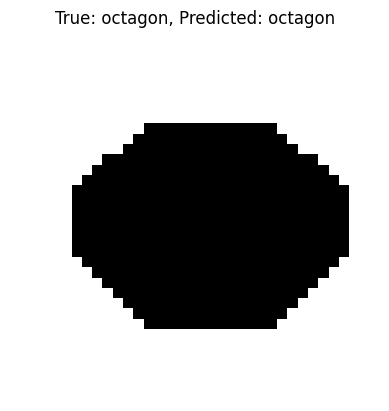

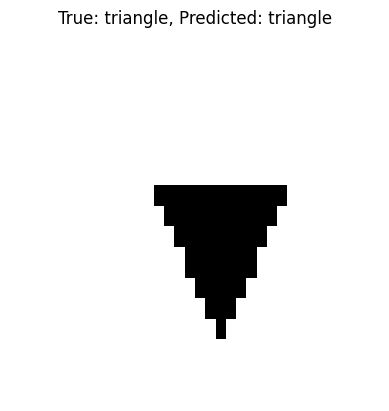

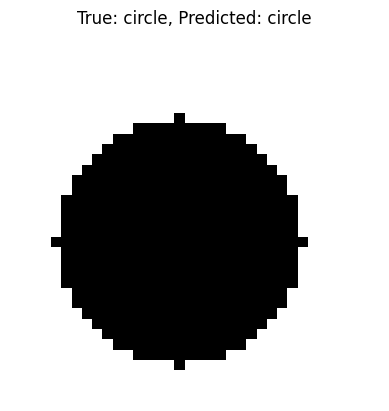

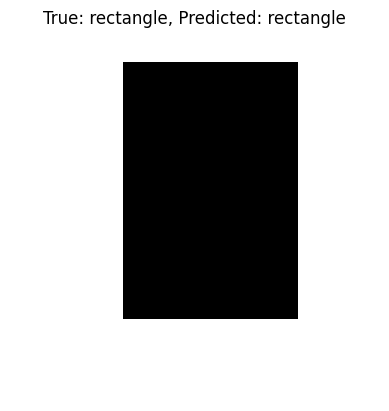

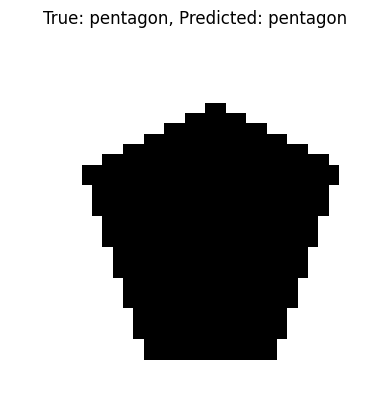

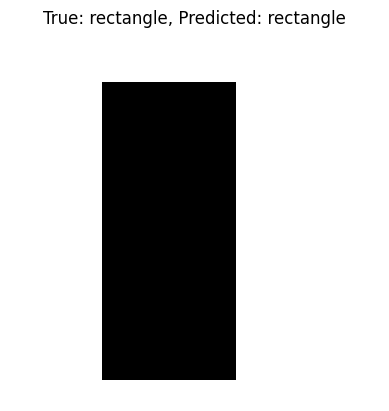

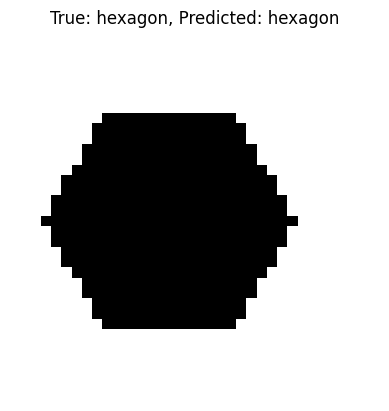

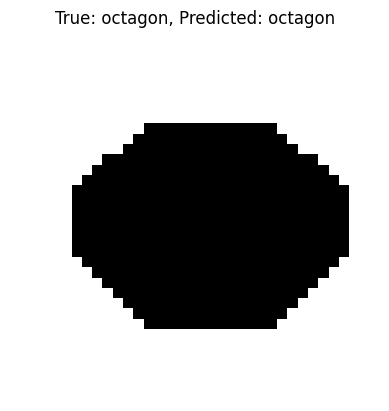

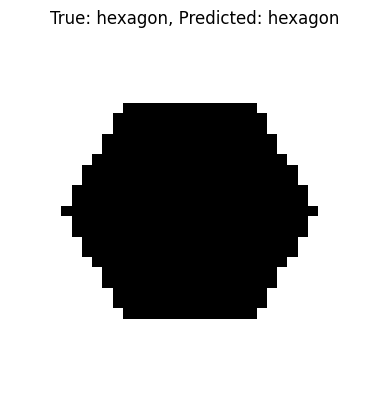

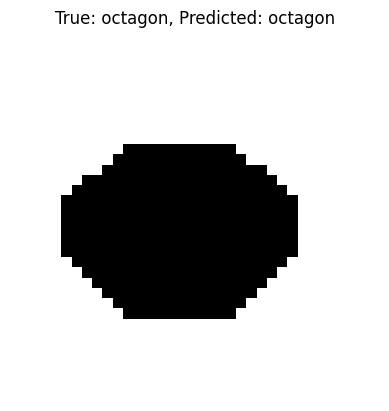

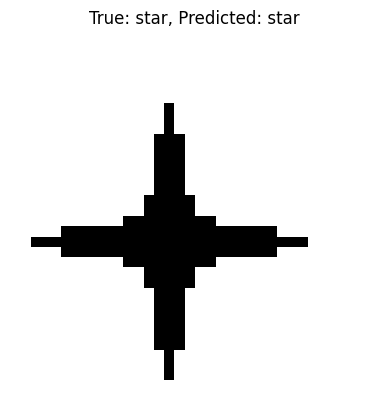

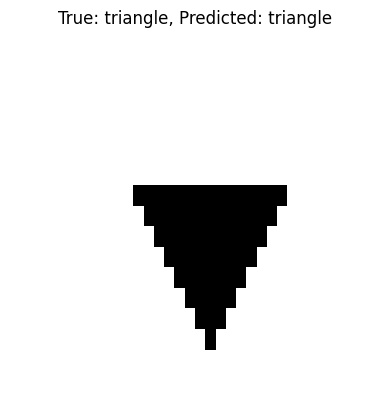

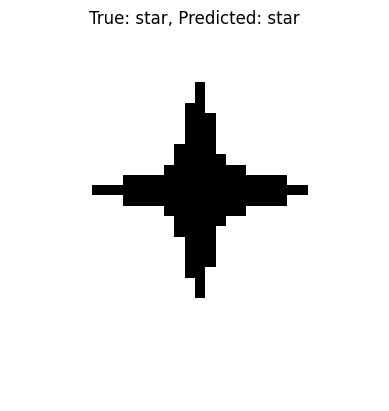

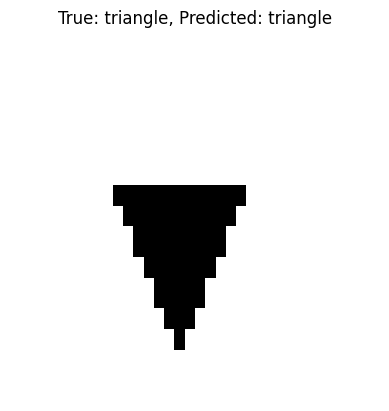

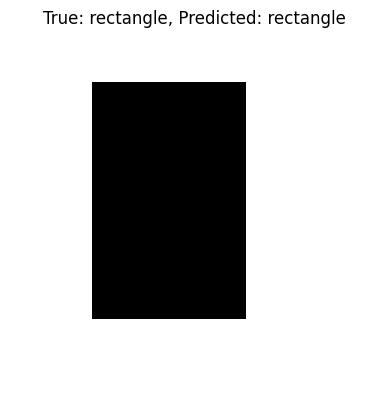

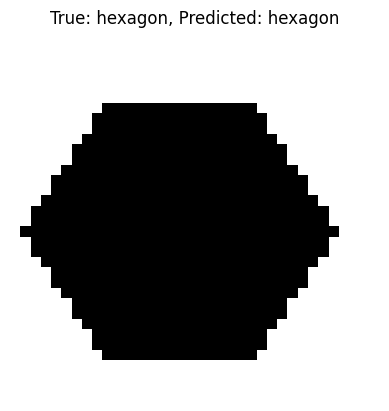

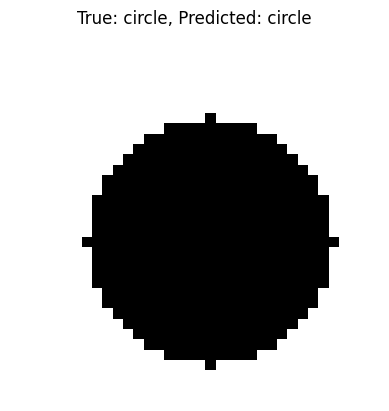

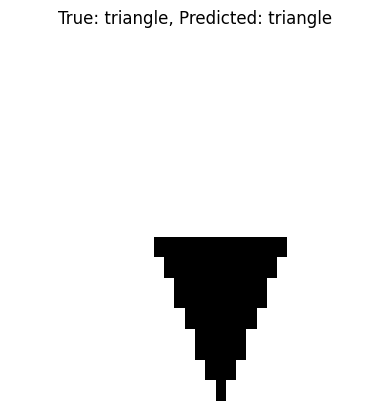

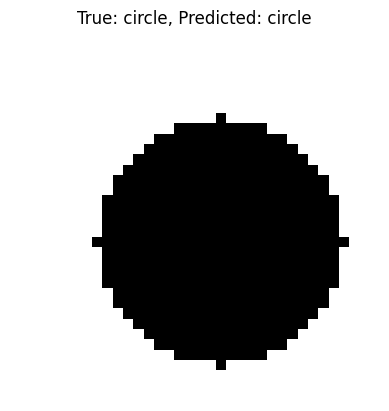

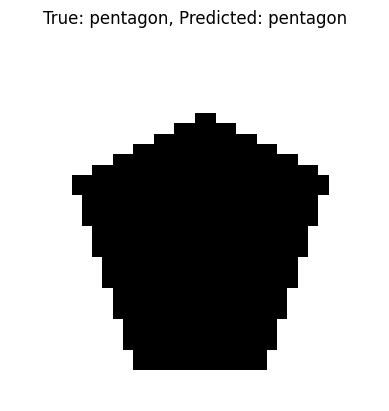

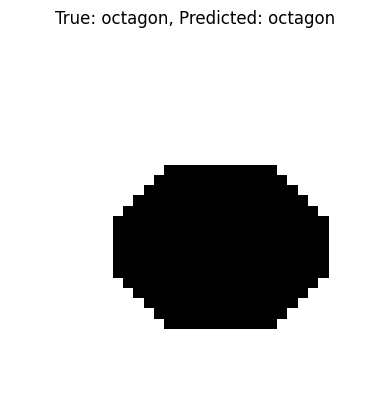

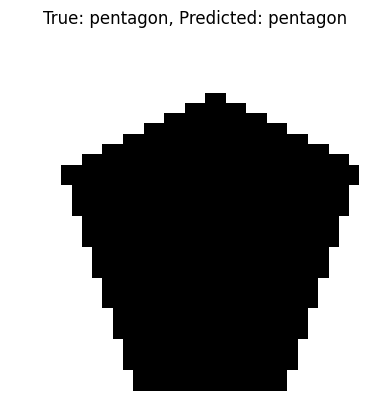

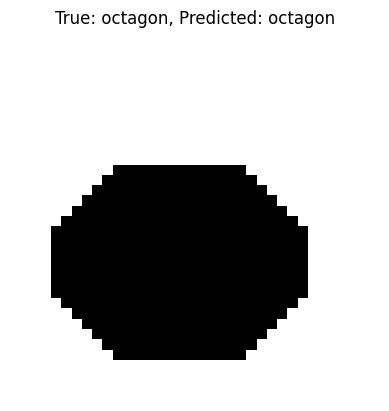

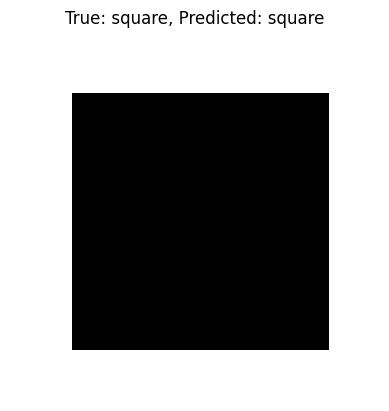

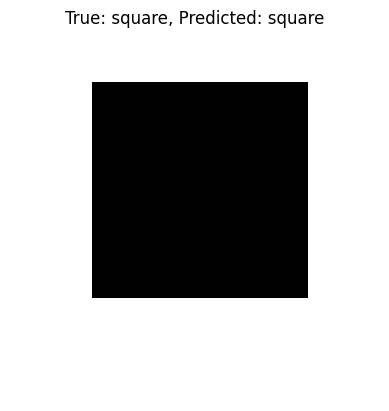

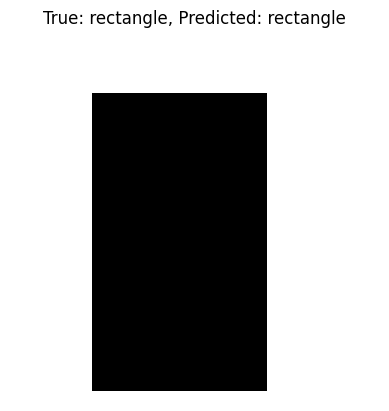

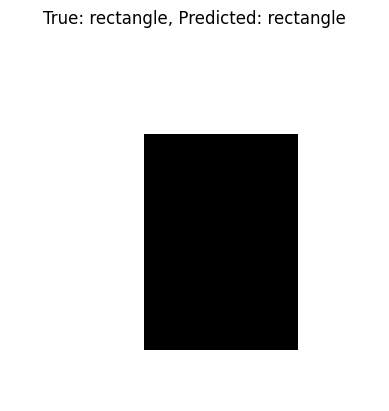

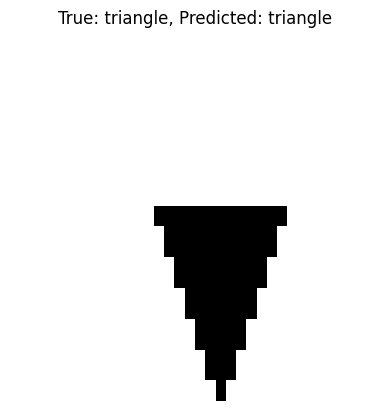

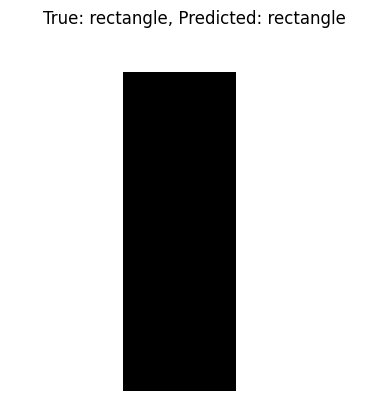

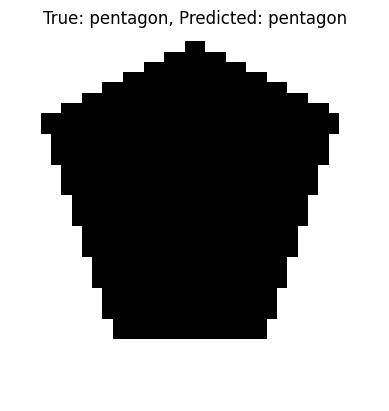

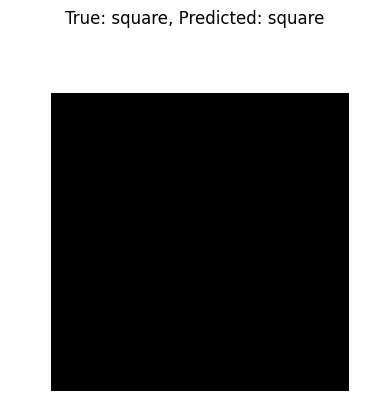

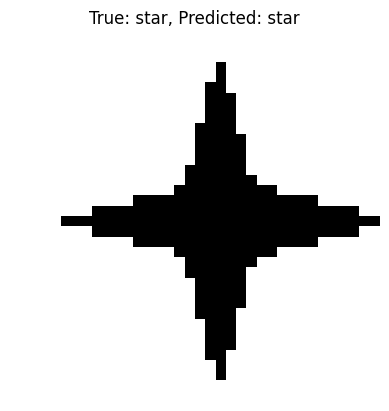

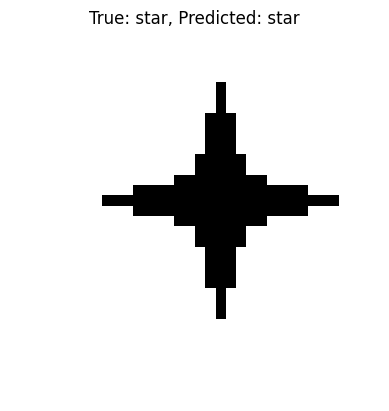

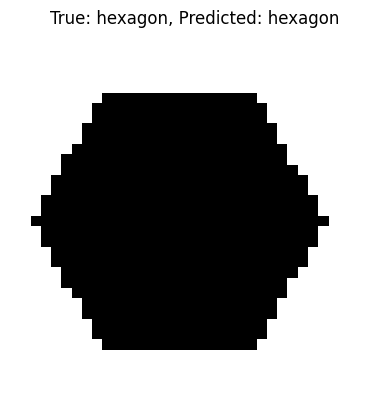

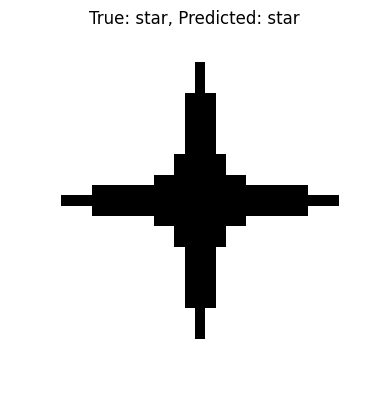

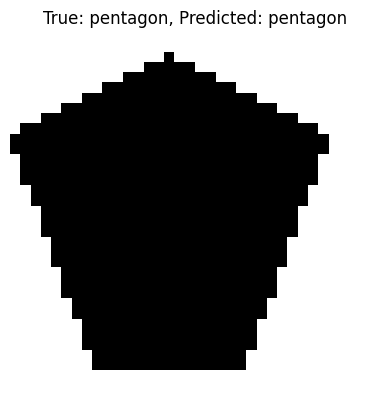

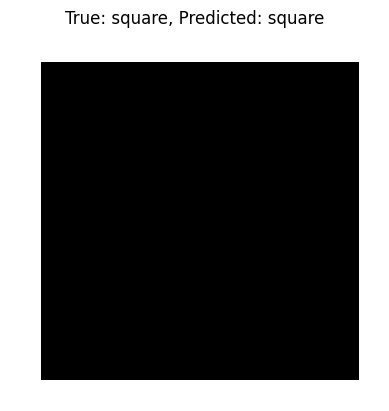

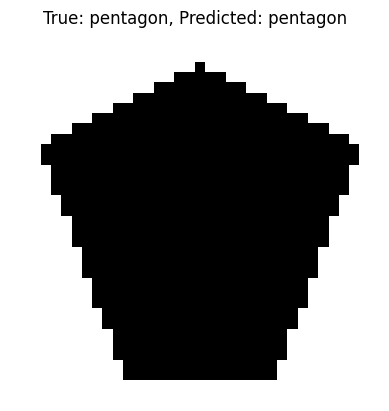

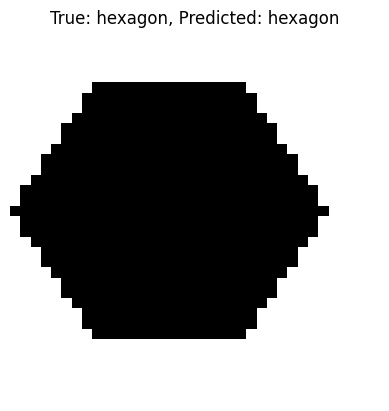

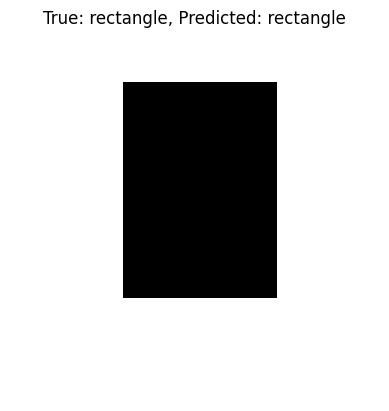

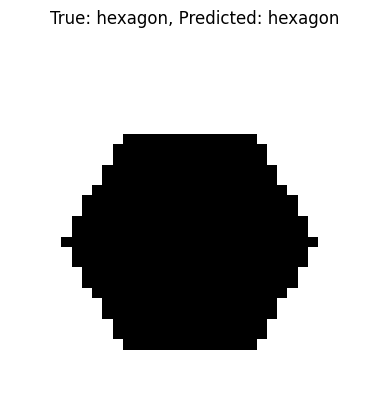

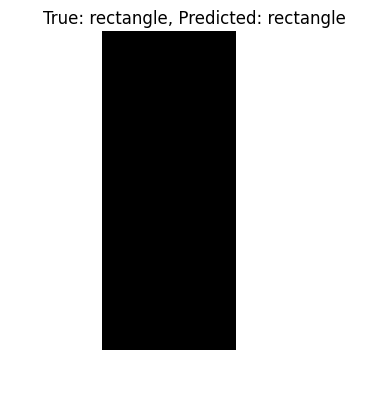

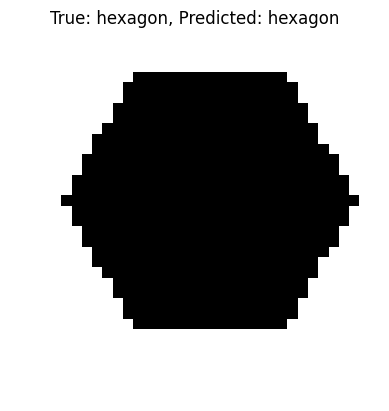

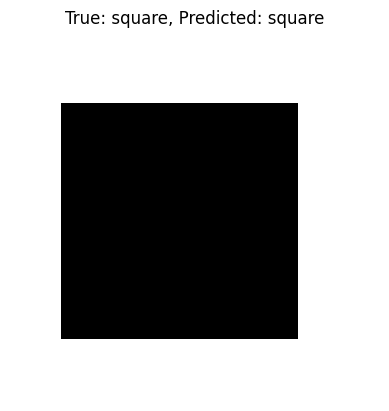

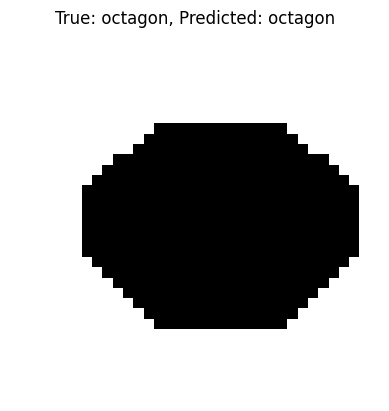

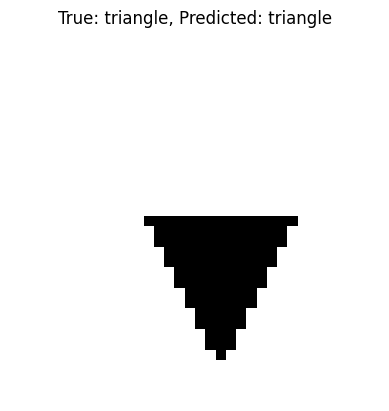

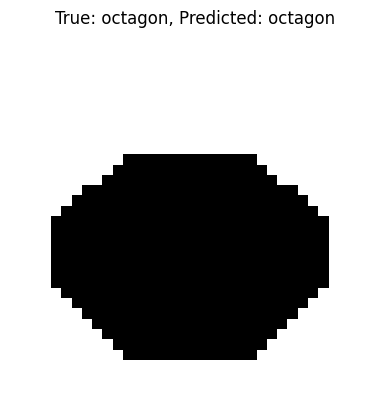

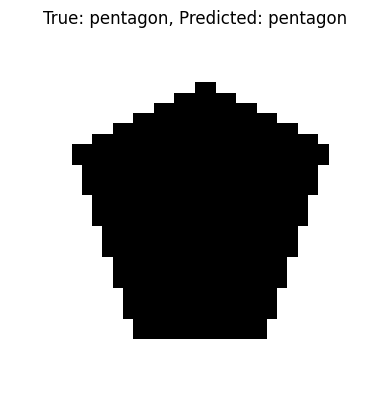

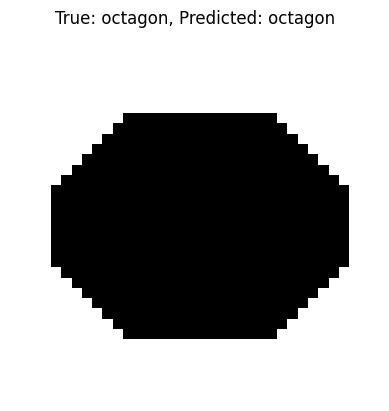

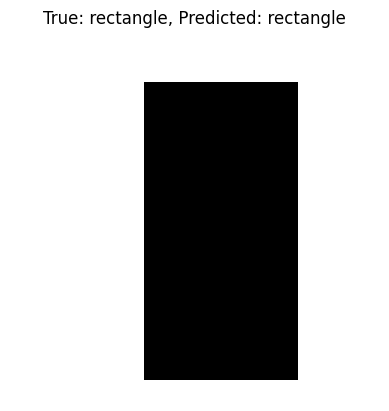

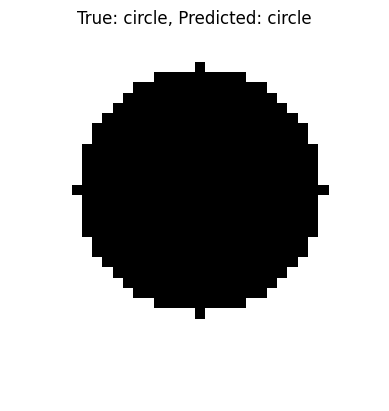

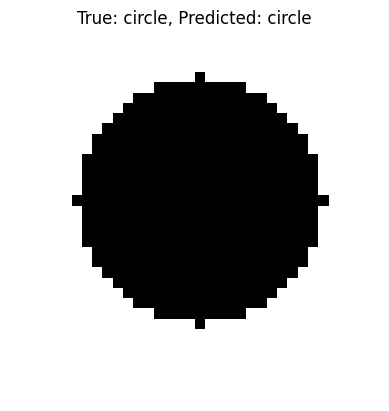

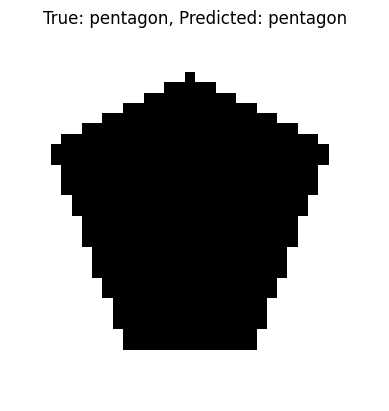

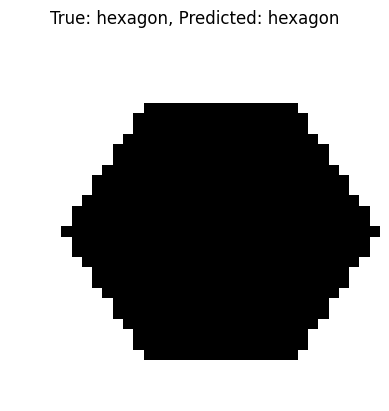

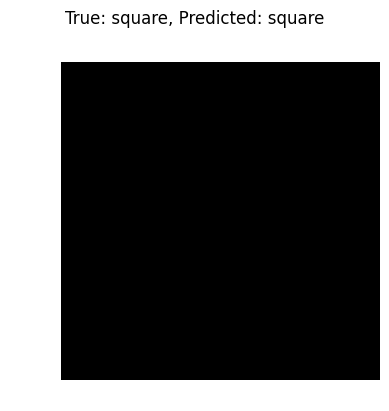

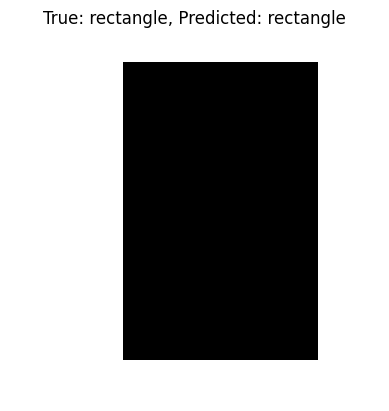

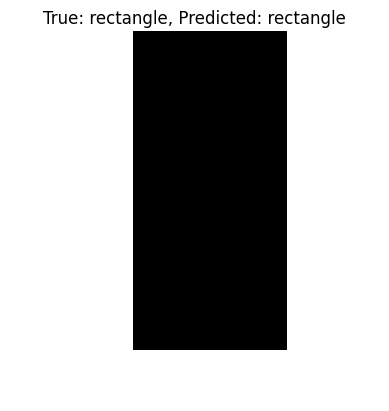

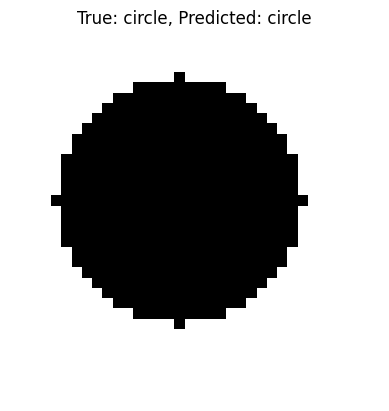

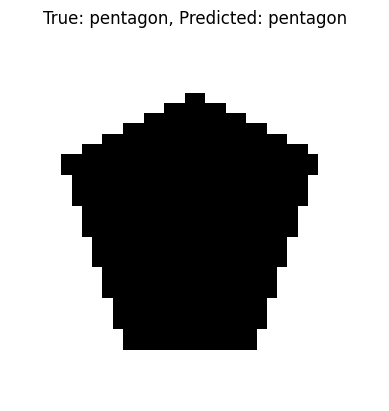

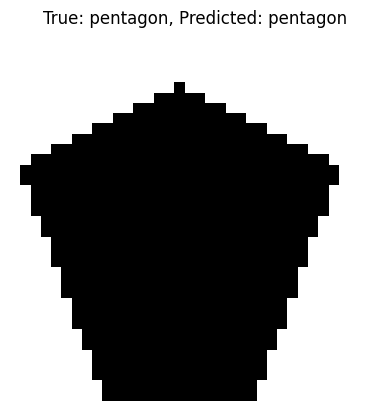

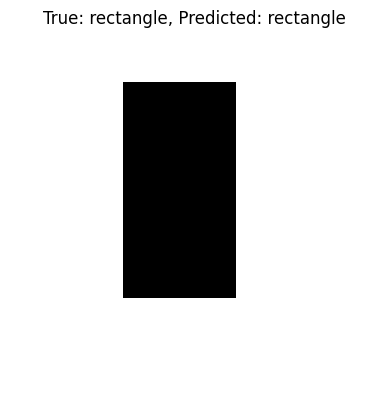

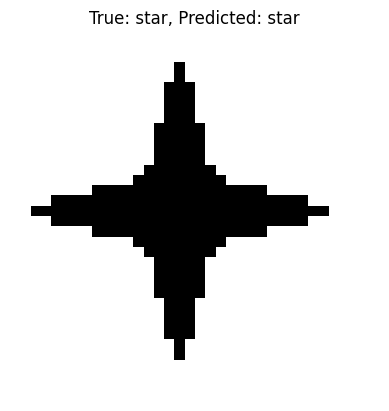

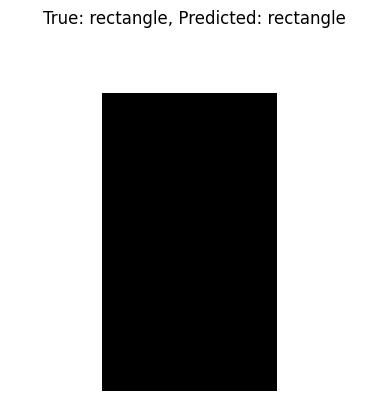

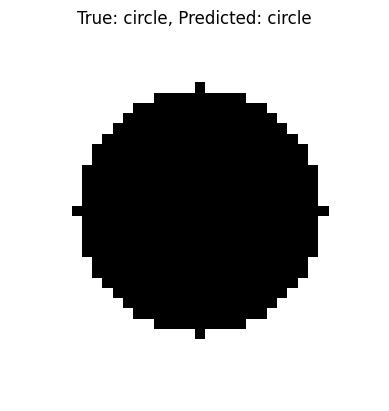

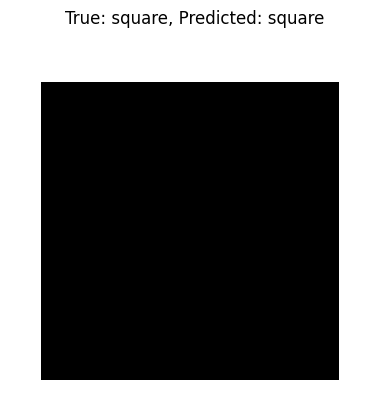

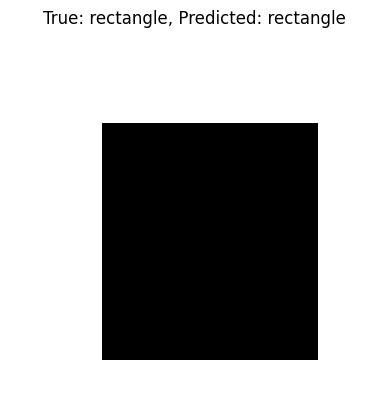

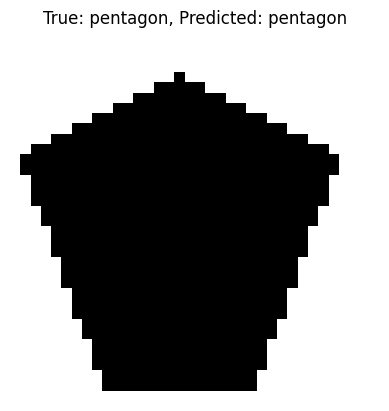

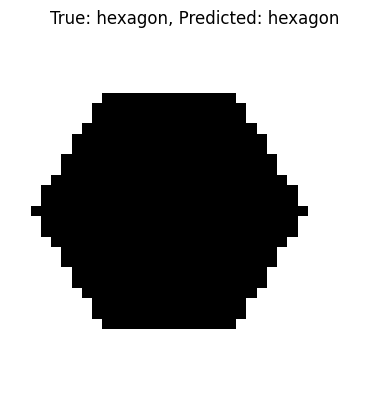

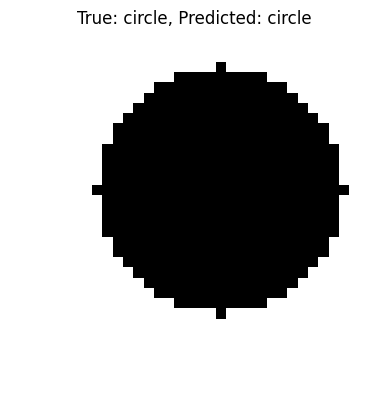

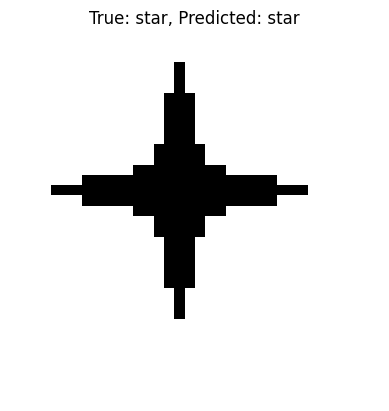

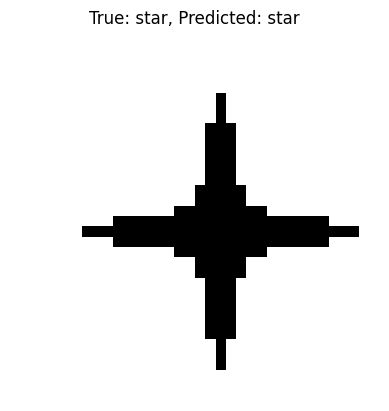

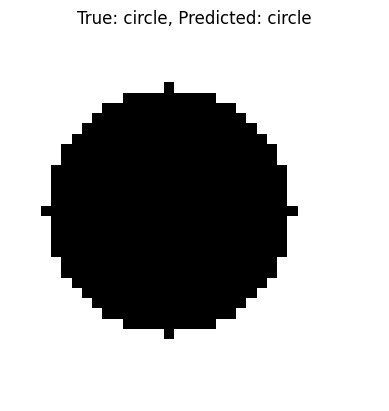

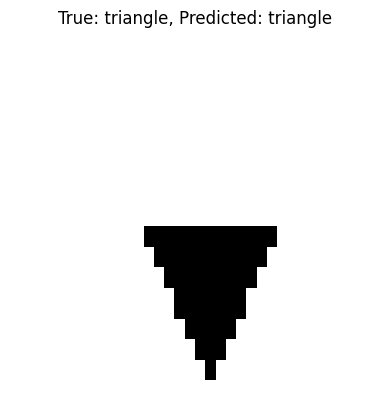

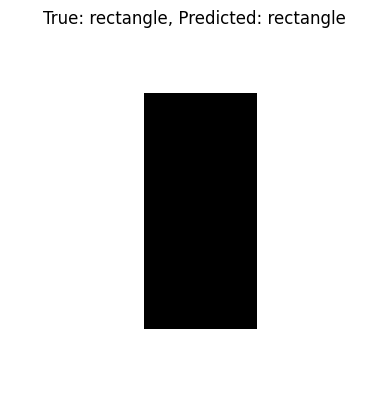

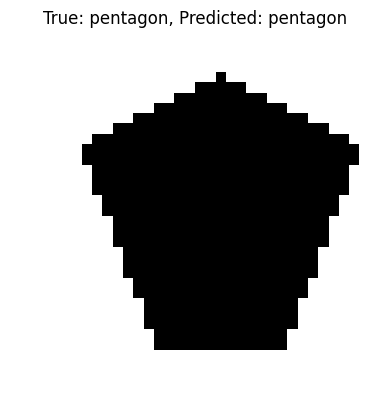

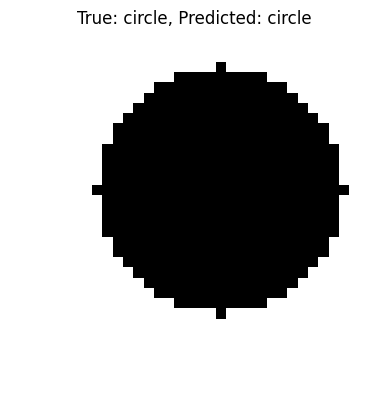

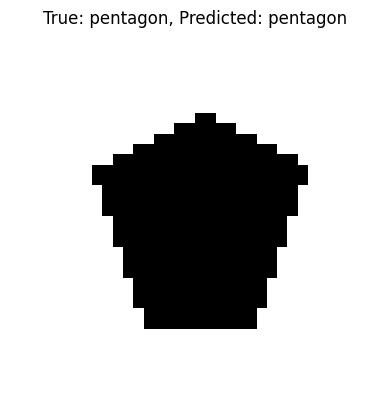

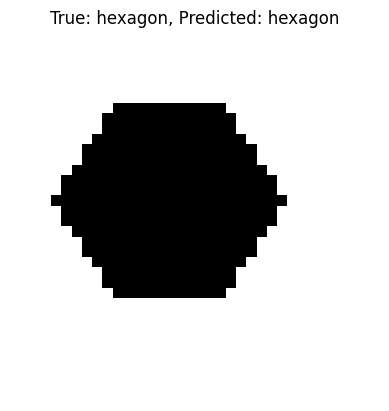

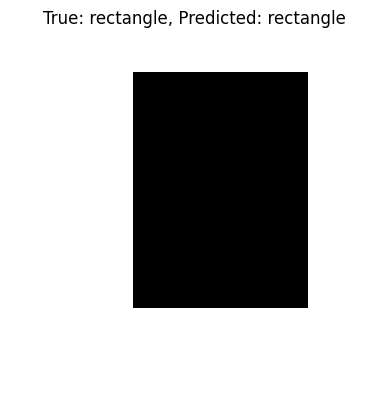

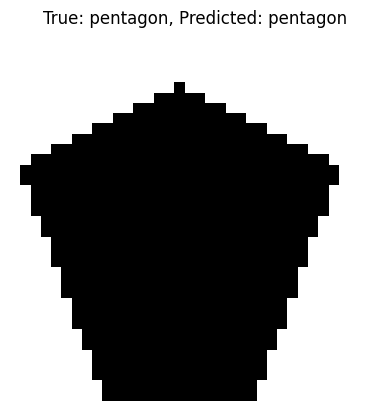

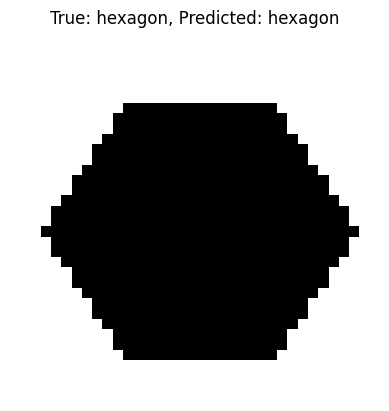

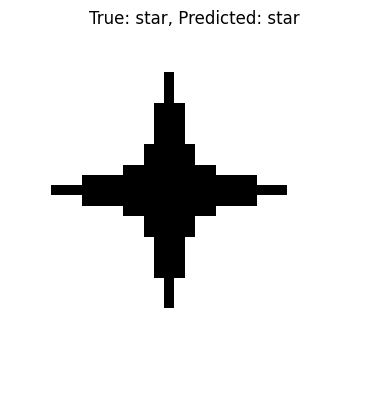

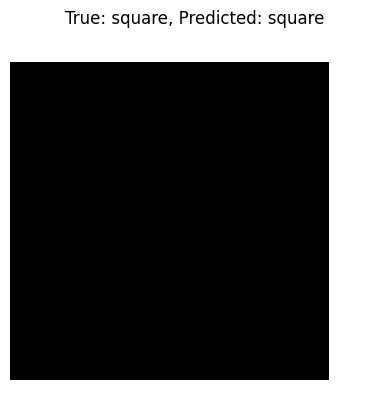

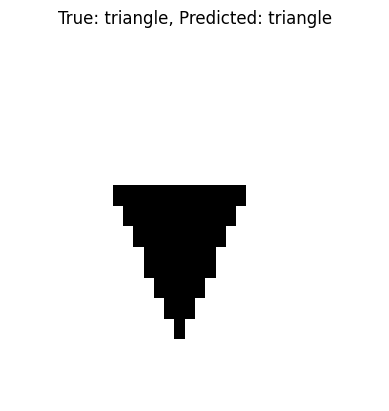

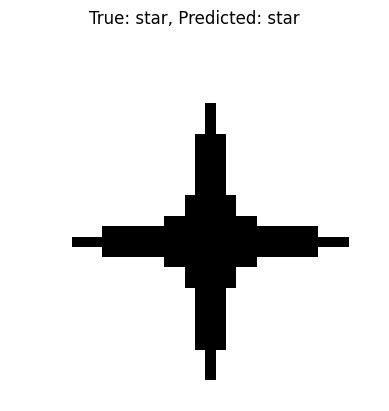

Test Accuracy: 0.9962121212121212


In [28]:

model = ShapeClassifier()
model.load_state_dict(torch.load('classifier.pth'))

# Dictionary to map numerical labels to shape names
class_names = {i: name for i, name in enumerate(sorted(os.listdir('data/shapes_data_test/')))}

def evaluate_classifier(model, data_loader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()

    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted_labels = torch.max(outputs, 1)

            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

            # Visualize images and predictions
            for i in range(images.size(0)):
                image = images[i].cpu().squeeze()
                true_label = class_names[labels[i].item()]
                predicted_label = class_names[predicted_labels[i].item()]

                plt.imshow(image, cmap='gray')
                plt.title(f'True: {true_label}, Predicted: {predicted_label}')
                plt.axis('off')
                plt.show()

    accuracy = correct_predictions / total_predictions
    return accuracy

test_accuracy = evaluate_classifier(model, shapes_loader_test)
print('Test Accuracy:', test_accuracy)


In [29]:
# from data_generator import *
# from perception import *
# sample = build_sample()
# img, objects, queries, programs, answers = convert_sample(sample)

### Perception Pipeline
`detector -> attribute (shape and color) extraction -> structural scene representation`

In [30]:
# Load the Model
perceiver = PerceptionPipe('detector.svm', 'classifier.pth', device='cuda')

In [31]:
perceiver

### Breakdown

In [32]:
# img, objects, queries, programs, answers 
objects

[(0, array([ 24, 140]), 'r', (9, 110, 39, 170)),
 (1, array([30, 79]), 'o', (15, 64, 45, 94)),
 (2, array([128, 138]), 's', (113, 123, 143, 153)),
 (3, array([171, 172]), 'r', (156, 142, 186, 202)),
 (4, array([128,  23]), 'q', (113, 8, 143, 38)),
 (5, array([88, 15]), 's', (73, 0, 103, 30))]

In [ ]:
# Inference with Detector
objects = perceiver.detect(img)
objects

In [34]:
# View the isolated objects (this will not work in colab as its headless)
# for obj, _ in objects:
#     cv2.imshow('frame', obj)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

In [35]:
# Inference with Attribute Extractor (Shape Classifier, Color Extractor)
shape, color = perceiver.extract_attributes(objects[4][0])
print(f'Shape = {shape}\nColor = {color}')

tensor([0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0') OUTTT
Shape = pentagon
Color = orange


### Pipeline

In [ ]:
scene = perceiver.scene_repr(img)

## Semantic Parser

### Preprocess Data

In [38]:
from semantic_parser import *
from torchtext.data import BucketIterator

In [39]:
# Create the preprocessor object and preprocess
preproc = Preprocessor('data/train/train_q2p.csv')

In [40]:
# Get the dataset object
train_data = preproc.train_data

In [41]:
# Looking at the Vocabulary
preproc.prog_f.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f645c811d50>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             '<nxt>': 4,
             'filter': 5,
             'query': 6,
             'shape': 7,
             'relate': 8,
             'position': 9,
             'green': 10,
             'istop': 11,
             'furthest': 12,
             'yellow': 13,
             'blue': 14,
             'closest': 15,
             'count': 16,
             'orange': 17,
             'red': 18,
             'gray': 19,
             'isleft': 20})

In [42]:
# Looking at the Vocabulary
preproc.que_f.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f645c811cd0>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             'the': 4,
             '?': 5,
             'object': 6,
             'is': 7,
             'shape': 8,
             'what': 9,
             'there': 10,
             'of': 11,
             'a': 12,
             'on': 13,
             'green': 14,
             'top': 15,
             'from': 16,
             'furthest': 17,
             'yellow': 18,
             'blue': 19,
             'closest': 20,
             'to': 21,
             'are': 22,
             'as': 23,
             'how': 24,
             'many': 25,
             'objects': 26,
             'same': 27,
             'orange': 28,
             'red': 29,
             'gray': 30,
             'left': 31})

### Training

In [43]:
# Training hyperparameters
num_epochs = 3
learning_rate = 3e-4
batch_size = 8
num_steps = len(train_data) / batch_size

# Model hyperparameters
config = {
    'que_vocab_size': len(preproc.que_f.vocab),
    'prog_vocab_size': len(preproc.prog_f.vocab),
    'embedding_dim': 256,
    'num_heads': 8,
    'num_encoder_layers': 3,
    'num_decoder_layers': 3,
    'dropout': 0.10,
    'max_len': 20,
    'forward_expansion': 4,
    'que_pad_idx': preproc.que_f.vocab.stoi["<pad>"]
}

In [44]:
# Save the config as a json file
import json
with open('config.json', 'w') as f:
    json.dump(config, f)

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
# Create Training Generator
train_loader = BucketIterator.splits((train_data,),
                                     batch_size=batch_size,
                                     sort_within_batch=True,
                                     sort_key=lambda x: len(x.query),
                                     device=device)[0]

In [47]:
# Create Model
seq2seq = Seq2Seq(config)

In [48]:
%%time
# Train Model
seq2seq.train_model(train_loader, num_epochs, num_steps, filename='semantic_parser.pth')

Epoch 1:   0%|          | 0/12500.0 [00:00<?, ?it/s]

Epoch 1: Mean Loss = 0.007339145791322953



Epoch 2:   0%|          | 0/12500.0 [00:00<?, ?it/s]

Epoch 2: Mean Loss = 0.0031788495470915406



Epoch 3:   0%|          | 0/12500.0 [00:00<?, ?it/s]

Epoch 3: Mean Loss = 0.0035685159971354822

CPU times: user 6h 50min 2s, sys: 10min 50s, total: 7h 52s
Wall time: 13min 9s


### Inference on Queries

In [49]:
sem_parser = SemanticParser(preproc, config)

In [50]:
program = sem_parser.predict('What is the furthest shape from the green object?')
program

['filter green', 'relate furthest', 'query shape']

## Program Executor

In [51]:
from program_executor import ProgramExecutor

In [52]:
executor = ProgramExecutor()

In [53]:
queries

['What is the furthest shape from the yellow object?',
 'What is the closest shape to the orange object?',
 'What is the furthest shape from the yellow object?',
 'What is the furthest shape from the yellow object?',
 'What is the furthest shape from the green object?',
 'What is the furthest shape from the green object?',
 'What is the furthest shape from the gray object?',
 'How many objects of the same shape as the red object are there?',
 'What is the closest shape to the red object?',
 'What is the closest shape to the green object?',
 'Is there a orange object on the left?',
 'What is the shape of the yellow object?',
 'Is there a red object on the top?',
 'Is there a orange object on the left?',
 'What is the shape of the red object?',
 'Is there a yellow object on the left?',
 'Is there a red object on the left?',
 'Is there a green object on the top?',
 'Is there a blue object on the left?',
 'Is there a orange object on the left?']

## Plugging Everything Together

In [56]:
from program_executor import *
from perception import *
from semantic_parser import *
import torch
from skimage.io import imshow
import cv2

In [57]:
# Load the config file for transformers
import json
with open('config.json', 'r') as f:
    config = json.load(f)

In [58]:
class NSAIPipeline():
    '''End-to-End Pipeline of Neuro-Symbolic AI on Sort-of-CLEVR dataset'''
    def __init__(self, 
                 config,
                 detector='detector.svm',
                 classifier='classifier.pth',
                 sem_parser='semantic_parser.pth',
                 train_csv='data/train/train_q2p.csv',
                 device=None):
        
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = device
        
        # Perception Module
        self.perceiver = PerceptionPipe(detector, classifier, self.device)
        
        # Semantic Parser
        self.preproc = Preprocessor(train_csv)
        self.sem_parser = SemanticParser(self.preproc, config, filename=sem_parser, device=self.device)
        
        # Program Executor
        self.executor = ProgramExecutor()
        
    def predict(self, img, query):
        '''
        Make Prediction on a single image and question pair
        
        Args:
            img (str/array): pixel values should be in 0-255 range
                             of dtype uint8 in BGR color format or
                             file path of the image
            query (str): question about the image
            
        Returns:
            str: answer of the query
        '''
        # Load img if it's a path
        if type(img) == str:
            img = cv2.imread(img)
        
        # Structured Scene Representation
        scene = self.perceiver.scene_repr(img)
        # Synthesize Program from Query
        program = self.sem_parser.predict(query)
        # Execute Program
        answer = self.executor(scene, program)
        return answer, program
  

In [59]:
nsai = NSAIPipeline(config)

In [60]:
nsai.predict('data/test/images/7.jpg', 'How many objects of the same shape as the red object are there?')

detectionsdetectionsdetections rectangles[[(125, 74) (157, 114)], [(73, 50) (105, 90)], [(33, 146) (65, 186)], [(149, 122) (181, 162)], [(37, 74) (69, 114)], [(105, 186) (137, 226)]]
tensor([0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0') OUTTT
tensor([0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0') OUTTT
tensor([0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0') OUTTT
tensor([0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0') OUTTT
tensor([0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0') OUTTT
tensor([0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0') OUTTT
['filter', 'red']
['query', 'shape']
['filter']
['count']


(1, ['filter red', 'query shape', 'filter', 'count'])

---
#### Debugging

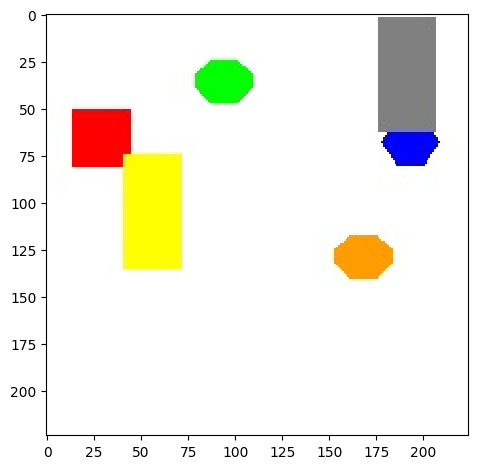

In [62]:
img2 = cv2.imread('data/train/images/7.jpg')
imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

In [63]:
nsai.executor.scene = nsai.perceiver.scene_repr(img2)
nsai.executor.scene

detectionsdetectionsdetections rectangles[[(81, 14) (113, 54)], [(153, 106) (185, 146)], [(13, 46) (45, 86)], [(37, 78) (83, 136)], [(181, 46) (213, 86)], [(177, 22) (209, 62)]]
tensor([0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0') OUTTT
tensor([0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0') OUTTT
tensor([0., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0') OUTTT
tensor([0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0') OUTTT
tensor([0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0') OUTTT
tensor([0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0') OUTTT


shape   color    position
0    hexagon   green    (97, 34)
1    hexagon  orange  (169, 126)
2  rectangle     red    (29, 66)
3   pentagon  yellow   (60, 107)
4    hexagon    blue   (197, 66)
5    octagon    gray   (193, 42)

In [64]:
program = nsai.sem_parser.predict('How many objects of the same shape as the green object are there? ')
program

['filter green', 'query shape', 'filter', 'count']

In [65]:
nsai.executor.count(nsai.executor.filter_(nsai.executor.query(nsai.executor.filter_('green'), 'shape')))

3

In [66]:
program = nsai.sem_parser.predict('What is the furthest shape from the green object?')
program

['filter green', 'relate furthest', 'query shape']

In [67]:
nsai.executor.query(nsai.executor.relate(nsai.executor.filter_('green'), 'furthest'), 'shape')

'hexagon'

In [68]:
program = nsai.sem_parser.predict('How many objects of the same shape are in top right? ')
program

['filter green', 'query shape', 'count']

In [69]:
nsai.executor.count(nsai.executor.filter_(nsai.executor.query(nsai.executor.filter_('yellow'), 'shape')))

1

In [70]:
val2attr = {'shape': ['rectangle', 'circle', 'triangle', 'square', 'pentagon', 'hexagon', 'octagon', 'star'], 'color': ['red', 'green', 'blue', 'orange', 'gray', 'yellow', 'Magenta', 'Cyan']}
val2attr.keys()

dict_keys(['shape', 'color'])